# COLA Emulator 2 - Trainer
Author: João Victor Rebouças, October 2022

Settings
- Higher Precision(L = 512, Np1D = 1024, Nmesh1D = 3072)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb
import os
from smt.sampling_methods import LHS
from scipy.integrate import simps
from scipy.interpolate import interp1d
from camb import model
from sklearn.decomposition import PCA
import emulator_funcs as emu
from emulator_funcs import params, lims, ref
from tensorflow import keras
from tensorflow.keras import layers
import sys
sys.path.append('/home/grads/data/xiao/miniconda/envs/cocoaemu/lib/python3.7/site-packages')
import euclidemu2 as ee2

In [2]:
# Matplotlib settings
axislabelfontsize='large'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
})
axislabelfontsize='large'

## 1. Data Preprocessing
The boosts will be calculated using the following equation:

$B^{\mathrm{case}} = B^\mathrm{ref}_{EE2} \times \frac{R_{NL}}{R_{L}}$
where
$R = \frac{P^\mathrm{case}}{P^{\mathrm{ref}}}$

In [3]:
# First, calculate reference boost with EE2
cosmo_par={'As'  :2.1e-09,
           'ns'  :0.96,
           'Omb' :0.049,
           'Omm' :0.319,
           'h'   :0.67,
           'mnu' :0.058,
           'w'   :-1.0,
           'wa'  :0.0}
ks_ee2, ref_pk_nl_ee2, ref_pk_lin_ee2, ref_boost_ee2 = ee2.get_pnonlin(cosmo_par, emu.redshifts, emu.ks_high_precision)
ref_boost_smeared_ee2 = np.zeros((len(emu.redshifts), len(emu.ks_high_precision)))
for i in range(len(emu.redshifts)):
    pk_lin = ref_pk_lin_ee2[i]
    pk_lin_no_wiggle = emu.smooth_bao(ks_ee2, pk_lin)
    pk_lin_smear = emu.smear_bao(ks_ee2, pk_lin, pk_lin_no_wiggle)
    ref_boost_smeared_ee2[i] = ref_boost_ee2[i] * pk_lin / pk_lin_smear # Changing boost to smeared boost

In [4]:
# Load ref cosmology from COLA, all redshifts
ref_pk_nonlin = np.zeros((len(emu.redshifts), len(emu.ks_high_precision)))
ref_pk_lin = np.zeros((len(emu.redshifts), len(emu.ks_high_precision)))
ref_pk_smear = np.zeros((len(emu.redshifts), len(emu.ks_high_precision)))
for i,z in enumerate(emu.redshifts):
    ref_pk_nonlin_phase1, ref_pk_lin_phase1 = np.genfromtxt(f'/home/grads/data/jonathan/cola_projects/5D_emulator2/reference/pofk_test7_total_z{z:.3f}.txt', unpack=True, usecols=(1,2), max_rows=len(emu.ks_high_precision))
    ref_pk_nonlin_phase2, ref_pk_lin_phase2 = np.genfromtxt(f'/home/grads/data/jonathan/cola_projects/5D_emulator2_b/output/reference/pofk_test12_total_z{z:.3f}.txt', unpack=True, usecols=(1,2), max_rows=len(emu.ks_high_precision))
    ref_pk_lin[i] = ref_pk_lin_phase1
    ref_pk_nonlin[i] = (ref_pk_nonlin_phase1 + ref_pk_nonlin_phase2)/2
    ref_pk_no_wiggle = emu.smooth_bao(emu.ks_high_precision, ref_pk_lin[i])
    ref_pk_smear[i] = emu.smear_bao(emu.ks_high_precision, ref_pk_lin[i], ref_pk_no_wiggle)
    if np.all(ref_pk_nonlin[i] > 1/8):
        ref_pk_nonlin[i] = ref_pk_nonlin[i] - 1/8

In [5]:
# Load cosmologies in LHS
num_of_points = 400
sample = np.genfromtxt('/home/grads/data/jonathan/cola_projects/5D_emulator2/lhs.txt')

In [6]:
# Adjusting to my previous convention of using 10**9 As
sample[:,3] = sample[:,3] * 10**9

In [7]:
# Reading COLA power spectra and defining boosts
pks_lin = np.zeros((num_of_points, len(emu.redshifts), len(emu.ks_high_precision))) # Shape is (num_simulations, num_redshifts, num_ks)
pks_nonlin = np.zeros((num_of_points, len(emu.redshifts), len(emu.ks_high_precision)))
qs = np.zeros((num_of_points, len(emu.redshifts), len(emu.ks_high_precision)))

for i in range(num_of_points):
    for j in range(len(emu.redshifts)):
        pks_nonlin_phase1, pks_lin[i,j,:] = np.genfromtxt(f'/home/grads/data/jonathan/cola_projects/5D_emulator2/output/{i}/pofk_run_{i}_total_z{emu.redshifts[j]:.3f}.txt', unpack=True, usecols=(1,2), max_rows=len(emu.ks_high_precision))
        pks_nonlin_phase2, pks_lin[i,j,:] = np.genfromtxt(f'/home/grads/data/jonathan/cola_projects/5D_emulator2_b/output/{i}/pofk_run_{i}_total_z{emu.redshifts[j]:.3f}.txt', unpack=True, usecols=(1,2), max_rows=len(emu.ks_high_precision))
        pks_nonlin[i,j,:] = (pks_nonlin_phase1 + pks_nonlin_phase2)/2
        if np.all(pks_nonlin[i,j,:] > 1/8):
            pks_nonlin[i,j,:] += - 1/8 # Subtracting shot noise
        pk_no_wiggle = emu.smooth_bao(emu.ks_high_precision, pks_lin[i,j,:])
        pk_lin_smeared = emu.smear_bao(emu.ks_high_precision, pks_lin[i,j,:], pk_no_wiggle)
        r_nl = pks_nonlin[i,j,:]/ref_pk_nonlin[j,:]
        r_l_smear = pk_lin_smeared/ref_pk_smear[j,:]
        
        qs[i,j,:] = np.log(ref_boost_smeared_ee2[j] * r_nl / r_l_smear)

In [8]:
# Saving boosts in Data/
for i, q in enumerate(qs):
    np.savetxt(f'./Data/Qs/qs_highprecision_{i}.txt', q, header='Redshift    K')

In [10]:
# Reading saved boosts from Data/
qs = np.zeros((num_of_points, len(emu.redshifts), len(emu.ks_high_precision)))
for i in range(num_of_points):
    qs[i] = np.loadtxt(f'./Data/Qs/qs_highprecision_{i}.txt')

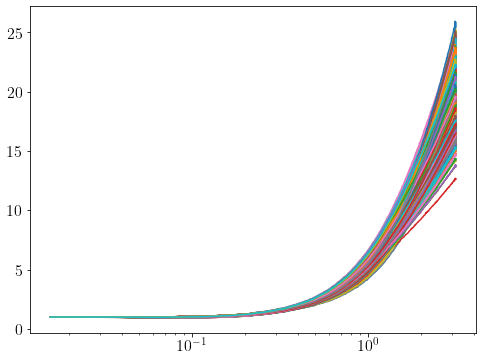

In [26]:
for i in range(len(sample)):
    plt.semilogx(emu.ks_high_precision, np.exp(qs[i,0]))

In [8]:
# Normalized parameters - input for NN
norm_sample = np.zeros((num_of_points,5))
for i, point in enumerate(sample):
    norm_params = emu.normalize_params(point)
    norm_sample[i] = norm_params

In [9]:
# Normalized Qs with Min-Max
norm_qs = np.zeros((num_of_points, len(emu.redshifts), len(emu.ks_high_precision)))
for i in range(len(emu.redshifts)):
    norm_qs[:,i,:] = emu.normalize_array(qs[:,i,:]) # I normalize within each redshift

In [12]:
# Getting and saving min and max for rescaling
mins = np.zeros(len(emu.redshifts))
maxs = np.zeros(len(emu.redshifts))
for i in range(len(emu.redshifts)):
    mins[i] = np.amin(qs[:,i,:])
    maxs[i] = np.amax(qs[:,i,:])
np.savetxt('./Data/mins_maxs_high_precision.txt', np.dstack((mins, maxs))[0])

In [51]:
num_pcs = 6
pca = PCA(n_components=num_pcs)
reduced_norm_qs_thisz = pca.fit_transform(norm_qs[:,0,:])
reconstructed_norm_qs_thisz = pca.inverse_transform(reduced_norm_qs_thisz)

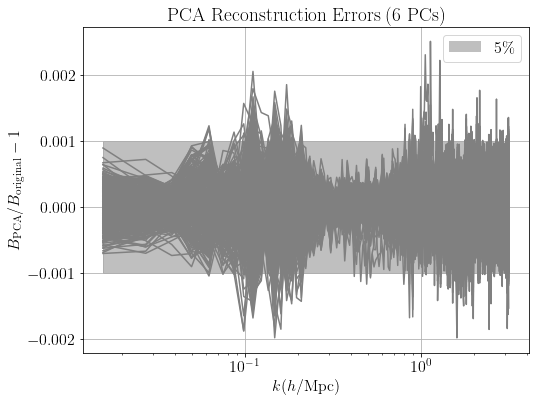

In [53]:
for i in range(len(sample)):
    plt.semilogx(emu.ks_high_precision, np.exp(reconstructed_norm_qs_thisz[i,:])/np.exp(norm_qs[i,0,:]) - 1, color='gray')
plt.fill_between(emu.ks_high_precision, -0.001, 0.001, color='gray', alpha=0.5)
plt.title('PCA Reconstruction Errors (6 PCs)')
plt.xlabel(r'$k (h/\mathrm{Mpc})$')
plt.ylabel(r'$B_\mathrm{PCA}/B_\mathrm{original} - 1$')
# Legend
from matplotlib.patches import Patch
gray_patch = Patch(facecolor='gray', alpha=0.5, label=r'$5\%$')
plt.grid()
plt.legend(handles=[gray_patch])

In [10]:
# PCA reduction
num_pcs = 6
pcas, reduced_norm_qs = emu.pca_reduction(num_pcs, norm_qs, qs)

In [24]:
mins_pcs = np.zeros(len(emu.redshifts))
maxs_pcs = np.zeros(len(emu.redshifts))
for i in range(len(emu.redshifts)):
    mins_pcs[i] = np.amin(reduced_norm_qs[:,i,:])
    maxs_pcs[i] = np.amax(reduced_norm_qs[:,i,:])
    pc_components = pcas[i].components_
    avg = pcas[i].mean_
    np.savetxt('./Data/PC_Basis/components_high_precision_{:.2f}.txt'.format(emu.redshifts[i]), pc_components)
    np.savetxt('./Data/Averages/average_high_precision_{:.2f}.txt'.format(emu.redshifts[i]), avg)
np.savetxt('./Data/mins_maxs_pcs_high_precision.txt', np.dstack((mins_pcs, maxs_pcs))[0])

## 2. Neural Network Architecture and Training
Training strategy:
 - First, train the chosen architecture for many epochs (I chose 30k) with train-validation splitting. Plot the train and validation losses as a function of the number of epochs. Choose an optimal number of training epochs.
 - When the model is initialized, train for a few (300) epochs. I noticed that sometimes the model gets stuck at losses around 7% or even 15%. Such local minima are hard to get out from. The "best" minimum is under 1% errors, and we want to converge to that. This way, in this initial training, I check if the model is stuck at a bad minimum. If so, I initialize the model again. Most of the times, the model quickly finds the best minimum.
 - After this, train for the number of epochs determined in step 1.

In [11]:
input_data = norm_sample # Normalized Cosmological Parameters

In [12]:
def nn_model_train(pc_components, input_data):
    '''
    Creates and trains a neural network model that emulates the pc_components from the input_data
    Returns
    '''
    norm_pcs = emu.normalize_array(pc_components)
    ground_truths = norm_pcs
    emulator_model = emu.generate_model(num_pcs, 2, input_data, num_of_neurons=1024)
    
    emulator_model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = keras.losses.MeanAbsoluteError()
        # metrics = [keras.metrics.Precision()]
    )
    # Dividing into train/validation
    history = emulator_model.fit(
                            input_data,
                            ground_truths,
                            batch_size = 30,
                            epochs = 300,
                            #validation_data = (input_data[360:], ground_truths[360:])
                            )
    last_loss = history.history['loss'][-1]
    return emulator_model, last_loss

In [15]:
# Training loop for all redshifts
# assert False, "Make sure you really want to run this"
for i in range(10): # One NN for each redshift
    j = 26 # Starting from redshifts[j]
    
    emulator_model, last_loss = nn_model_train(reduced_norm_qs[:,j+i,:], input_data)
    while last_loss > 0.01:
        print('Stuck on a bad local minimum. Retraining:')
        emulator_model, last_loss = nn_model_train(reduced_norm_qs[:,j+i,:], input_data)
    # If unstuck, train for longer
    norm_pcs = emu.normalize_array(reduced_norm_qs[:,j+i,:])
    ground_truths = norm_pcs
    history = emulator_model.fit(
                            input_data,
                            ground_truths,
                            batch_size = 30,
                            epochs = 5000
                            #validation_data = (input_data[360:], ground_truths[360:])
                            )
    emulator_model.save(f'./NN_MODELS_Q/COLA_EMU_2_NHID=2_NEURONS=1024_z={emu.redshifts[j+i]:.3f}')

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer1 (Dense)          (1, 1024)                 6144      
                                                                 
 hid_layer2 (Dense)          (1, 1024)                 1049600   
                                                                 
 out_layer (Dense)           (1, 6)                    6150      
                                                                 
Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 0s 4ms/step - loss: 0.1220
Epoch 2/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0529
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 4/300
14/14 [==============================] - 0s 4ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 93/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 94/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 95/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 96/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 97/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 98/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 99/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 100/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 101/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 102/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 103/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 104/300
14/14 [================

14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 193/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 194/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 195/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 196/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 197/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 198/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 199/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 200/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 201/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 202/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 203/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 204/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 293/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 294/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 295/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 296/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 297/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 298/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 299/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 300/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 1/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 2/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 3/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 4/5000
14/14 [=============

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 93/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 94/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 95/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 96/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 97/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 98/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 99/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 100/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 101/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 102/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 103/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 104/5000
14/14 [====

Epoch 191/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 192/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 193/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 194/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 195/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 196/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 197/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 198/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 199/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 200/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 201/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 202/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoc

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 290/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 291/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 292/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 293/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 294/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 295/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 296/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 297/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 298/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 299/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 300/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 301/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 388/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 389/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 390/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 391/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 392/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 393/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 394/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 395/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 396/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 397/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 398/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 399/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 486/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 487/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 488/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 489/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 490/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 491/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 492/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 493/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 494/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 495/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 496/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 497/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 584/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 585/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 586/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 587/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 588/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 589/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 590/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 591/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 592/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 593/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 594/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 595/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 682/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 683/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 684/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 685/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 686/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 687/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 688/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 689/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 690/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 691/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 692/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 693/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 780/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 781/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 782/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 783/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 784/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 785/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 786/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 787/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 788/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 789/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9125e-04
Epoch 790/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9168e-04
Epoch 791/5

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 878/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 879/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 880/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 881/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 882/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 883/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 884/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 885/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 886/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 887/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 888/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 889/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 8.5802e-04
Epoch 976/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 977/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9563e-04
Epoch 978/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1720e-04
Epoch 979/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 980/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9297e-04
Epoch 981/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 982/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 983/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 984/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 985/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8960e-04
Epoch 986/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5864

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1073/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1074/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1075/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1076/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9946e-04
Epoch 1077/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1164e-04
Epoch 1078/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1079/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0216e-04
Epoch 1080/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4336e-04
Epoch 1081/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5957e-04
Epoch 1082/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1083/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1169/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1170/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9955e-04
Epoch 1171/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1172/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4975e-04
Epoch 1173/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1174/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1175/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1176/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7183e-04
Epoch 1177/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1618e-04
Epoch 1178/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5504e-04
Epoch 1179/5000
14/14 [==============================] - 0s 4ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 9.0877e-04
Epoch 1264/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6059e-04
Epoch 1265/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1266/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9846e-04
Epoch 1267/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1268/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1269/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8141e-04
Epoch 1270/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9651e-04
Epoch 1271/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1272/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1273/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1274/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 8.8043e-04
Epoch 1359/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 1360/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1361/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1362/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1363/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1364/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1365/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7743e-04
Epoch 1366/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7637e-04
Epoch 1367/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1368/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1369/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1454/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1455/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1456/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7143e-04
Epoch 1457/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6655e-04
Epoch 1458/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4000e-04
Epoch 1459/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1460/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1462/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1463/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1464/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1549/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0897e-04
Epoch 1550/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1551/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2335e-04
Epoch 1552/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2858e-04
Epoch 1553/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1554/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1555/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1556/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1557/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1558/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3007e-04
Epoch 1559/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1644/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1645/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1646/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2230e-04
Epoch 1647/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7346e-04
Epoch 1648/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1649/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2986e-04
Epoch 1650/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1651/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0553e-04
Epoch 1652/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8280e-04
Epoch 1653/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3930e-04
Epoch 1654/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1739/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1740/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6201e-04
Epoch 1741/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3617e-04
Epoch 1742/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5461e-04
Epoch 1743/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9654e-04
Epoch 1744/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1745/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1746/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1747/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1748/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1749/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1834/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 1835/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 1836/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1837/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1838/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1839/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1840/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1841/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1842/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2904e-04
Epoch 1843/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1909e-04
Epoch 1844/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2708e

14/14 [==============================] - 0s 4ms/step - loss: 9.4371e-04
Epoch 1929/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8885e-04
Epoch 1930/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8610e-04
Epoch 1931/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9926e-04
Epoch 1932/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0124e-04
Epoch 1933/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5785e-04
Epoch 1934/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1935/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5696e-04
Epoch 1936/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4252e-04
Epoch 1937/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9954e-04
Epoch 1938/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5076e-04
Epoch 1939/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.8682e-04
Epoch 2024/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2737e-04
Epoch 2025/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9773e-04
Epoch 2026/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5558e-04
Epoch 2027/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8185e-04
Epoch 2028/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0229e-04
Epoch 2029/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0412e-04
Epoch 2030/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5358e-04
Epoch 2031/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5437e-04
Epoch 2032/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5349e-04
Epoch 2033/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 2034/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2118/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7983e-04
Epoch 2119/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 2120/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5773e-04
Epoch 2121/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6801e-04
Epoch 2122/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9614e-04
Epoch 2123/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8190e-04
Epoch 2124/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5327e-04
Epoch 2125/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3718e-04
Epoch 2126/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7357e-04
Epoch 2127/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8298e-04
Epoch 2128/5000
14/14 [==============================] -

Epoch 2212/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2213/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7641e-04
Epoch 2214/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7281e-04
Epoch 2215/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4224e-04
Epoch 2216/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5968e-04
Epoch 2217/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0208e-04
Epoch 2218/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6627e-04
Epoch 2219/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1580e-04
Epoch 2220/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7592e-04
Epoch 2221/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2222/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2223/5000
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 9.5343e-04
Epoch 2306/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3361e-04
Epoch 2307/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0308e-04
Epoch 2308/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4421e-04
Epoch 2309/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1063e-04
Epoch 2310/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3790e-04
Epoch 2311/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4719e-04
Epoch 2312/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2313/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5393e-04
Epoch 2314/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5824e-04
Epoch 2315/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4778e-04
Epoch 2316/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.0279e-04
Epoch 2400/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7604e-04
Epoch 2401/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0744e-04
Epoch 2402/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6115e-04
Epoch 2403/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5782e-04
Epoch 2404/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2334e-04
Epoch 2405/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2880e-04
Epoch 2406/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6404e-04
Epoch 2407/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8377e-04
Epoch 2408/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8200e-04
Epoch 2409/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5565e-04
Epoch 2410/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.9679e-04
Epoch 2494/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0504e-04
Epoch 2495/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4311e-04
Epoch 2496/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6719e-04
Epoch 2497/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2498/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2499/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2500/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6560e-04
Epoch 2501/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2119e-04
Epoch 2502/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7689e-04
Epoch 2503/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6103e-04
Epoch 2504/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.1353e-04
Epoch 2588/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2589/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2590/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2591/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3938e-04
Epoch 2592/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9453e-04
Epoch 2593/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9431e-04
Epoch 2594/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2436e-04
Epoch 2595/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2596/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0522e-04
Epoch 2597/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1069e-04
Epoch 2598/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 4ms/step - loss: 8.3919e-04
Epoch 2682/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2683/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1045e-04
Epoch 2684/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1742e-04
Epoch 2685/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5325e-04
Epoch 2686/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2662e-04
Epoch 2687/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4254e-04
Epoch 2688/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3534e-04
Epoch 2689/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1793e-04
Epoch 2690/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3458e-04
Epoch 2691/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9219e-04
Epoch 2692/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.5811e-04
Epoch 2776/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2777/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4324e-04
Epoch 2778/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2779/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3124e-04
Epoch 2780/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8446e-04
Epoch 2781/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3156e-04
Epoch 2782/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8984e-04
Epoch 2783/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4883e-04
Epoch 2784/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2785/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2786/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 8.5999e-04
Epoch 2870/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1997e-04
Epoch 2871/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2872/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2873/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2874/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2875/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4448e-04
Epoch 2876/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4220e-04
Epoch 2877/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1024e-04
Epoch 2878/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7629e-04
Epoch 2879/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0299e-04
Epoch 2880/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 5.7122e-04
Epoch 2963/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4175e-04
Epoch 2964/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2989e-04
Epoch 2965/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2966/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5972e-04
Epoch 2967/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9184e-04
Epoch 2968/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4019e-04
Epoch 2969/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3482e-04
Epoch 2970/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2971/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2972/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3453e-04
Epoch 2973/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3057/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8265e-04
Epoch 3058/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5324e-04
Epoch 3059/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1269e-04
Epoch 3060/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7449e-04
Epoch 3061/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3062/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1032e-04
Epoch 3063/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1190e-04
Epoch 3064/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1847e-04
Epoch 3065/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3066/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3067/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 8.4706e-04
Epoch 3150/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0256e-04
Epoch 3151/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8432e-04
Epoch 3152/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5953e-04
Epoch 3153/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7432e-04
Epoch 3154/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6809e-04
Epoch 3155/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4042e-04
Epoch 3156/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7809e-04
Epoch 3157/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7679e-04
Epoch 3158/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4565e-04
Epoch 3159/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5125e-04
Epoch 3160/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.5990e-04
Epoch 3243/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3759e-04
Epoch 3244/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3168e-04
Epoch 3245/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3859e-04
Epoch 3246/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6692e-04
Epoch 3247/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2610e-04
Epoch 3248/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4634e-04
Epoch 3249/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3250/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6391e-04
Epoch 3251/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5200e-04
Epoch 3252/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6717e-04
Epoch 3253/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.6603e-04
Epoch 3336/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0241e-04
Epoch 3337/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6415e-04
Epoch 3338/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7394e-04
Epoch 3339/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7896e-04
Epoch 3340/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7589e-04
Epoch 3341/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5134e-04
Epoch 3342/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2278e-04
Epoch 3343/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5555e-04
Epoch 3344/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9942e-04
Epoch 3345/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8456e-04
Epoch 3346/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.5383e-04
Epoch 3429/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3430/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1990e-04
Epoch 3431/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8332e-04
Epoch 3432/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4290e-04
Epoch 3433/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7589e-04
Epoch 3434/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3949e-04
Epoch 3435/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3363e-04
Epoch 3436/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4758e-04
Epoch 3437/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1120e-04
Epoch 3438/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4448e-04
Epoch 3439/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.3406e-04
Epoch 3522/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4244e-04
Epoch 3523/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9520e-04
Epoch 3524/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2595e-04
Epoch 3525/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0873e-04
Epoch 3526/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4067e-04
Epoch 3527/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1662e-04
Epoch 3528/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5723e-04
Epoch 3529/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6429e-04
Epoch 3530/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3003e-04
Epoch 3531/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4736e-04
Epoch 3532/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.5437e-04
Epoch 3615/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8521e-04
Epoch 3616/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0637e-04
Epoch 3617/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9548e-04
Epoch 3618/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8679e-04
Epoch 3619/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5874e-04
Epoch 3620/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7344e-04
Epoch 3621/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9910e-04
Epoch 3622/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8477e-04
Epoch 3623/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5641e-04
Epoch 3624/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3104e-04
Epoch 3625/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.6333e-04
Epoch 3708/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1271e-04
Epoch 3709/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1026e-04
Epoch 3710/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7517e-04
Epoch 3711/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5143e-04
Epoch 3712/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4973e-04
Epoch 3713/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1010e-04
Epoch 3714/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5977e-04
Epoch 3715/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1155e-04
Epoch 3716/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0621e-04
Epoch 3717/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5281e-04
Epoch 3718/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.2041e-04
Epoch 3801/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4440e-04
Epoch 3802/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1783e-04
Epoch 3803/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3261e-04
Epoch 3804/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8309e-04
Epoch 3805/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7747e-04
Epoch 3806/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5812e-04
Epoch 3807/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0944e-04
Epoch 3808/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4217e-04
Epoch 3809/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6270e-04
Epoch 3810/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9111e-04
Epoch 3811/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.1817e-04
Epoch 3894/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7131e-04
Epoch 3895/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2697e-04
Epoch 3896/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6635e-04
Epoch 3897/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4156e-04
Epoch 3898/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5481e-04
Epoch 3899/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0158e-04
Epoch 3900/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5172e-04
Epoch 3901/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8068e-04
Epoch 3902/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2808e-04
Epoch 3903/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6395e-04
Epoch 3904/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.1177e-04
Epoch 3987/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3425e-04
Epoch 3988/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3662e-04
Epoch 3989/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8270e-04
Epoch 3990/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3991/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3992/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2541e-04
Epoch 3993/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1911e-04
Epoch 3994/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2847e-04
Epoch 3995/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5834e-04
Epoch 3996/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2262e-04
Epoch 3997/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 5.8622e-04
Epoch 4080/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4081/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4421e-04
Epoch 4082/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4137e-04
Epoch 4083/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2507e-04
Epoch 4084/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6049e-04
Epoch 4085/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3266e-04
Epoch 4086/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8946e-04
Epoch 4087/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9681e-04
Epoch 4088/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4769e-04
Epoch 4089/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4010e-04
Epoch 4090/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.1817e-04
Epoch 4173/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6303e-04
Epoch 4174/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5024e-04
Epoch 4175/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6927e-04
Epoch 4176/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0638e-04
Epoch 4177/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0359e-04
Epoch 4178/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2399e-04
Epoch 4179/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4180/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5619e-04
Epoch 4181/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4483e-04
Epoch 4182/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7619e-04
Epoch 4183/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.8233e-04
Epoch 4266/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5602e-04
Epoch 4267/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1786e-04
Epoch 4268/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0363e-04
Epoch 4269/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6998e-04
Epoch 4270/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4799e-04
Epoch 4271/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4648e-04
Epoch 4272/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8645e-04
Epoch 4273/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7085e-04
Epoch 4274/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0648e-04
Epoch 4275/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6898e-04
Epoch 4276/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8384e-04
Epoch 4359/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3430e-04
Epoch 4360/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4361/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1395e-04
Epoch 4362/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8890e-04
Epoch 4363/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8175e-04
Epoch 4364/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0946e-04
Epoch 4365/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8958e-04
Epoch 4366/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6034e-04
Epoch 4367/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4655e-04
Epoch 4368/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1184e-04
Epoch 4369/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 7.1623e-04
Epoch 4452/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0902e-04
Epoch 4453/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9184e-04
Epoch 4454/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4008e-04
Epoch 4455/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4006e-04
Epoch 4456/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1313e-04
Epoch 4457/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5658e-04
Epoch 4458/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6369e-04
Epoch 4459/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9600e-04
Epoch 4460/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9780e-04
Epoch 4461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4462/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.4212e-04
Epoch 4545/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4060e-04
Epoch 4546/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0953e-04
Epoch 4547/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4819e-04
Epoch 4548/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6542e-04
Epoch 4549/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3831e-04
Epoch 4550/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9627e-04
Epoch 4551/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2130e-04
Epoch 4552/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4697e-04
Epoch 4553/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5158e-04
Epoch 4554/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6355e-04
Epoch 4555/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.5001e-04
Epoch 4638/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6945e-04
Epoch 4639/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1217e-04
Epoch 4640/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7549e-04
Epoch 4641/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8220e-04
Epoch 4642/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5773e-04
Epoch 4643/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6738e-04
Epoch 4644/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6795e-04
Epoch 4645/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9378e-04
Epoch 4646/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2786e-04
Epoch 4647/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1362e-04
Epoch 4648/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.1397e-04
Epoch 4731/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4411e-04
Epoch 4732/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0998e-04
Epoch 4733/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0466e-04
Epoch 4734/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0801e-04
Epoch 4735/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6043e-04
Epoch 4736/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4159e-04
Epoch 4737/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8220e-04
Epoch 4738/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9721e-04
Epoch 4739/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8703e-04
Epoch 4740/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0637e-04
Epoch 4741/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.7942e-04
Epoch 4824/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9008e-04
Epoch 4825/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1343e-04
Epoch 4826/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4827/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4576e-04
Epoch 4828/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2120e-04
Epoch 4829/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1429e-04
Epoch 4830/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3616e-04
Epoch 4831/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5881e-04
Epoch 4832/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7316e-04
Epoch 4833/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0490e-04
Epoch 4834/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 6.6597e-04
Epoch 4917/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9478e-04
Epoch 4918/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5210e-04
Epoch 4919/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8292e-04
Epoch 4920/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2882e-04
Epoch 4921/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7395e-04
Epoch 4922/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6122e-04
Epoch 4923/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2374e-04
Epoch 4924/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5624e-04
Epoch 4925/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9918e-04
Epoch 4926/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.0674e-04
Epoch 4927/5000
14/14 [=========================

Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1240
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 8/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 9/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 10/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 11/300
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 101/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 102/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 103/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 104/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 105/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 106/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 107/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 108/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 109/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 110/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 111/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 112/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 201/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 202/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 203/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 204/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 205/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 206/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 207/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 208/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 209/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 210/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 211/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 212/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 1/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 2/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 3/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 5/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 8/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 9/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 10/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 11/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 12/5000
14/14 [==================

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 101/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 102/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 103/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 104/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 105/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 106/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 107/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 108/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 109/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 110/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 111/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 112/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 199/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 200/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 201/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 202/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 203/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 204/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 205/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 206/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 207/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 208/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 209/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 210/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 297/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 298/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 299/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 300/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 301/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 302/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 303/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 304/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 305/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 306/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 307/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 308/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 395/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 396/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 397/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 398/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 399/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 400/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 401/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 402/5000
14/14 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 403/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 404/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 405/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 406/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 9.5344e-04
Epoch 493/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 494/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6356e-04
Epoch 495/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 496/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 497/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 498/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 499/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 500/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 501/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 502/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 503/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 504/5

14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 591/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 592/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 593/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 594/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 595/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 596/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 597/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 598/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 599/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 600/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 601/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 602/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 9.1334e-04
Epoch 689/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 690/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 691/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 692/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 693/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 694/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 695/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 696/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 697/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 698/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 699/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 700/5000


14/14 [==============================] - 0s 4ms/step - loss: 9.0832e-04
Epoch 786/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 787/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 788/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 789/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 790/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4169e-04
Epoch 791/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7913e-04
Epoch 792/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 793/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 794/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 795/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 796/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6769e-04
Epo

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 883/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 884/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 885/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 886/5000
14/14 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 887/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4549e-04
Epoch 888/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1831e-04
Epoch 889/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 890/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 891/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 892/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 893/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7644e-04
Epoch 8

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 980/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 981/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 982/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 983/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 984/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 985/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 986/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 987/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 988/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 989/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 990/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 991/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1076/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1077/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1078/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1079/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1080/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1081/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1082/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1083/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1084/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3496e-04
Epoch 1085/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9920e-04
Epoch 1086/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011


14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1171/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1172/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1173/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0101e-04
Epoch 1174/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8705e-04
Epoch 1175/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1176/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6426e-04
Epoch 1177/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1178/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1179/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1180/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5337e-04
Epoch 1181/5000
14/14 [==============================] - 0s 4ms/step - loss:

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1267/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1268/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1269/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1270/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1271/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1272/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1273/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1274/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1275/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1276/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4147e-04
Epoch 1277/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoc

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1362/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1363/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1364/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5289e-04
Epoch 1365/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7899e-04
Epoch 1366/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3030e-04
Epoch 1367/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1368/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1369/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1370/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3075e-04
Epoch 1371/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9089e-04
Epoch 1372/5000
14/14 [==============================] - 0s 4ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 7.9419e-04
Epoch 1457/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1458/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1459/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1460/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1462/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1463/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8520e-04
Epoch 1464/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7751e-04
Epoch 1465/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8566e-04
Epoch 1466/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1467/5000
14/14 [==============================] - 0s 4ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 8.3568e-04
Epoch 1552/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1742e-04
Epoch 1553/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5910e-04
Epoch 1554/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5027e-04
Epoch 1555/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1556/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1557/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1558/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9125e-04
Epoch 1559/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1560/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3072e-04
Epoch 1561/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8407e-04
Epoch 1562/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 8.6242e-04
Epoch 1647/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5774e-04
Epoch 1648/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3716e-04
Epoch 1649/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0082e-04
Epoch 1650/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4666e-04
Epoch 1651/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6317e-04
Epoch 1652/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4096e-04
Epoch 1653/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6365e-04
Epoch 1654/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8670e-04
Epoch 1655/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1656/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1657/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 7.4156e-04
Epoch 1741/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9116e-04
Epoch 1742/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1743/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7706e-04
Epoch 1744/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0179e-04
Epoch 1745/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4087e-04
Epoch 1746/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9567e-04
Epoch 1747/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3914e-04
Epoch 1748/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9486e-04
Epoch 1749/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5823e-04
Epoch 1750/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1751/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1835/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1836/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1837/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7303e-04
Epoch 1838/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1839/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3701e-04
Epoch 1840/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8035e-04
Epoch 1841/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6870e-04
Epoch 1842/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1843/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1844/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5262e-04
Epoch 1845/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 8.1211e-04
Epoch 1929/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9812e-04
Epoch 1930/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2520e-04
Epoch 1931/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6546e-04
Epoch 1932/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4196e-04
Epoch 1933/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1934/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1935/5000
14/14 [==============================] - 0s 3ms/step - loss: 8.4993e-04
Epoch 1936/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9596e-04
Epoch 1937/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1938/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6191e-04
Epoch 1939/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 4ms/step - loss: 8.0974e-04
Epoch 2023/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1332e-04
Epoch 2024/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3246e-04
Epoch 2025/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2897e-04
Epoch 2026/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0282e-04
Epoch 2027/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2015e-04
Epoch 2028/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9452e-04
Epoch 2029/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0298e-04
Epoch 2030/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2031/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7957e-04
Epoch 2032/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2033/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.3886e-04
Epoch 2117/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2118/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3331e-04
Epoch 2119/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9866e-04
Epoch 2120/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1766e-04
Epoch 2121/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7796e-04
Epoch 2122/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1292e-04
Epoch 2123/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2334e-04
Epoch 2124/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5767e-04
Epoch 2125/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7427e-04
Epoch 2126/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2127/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.1231e-04
Epoch 2211/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2468e-04
Epoch 2212/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7807e-04
Epoch 2213/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2320e-04
Epoch 2214/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5597e-04
Epoch 2215/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9513e-04
Epoch 2216/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2217/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3700e-04
Epoch 2218/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0136e-04
Epoch 2219/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7431e-04
Epoch 2220/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6787e-04
Epoch 2221/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 6.9263e-04
Epoch 2305/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7522e-04
Epoch 2306/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2307/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2308/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2309/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 2310/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2311/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7674e-04
Epoch 2312/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9239e-04
Epoch 2313/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7449e-04
Epoch 2314/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6328e-04
Epoch 2315/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 7.5223e-04
Epoch 2399/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6611e-04
Epoch 2400/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1882e-04
Epoch 2401/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0291e-04
Epoch 2402/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9849e-04
Epoch 2403/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7313e-04
Epoch 2404/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3613e-04
Epoch 2405/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1501e-04
Epoch 2406/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1920e-04
Epoch 2407/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8929e-04
Epoch 2408/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2409/5000
14/14 [=============================

Epoch 2492/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4140e-04
Epoch 2493/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3954e-04
Epoch 2494/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3434e-04
Epoch 2495/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3670e-04
Epoch 2496/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6496e-04
Epoch 2497/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6915e-04
Epoch 2498/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0702e-04
Epoch 2499/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9579e-04
Epoch 2500/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0733e-04
Epoch 2501/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5994e-04
Epoch 2502/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3511e-04
Epoch 2503/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 7.1866e-04
Epoch 2586/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6189e-04
Epoch 2587/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2699e-04
Epoch 2588/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5505e-04
Epoch 2589/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5734e-04
Epoch 2590/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2591/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6255e-04
Epoch 2592/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3468e-04
Epoch 2593/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7709e-04
Epoch 2594/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9907e-04
Epoch 2595/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2596/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.0524e-04
Epoch 2679/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0661e-04
Epoch 2680/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7898e-04
Epoch 2681/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2682/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8397e-04
Epoch 2683/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0488e-04
Epoch 2684/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7897e-04
Epoch 2685/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2686/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2687/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2688/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0211e-04
Epoch 2689/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 5ms/step - loss: 7.5160e-04
Epoch 2773/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3987e-04
Epoch 2774/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0812e-04
Epoch 2775/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8121e-04
Epoch 2776/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1232e-04
Epoch 2777/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2395e-04
Epoch 2778/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9669e-04
Epoch 2779/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6101e-04
Epoch 2780/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4905e-04
Epoch 2781/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0955e-04
Epoch 2782/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6373e-04
Epoch 2783/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7347e-04
Epoch 2866/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8661e-04
Epoch 2867/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1292e-04
Epoch 2868/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2869/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9111e-04
Epoch 2870/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7833e-04
Epoch 2871/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7465e-04
Epoch 2872/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8380e-04
Epoch 2873/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2874/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1077e-04
Epoch 2875/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3401e-04
Epoch 2876/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.6695e-04
Epoch 2959/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2960/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3537e-04
Epoch 2961/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0042e-04
Epoch 2962/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0735e-04
Epoch 2963/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2604e-04
Epoch 2964/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2868e-04
Epoch 2965/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1672e-04
Epoch 2966/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9739e-04
Epoch 2967/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2545e-04
Epoch 2968/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0320e-04
Epoch 2969/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 7.1795e-04
Epoch 3052/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3726e-04
Epoch 3053/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6826e-04
Epoch 3054/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2637e-04
Epoch 3055/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2437e-04
Epoch 3056/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9655e-04
Epoch 3057/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7713e-04
Epoch 3058/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0623e-04
Epoch 3059/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2215e-04
Epoch 3060/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6317e-04
Epoch 3061/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8530e-04
Epoch 3062/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.6689e-04
Epoch 3145/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1362e-04
Epoch 3146/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5042e-04
Epoch 3147/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7587e-04
Epoch 3148/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9020e-04
Epoch 3149/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4936e-04
Epoch 3150/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3429e-04
Epoch 3151/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2855e-04
Epoch 3152/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3153/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3154/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8068e-04
Epoch 3155/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3238/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3239/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3240/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3241/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8964e-04
Epoch 3242/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2452e-04
Epoch 3243/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7918e-04
Epoch 3244/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3607e-04
Epoch 3245/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9031e-04
Epoch 3246/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2912e-04
Epoch 3247/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2460e-04
Epoch 3248/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 4ms/step - loss: 5.5444e-04
Epoch 3331/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6257e-04
Epoch 3332/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4191e-04
Epoch 3333/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3540e-04
Epoch 3334/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8268e-04
Epoch 3335/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7462e-04
Epoch 3336/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7037e-04
Epoch 3337/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3619e-04
Epoch 3338/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4194e-04
Epoch 3339/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0582e-04
Epoch 3340/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7424e-04
Epoch 3341/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.5327e-04
Epoch 3424/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4318e-04
Epoch 3425/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0277e-04
Epoch 3426/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3527e-04
Epoch 3427/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5457e-04
Epoch 3428/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9185e-04
Epoch 3429/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0240e-04
Epoch 3430/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5819e-04
Epoch 3431/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2026e-04
Epoch 3432/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6798e-04
Epoch 3433/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0739e-04
Epoch 3434/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4230e-04
Epoch 3517/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0998e-04
Epoch 3518/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2403e-04
Epoch 3519/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3038e-04
Epoch 3520/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6085e-04
Epoch 3521/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4305e-04
Epoch 3522/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1144e-04
Epoch 3523/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4302e-04
Epoch 3524/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3525/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5453e-04
Epoch 3526/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2231e-04
Epoch 3527/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.1406e-04
Epoch 3610/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4929e-04
Epoch 3611/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2157e-04
Epoch 3612/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4494e-04
Epoch 3613/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8739e-04
Epoch 3614/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1386e-04
Epoch 3615/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7488e-04
Epoch 3616/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6882e-04
Epoch 3617/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0191e-04
Epoch 3618/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7864e-04
Epoch 3619/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5167e-04
Epoch 3620/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.9458e-04
Epoch 3703/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5869e-04
Epoch 3704/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0700e-04
Epoch 3705/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5153e-04
Epoch 3706/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2496e-04
Epoch 3707/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4003e-04
Epoch 3708/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6379e-04
Epoch 3709/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9512e-04
Epoch 3710/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7456e-04
Epoch 3711/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7581e-04
Epoch 3712/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0195e-04
Epoch 3713/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.1809e-04
Epoch 3796/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2993e-04
Epoch 3797/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9478e-04
Epoch 3798/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0206e-04
Epoch 3799/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8758e-04
Epoch 3800/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3558e-04
Epoch 3801/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8183e-04
Epoch 3802/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7974e-04
Epoch 3803/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4685e-04
Epoch 3804/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8720e-04
Epoch 3805/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4267e-04
Epoch 3806/5000
14/14 [=========================

14/14 [==============================] - 0s 3ms/step - loss: 6.8699e-04
Epoch 3889/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6922e-04
Epoch 3890/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9423e-04
Epoch 3891/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9593e-04
Epoch 3892/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7399e-04
Epoch 3893/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7169e-04
Epoch 3894/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2469e-04
Epoch 3895/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6859e-04
Epoch 3896/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 3897/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3898/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2705e-04
Epoch 3899/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.3835e-04
Epoch 3982/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6350e-04
Epoch 3983/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4720e-04
Epoch 3984/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4501e-04
Epoch 3985/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3269e-04
Epoch 3986/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8790e-04
Epoch 3987/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2309e-04
Epoch 3988/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2834e-04
Epoch 3989/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6997e-04
Epoch 3990/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3991/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8695e-04
Epoch 3992/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.8049e-04
Epoch 4075/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3834e-04
Epoch 4076/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4256e-04
Epoch 4077/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6520e-04
Epoch 4078/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8841e-04
Epoch 4079/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2121e-04
Epoch 4080/5000
14/14 [==============================] - 0s 6ms/step - loss: 6.6803e-04
Epoch 4081/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5564e-04
Epoch 4082/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8718e-04
Epoch 4083/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2711e-04
Epoch 4084/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3158e-04
Epoch 4085/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 5.5690e-04
Epoch 4168/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4709e-04
Epoch 4169/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9594e-04
Epoch 4170/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2437e-04
Epoch 4171/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1721e-04
Epoch 4172/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0953e-04
Epoch 4173/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1310e-04
Epoch 4174/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7860e-04
Epoch 4175/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5612e-04
Epoch 4176/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7668e-04
Epoch 4177/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0225e-04
Epoch 4178/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 5.3063e-04
Epoch 4261/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.5161e-04
Epoch 4262/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7770e-04
Epoch 4263/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2718e-04
Epoch 4264/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8932e-04
Epoch 4265/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3053e-04
Epoch 4266/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7083e-04
Epoch 4267/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6566e-04
Epoch 4268/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8344e-04
Epoch 4269/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2383e-04
Epoch 4270/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8481e-04
Epoch 4271/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.6366e-04
Epoch 4354/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.8948e-04
Epoch 4355/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5502e-04
Epoch 4356/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5807e-04
Epoch 4357/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0329e-04
Epoch 4358/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3598e-04
Epoch 4359/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6449e-04
Epoch 4360/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5787e-04
Epoch 4361/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7722e-04
Epoch 4362/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6359e-04
Epoch 4363/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5289e-04
Epoch 4364/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.2924e-04
Epoch 4447/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0180e-04
Epoch 4448/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.8684e-04
Epoch 4449/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9899e-04
Epoch 4450/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9477e-04
Epoch 4451/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6112e-04
Epoch 4452/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4809e-04
Epoch 4453/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.6691e-04
Epoch 4454/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6743e-04
Epoch 4455/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5129e-04
Epoch 4456/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1482e-04
Epoch 4457/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8737e-04
Epoch 4540/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1472e-04
Epoch 4541/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3292e-04
Epoch 4542/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9994e-04
Epoch 4543/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5870e-04
Epoch 4544/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9222e-04
Epoch 4545/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0709e-04
Epoch 4546/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1921e-04
Epoch 4547/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8918e-04
Epoch 4548/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4549/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8929e-04
Epoch 4550/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 9.2837e-04
Epoch 4633/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3404e-04
Epoch 4634/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5967e-04
Epoch 4635/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6977e-04
Epoch 4636/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1282e-04
Epoch 4637/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7003e-04
Epoch 4638/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3025e-04
Epoch 4639/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1631e-04
Epoch 4640/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6508e-04
Epoch 4641/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7112e-04
Epoch 4642/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3736e-04
Epoch 4643/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.3074e-04
Epoch 4726/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3183e-04
Epoch 4727/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7631e-04
Epoch 4728/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.0985e-04
Epoch 4729/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8630e-04
Epoch 4730/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2440e-04
Epoch 4731/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4665e-04
Epoch 4732/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2745e-04
Epoch 4733/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9725e-04
Epoch 4734/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0253e-04
Epoch 4735/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6021e-04
Epoch 4736/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.4390e-04
Epoch 4819/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.1952e-04
Epoch 4820/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5655e-04
Epoch 4821/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7487e-04
Epoch 4822/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.5850e-04
Epoch 4823/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2300e-04
Epoch 4824/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5293e-04
Epoch 4825/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6178e-04
Epoch 4826/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2817e-04
Epoch 4827/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1622e-04
Epoch 4828/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2749e-04
Epoch 4829/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.8518e-04
Epoch 4912/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4512e-04
Epoch 4913/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5146e-04
Epoch 4914/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6375e-04
Epoch 4915/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6596e-04
Epoch 4916/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2105e-04
Epoch 4917/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1749e-04
Epoch 4918/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.4256e-04
Epoch 4919/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6815e-04
Epoch 4920/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6711e-04
Epoch 4921/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9181e-04
Epoch 4922/5000
14/14 [=========================

 hid_layer1 (Dense)          (1, 1024)                 6144      
                                                                 
 hid_layer2 (Dense)          (1, 1024)                 1049600   
                                                                 
 out_layer (Dense)           (1, 6)                    6150      
                                                                 
Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 0s 4ms/step - loss: 0.1439
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0951
Epoch 3/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0831
Epoch 4/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0758
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 6/300
14/14 [==============================] - 0s 5ms/st

14/14 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 95/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 96/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 97/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 98/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 99/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 100/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 101/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 102/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 103/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 104/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 105/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 106/300
14/14 [==============

14/14 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 195/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 196/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 197/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 198/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 199/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 200/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 201/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0520
Epoch 202/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 203/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 204/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 205/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 206/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 295/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 296/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 297/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 298/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 299/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 300/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0511
Stuck on a bad local minimum. Retraining:
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer1 (Dense)          (1, 1024)                 6144      
                                                                 
 hid_layer2 (Dense)          (1, 1024)                 1049600   
                                             

14/14 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 85/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0528
Epoch 86/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0525
Epoch 87/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 88/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 89/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 90/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0525
Epoch 91/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 92/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 93/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 94/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 95/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 96/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 185/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 186/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 187/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 188/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 189/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0513
Epoch 190/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 191/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 192/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 193/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 194/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 195/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 196/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 285/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 286/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 287/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 288/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 289/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 290/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0513
Epoch 291/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0513
Epoch 292/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0513
Epoch 293/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 294/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 295/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 296/300
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 75/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 76/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 77/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 78/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 79/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 80/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 81/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 82/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 83/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 84/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 85/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 86/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 175/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 176/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 177/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 178/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 179/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 180/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 181/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 182/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 183/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 184/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 185/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 186/300
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 275/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 276/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 277/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 278/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 279/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 280/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 281/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 282/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 283/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 284/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 285/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 286/300
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 75/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 76/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 77/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 78/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 79/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 80/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 81/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 82/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 83/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 84/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 85/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 86/5000
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 174/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 175/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 176/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 177/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 178/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 179/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 180/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 181/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 182/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 183/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 184/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 185/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 272/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 273/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 274/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 275/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 276/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 277/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 278/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 279/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 280/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 281/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 282/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 283/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 370/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 371/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 372/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 373/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 374/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 375/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 376/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 377/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 378/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 379/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 380/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 381/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 468/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 469/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 470/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 471/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 472/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 473/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 474/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 475/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 476/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 477/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 478/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 479/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 566/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 567/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 568/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 569/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 570/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 571/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 572/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 573/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 574/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 575/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 576/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 577/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 664/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 665/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 666/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 667/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 668/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 669/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 670/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 671/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 672/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 673/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1830e-04
Epoch 674/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 675/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 761/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 762/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 763/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 764/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 765/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 766/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 767/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 768/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 769/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 770/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 771/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 772/5000
14/1

Epoch 858/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 859/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 860/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 861/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 862/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 863/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 864/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5433e-04
Epoch 865/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 866/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 867/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 868/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 869/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014


14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 956/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 957/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0975e-04
Epoch 958/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 959/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 960/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1978e-04
Epoch 961/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9675e-04
Epoch 962/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3124e-04
Epoch 963/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8117e-04
Epoch 964/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 965/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3100e-04
Epoch 966/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1052/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9067e-04
Epoch 1053/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1054/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1055/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1056/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1057/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1058/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1059/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1060/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1061/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1062/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoc

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1148/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9781e-04
Epoch 1149/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0482e-04
Epoch 1150/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1151/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1152/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4536e-04
Epoch 1153/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8959e-04
Epoch 1154/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1155/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9812e-04
Epoch 1156/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1157/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1158/5000
14/14 [==============================] - 0s 4ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1244/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6550e-04
Epoch 1245/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9165e-04
Epoch 1246/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1247/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1248/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1249/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1250/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2494e-04
Epoch 1251/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6573e-04
Epoch 1252/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1253/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1254/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 4ms/step - loss: 9.0411e-04
Epoch 1339/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1926e-04
Epoch 1340/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3723e-04
Epoch 1341/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1342/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1343/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9608e-04
Epoch 1344/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9563e-04
Epoch 1345/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7278e-04
Epoch 1346/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7436e-04
Epoch 1347/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1661e-04
Epoch 1348/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7369e-04
Epoch 1349/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 9.1181e-04
Epoch 1434/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1783e-04
Epoch 1435/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4854e-04
Epoch 1436/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9612e-04
Epoch 1437/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1438/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1439/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1440/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7978e-04
Epoch 1441/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1442/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1443/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1444/5000
14/14 [==============================] - 0s 5ms/step - l

Epoch 1528/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2248e-04
Epoch 1529/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9319e-04
Epoch 1530/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1531/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0863e-04
Epoch 1532/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2336e-04
Epoch 1533/5000
14/14 [==============================] - 0s 3ms/step - loss: 7.7582e-04
Epoch 1534/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1549e-04
Epoch 1535/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2077e-04
Epoch 1536/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1792e-04
Epoch 1537/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0742e-04
Epoch 1538/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3293e-04
Epoch 1539/5000
14/14 [=============

14/14 [==============================] - 0s 4ms/step - loss: 9.1751e-04
Epoch 1623/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1624/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3192e-04
Epoch 1625/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0655e-04
Epoch 1626/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6580e-04
Epoch 1627/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1628/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9862e-04
Epoch 1629/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4630e-04
Epoch 1630/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3565e-04
Epoch 1631/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1632/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4618e-04
Epoch 1633/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 7.7704e-04
Epoch 1717/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3366e-04
Epoch 1718/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3314e-04
Epoch 1719/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3925e-04
Epoch 1720/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1007e-04
Epoch 1721/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8997e-04
Epoch 1722/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1723/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4774e-04
Epoch 1724/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4815e-04
Epoch 1725/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3799e-04
Epoch 1726/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0206e-04
Epoch 1727/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1811/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1812/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0481e-04
Epoch 1813/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8362e-04
Epoch 1814/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8570e-04
Epoch 1815/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5782e-04
Epoch 1816/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9226e-04
Epoch 1817/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6207e-04
Epoch 1818/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3843e-04
Epoch 1819/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6746e-04
Epoch 1820/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5902e-04
Epoch 1821/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.9909e-04
Epoch 1905/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9994e-04
Epoch 1906/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8524e-04
Epoch 1907/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2941e-04
Epoch 1908/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6052e-04
Epoch 1909/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1910/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3750e-04
Epoch 1911/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3573e-04
Epoch 1912/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6115e-04
Epoch 1913/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0805e-04
Epoch 1914/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1736e-04
Epoch 1915/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 6.8680e-04
Epoch 1999/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4869e-04
Epoch 2000/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2294e-04
Epoch 2001/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9332e-04
Epoch 2002/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2595e-04
Epoch 2003/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6082e-04
Epoch 2004/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4593e-04
Epoch 2005/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2006/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2007/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2008/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2009/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 5ms/step - loss: 7.7640e-04
Epoch 2093/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2795e-04
Epoch 2094/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6407e-04
Epoch 2095/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2096/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8799e-04
Epoch 2097/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3891e-04
Epoch 2098/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0415e-04
Epoch 2099/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1006e-04
Epoch 2100/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2101/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2102/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9371e-04
Epoch 2103/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 4ms/step - loss: 7.6151e-04
Epoch 2187/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0256e-04
Epoch 2188/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5940e-04
Epoch 2189/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9740e-04
Epoch 2190/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7120e-04
Epoch 2191/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1659e-04
Epoch 2192/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3551e-04
Epoch 2193/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7060e-04
Epoch 2194/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2693e-04
Epoch 2195/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2196/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6867e-04
Epoch 2197/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2281/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2282/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2283/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4167e-04
Epoch 2284/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6627e-04
Epoch 2285/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8568e-04
Epoch 2286/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6142e-04
Epoch 2287/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0817e-04
Epoch 2288/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8340e-04
Epoch 2289/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7352e-04
Epoch 2290/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2291/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2374/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2375/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7677e-04
Epoch 2376/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2097e-04
Epoch 2377/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4573e-04
Epoch 2378/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4441e-04
Epoch 2379/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4817e-04
Epoch 2380/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9132e-04
Epoch 2381/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0425e-04
Epoch 2382/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7996e-04
Epoch 2383/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2138e-04
Epoch 2384/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.0314e-04
Epoch 2467/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3413e-04
Epoch 2468/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9152e-04
Epoch 2469/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2240e-04
Epoch 2470/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3472e-04
Epoch 2471/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8113e-04
Epoch 2472/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7978e-04
Epoch 2473/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9939e-04
Epoch 2474/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0365e-04
Epoch 2475/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5066e-04
Epoch 2476/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5906e-04
Epoch 2477/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.6306e-04
Epoch 2560/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5420e-04
Epoch 2561/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9104e-04
Epoch 2562/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2563/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9664e-04
Epoch 2564/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2980e-04
Epoch 2565/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7167e-04
Epoch 2566/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2567/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7290e-04
Epoch 2568/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0712e-04
Epoch 2569/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7519e-04
Epoch 2570/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.0709e-04
Epoch 2653/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9061e-04
Epoch 2654/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7249e-04
Epoch 2655/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9135e-04
Epoch 2656/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9809e-04
Epoch 2657/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0091e-04
Epoch 2658/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4547e-04
Epoch 2659/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3917e-04
Epoch 2660/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1155e-04
Epoch 2661/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7321e-04
Epoch 2662/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9094e-04
Epoch 2663/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.6672e-04
Epoch 2746/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1321e-04
Epoch 2747/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2078e-04
Epoch 2748/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0162e-04
Epoch 2749/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4795e-04
Epoch 2750/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0645e-04
Epoch 2751/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3995e-04
Epoch 2752/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2753/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2754/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2755/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7939e-04
Epoch 2756/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 4ms/step - loss: 6.4639e-04
Epoch 2839/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9018e-04
Epoch 2840/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6305e-04
Epoch 2841/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8990e-04
Epoch 2842/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2843/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7450e-04
Epoch 2844/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8122e-04
Epoch 2845/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2731e-04
Epoch 2846/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6679e-04
Epoch 2847/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7284e-04
Epoch 2848/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1487e-04
Epoch 2849/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.8929e-04
Epoch 2932/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2063e-04
Epoch 2933/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1556e-04
Epoch 2934/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8409e-04
Epoch 2935/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4371e-04
Epoch 2936/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2151e-04
Epoch 2937/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1835e-04
Epoch 2938/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3220e-04
Epoch 2939/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2516e-04
Epoch 2940/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9006e-04
Epoch 2941/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2942/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.2385e-04
Epoch 3025/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3026/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7725e-04
Epoch 3027/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5699e-04
Epoch 3028/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7283e-04
Epoch 3029/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3831e-04
Epoch 3030/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5298e-04
Epoch 3031/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3085e-04
Epoch 3032/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9917e-04
Epoch 3033/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6651e-04
Epoch 3034/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9933e-04
Epoch 3035/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 6.9227e-04
Epoch 3118/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3523e-04
Epoch 3119/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7327e-04
Epoch 3120/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0211e-04
Epoch 3121/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1874e-04
Epoch 3122/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1220e-04
Epoch 3123/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3975e-04
Epoch 3124/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8658e-04
Epoch 3125/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4147e-04
Epoch 3126/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3653e-04
Epoch 3127/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9613e-04
Epoch 3128/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.6675e-04
Epoch 3211/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8481e-04
Epoch 3212/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5147e-04
Epoch 3213/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9082e-04
Epoch 3214/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5050e-04
Epoch 3215/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6254e-04
Epoch 3216/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2322e-04
Epoch 3217/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7798e-04
Epoch 3218/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2159e-04
Epoch 3219/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5530e-04
Epoch 3220/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7459e-04
Epoch 3221/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.7009e-04
Epoch 3304/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9585e-04
Epoch 3305/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1293e-04
Epoch 3306/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4687e-04
Epoch 3307/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7865e-04
Epoch 3308/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3395e-04
Epoch 3309/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4999e-04
Epoch 3310/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0522e-04
Epoch 3311/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6651e-04
Epoch 3312/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8471e-04
Epoch 3313/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7249e-04
Epoch 3314/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.5724e-04
Epoch 3397/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8678e-04
Epoch 3398/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8017e-04
Epoch 3399/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6362e-04
Epoch 3400/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3881e-04
Epoch 3401/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1371e-04
Epoch 3402/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6865e-04
Epoch 3403/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4690e-04
Epoch 3404/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9849e-04
Epoch 3405/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2212e-04
Epoch 3406/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3407/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.0021e-04
Epoch 3490/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1363e-04
Epoch 3491/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8961e-04
Epoch 3492/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3982e-04
Epoch 3493/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9816e-04
Epoch 3494/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7081e-04
Epoch 3495/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0155e-04
Epoch 3496/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3742e-04
Epoch 3497/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0857e-04
Epoch 3498/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6664e-04
Epoch 3499/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6351e-04
Epoch 3500/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.1608e-04
Epoch 3583/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6571e-04
Epoch 3584/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4319e-04
Epoch 3585/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8070e-04
Epoch 3586/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6926e-04
Epoch 3587/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3025e-04
Epoch 3588/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8103e-04
Epoch 3589/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3596e-04
Epoch 3590/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7508e-04
Epoch 3591/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9910e-04
Epoch 3592/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9735e-04
Epoch 3593/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 5.8777e-04
Epoch 3676/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7210e-04
Epoch 3677/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5954e-04
Epoch 3678/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9690e-04
Epoch 3679/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1900e-04
Epoch 3680/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7974e-04
Epoch 3681/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9878e-04
Epoch 3682/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4956e-04
Epoch 3683/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3140e-04
Epoch 3684/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5245e-04
Epoch 3685/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2289e-04
Epoch 3686/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.4024e-04
Epoch 3769/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4080e-04
Epoch 3770/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0285e-04
Epoch 3771/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4117e-04
Epoch 3772/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3506e-04
Epoch 3773/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0344e-04
Epoch 3774/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5349e-04
Epoch 3775/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3130e-04
Epoch 3776/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1477e-04
Epoch 3777/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.1858e-04
Epoch 3778/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7945e-04
Epoch 3779/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.2340e-04
Epoch 3862/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2675e-04
Epoch 3863/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8718e-04
Epoch 3864/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9868e-04
Epoch 3865/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9633e-04
Epoch 3866/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4365e-04
Epoch 3867/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6660e-04
Epoch 3868/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1514e-04
Epoch 3869/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2358e-04
Epoch 3870/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3169e-04
Epoch 3871/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7242e-04
Epoch 3872/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.3170e-04
Epoch 3955/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5516e-04
Epoch 3956/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.0512e-04
Epoch 3957/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7644e-04
Epoch 3958/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9600e-04
Epoch 3959/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9443e-04
Epoch 3960/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3503e-04
Epoch 3961/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6412e-04
Epoch 3962/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0902e-04
Epoch 3963/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8282e-04
Epoch 3964/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5593e-04
Epoch 3965/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4376e-04
Epoch 4048/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9880e-04
Epoch 4049/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1248e-04
Epoch 4050/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3491e-04
Epoch 4051/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3985e-04
Epoch 4052/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9785e-04
Epoch 4053/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5850e-04
Epoch 4054/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.4977e-04
Epoch 4055/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.4404e-04
Epoch 4056/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0334e-04
Epoch 4057/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3283e-04
Epoch 4058/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4998e-04
Epoch 4141/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7206e-04
Epoch 4142/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7233e-04
Epoch 4143/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2585e-04
Epoch 4144/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6411e-04
Epoch 4145/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7942e-04
Epoch 4146/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9697e-04
Epoch 4147/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1300e-04
Epoch 4148/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9078e-04
Epoch 4149/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0350e-04
Epoch 4150/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4851e-04
Epoch 4151/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.6137e-04
Epoch 4234/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.9351e-04
Epoch 4235/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1698e-04
Epoch 4236/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8509e-04
Epoch 4237/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6514e-04
Epoch 4238/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6032e-04
Epoch 4239/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1349e-04
Epoch 4240/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1468e-04
Epoch 4241/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6556e-04
Epoch 4242/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2549e-04
Epoch 4243/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1870e-04
Epoch 4244/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.2059e-04
Epoch 4327/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8109e-04
Epoch 4328/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0744e-04
Epoch 4329/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9730e-04
Epoch 4330/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7169e-04
Epoch 4331/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9944e-04
Epoch 4332/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.6692e-04
Epoch 4333/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5332e-04
Epoch 4334/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0137e-04
Epoch 4335/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8330e-04
Epoch 4336/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7465e-04
Epoch 4337/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9974e-04
Epoch 4420/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3970e-04
Epoch 4421/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7311e-04
Epoch 4422/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5405e-04
Epoch 4423/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8989e-04
Epoch 4424/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7113e-04
Epoch 4425/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0448e-04
Epoch 4426/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3824e-04
Epoch 4427/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7463e-04
Epoch 4428/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3005e-04
Epoch 4429/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7449e-04
Epoch 4430/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.4000e-04
Epoch 4513/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3192e-04
Epoch 4514/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4033e-04
Epoch 4515/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7135e-04
Epoch 4516/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0209e-04
Epoch 4517/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7006e-04
Epoch 4518/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9231e-04
Epoch 4519/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6791e-04
Epoch 4520/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8484e-04
Epoch 4521/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8062e-04
Epoch 4522/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4738e-04
Epoch 4523/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7398e-04
Epoch 4606/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4029e-04
Epoch 4607/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0018e-04
Epoch 4608/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8242e-04
Epoch 4609/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7744e-04
Epoch 4610/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7726e-04
Epoch 4611/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0658e-04
Epoch 4612/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8790e-04
Epoch 4613/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5992e-04
Epoch 4614/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9183e-04
Epoch 4615/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7379e-04
Epoch 4616/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8225e-04
Epoch 4699/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2713e-04
Epoch 4700/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1131e-04
Epoch 4701/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8071e-04
Epoch 4702/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2640e-04
Epoch 4703/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5919e-04
Epoch 4704/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0162e-04
Epoch 4705/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6973e-04
Epoch 4706/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2917e-04
Epoch 4707/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6240e-04
Epoch 4708/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.5785e-04
Epoch 4709/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 4.9414e-04
Epoch 4792/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9151e-04
Epoch 4793/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3492e-04
Epoch 4794/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8859e-04
Epoch 4795/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4405e-04
Epoch 4796/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3938e-04
Epoch 4797/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4798/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1589e-04
Epoch 4799/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6989e-04
Epoch 4800/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9185e-04
Epoch 4801/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4757e-04
Epoch 4802/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.3124e-04
Epoch 4885/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2415e-04
Epoch 4886/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4253e-04
Epoch 4887/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1436e-04
Epoch 4888/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4853e-04
Epoch 4889/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9272e-04
Epoch 4890/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4891/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3778e-04
Epoch 4892/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4317e-04
Epoch 4893/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5091e-04
Epoch 4894/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2061e-04
Epoch 4895/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.7121e-04
Epoch 4978/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2182e-04
Epoch 4979/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3304e-04
Epoch 4980/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4617e-04
Epoch 4981/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6996e-04
Epoch 4982/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8022e-04
Epoch 4983/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3320e-04
Epoch 4984/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5869e-04
Epoch 4985/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4549e-04
Epoch 4986/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4033e-04
Epoch 4987/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9271e-04
Epoch 4988/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 66/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 67/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 68/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 69/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 70/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 71/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 72/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 73/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 74/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 75/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 76/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 77/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 166/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 167/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 168/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 169/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 170/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 171/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 172/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 173/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 174/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 175/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 176/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 177/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 266/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 267/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 268/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 269/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 270/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 271/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 272/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 273/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 274/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 275/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 276/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 277/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 66/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 67/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 68/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 69/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 70/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 71/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 72/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 73/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 74/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 75/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 76/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 77/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 165/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 166/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 167/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 168/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 169/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 170/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 171/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 172/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 173/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 174/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 175/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 176/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 263/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 264/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 265/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 266/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 267/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 268/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 269/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 270/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 271/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 272/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 273/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 274/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 361/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 362/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 363/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 364/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 365/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 366/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 367/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 368/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 369/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 370/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 371/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 372/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 459/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 460/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 462/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 463/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 464/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 465/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 466/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 467/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 468/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 469/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 470/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 557/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 558/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 559/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 560/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 561/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 562/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 563/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 564/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 565/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 566/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 567/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4946e-04
Epoch 568/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 655/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 656/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7163e-04
Epoch 657/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 658/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5157e-04
Epoch 659/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 660/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3576e-04
Epoch 661/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 662/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 663/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8628e-04
Epoch 664/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4197e-04
Epoch 665/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9733

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 753/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 754/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 755/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 756/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 757/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 758/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 759/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2412e-04
Epoch 760/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3768e-04
Epoch 761/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 762/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 763/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 764/5

14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 851/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 852/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 853/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 854/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 855/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 856/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 857/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 858/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 859/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 860/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5186e-04
Epoch 861/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 862/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 948/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2892e-04
Epoch 949/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9394e-04
Epoch 950/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 951/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 952/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1963e-04
Epoch 953/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 954/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 955/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 956/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 957/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 958/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 9

14/14 [==============================] - 0s 5ms/step - loss: 8.3923e-04
Epoch 1044/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1045/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2536e-04
Epoch 1046/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1047/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1048/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1049/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1050/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9567e-04
Epoch 1051/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1052/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1053/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1054/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0

14/14 [==============================] - 0s 5ms/step - loss: 9.1808e-04
Epoch 1139/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1140/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9699e-04
Epoch 1141/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9730e-04
Epoch 1142/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1143/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1144/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2405e-04
Epoch 1145/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7874e-04
Epoch 1146/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8685e-04
Epoch 1147/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1456e-04
Epoch 1148/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7240e-04
Epoch 1149/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1234/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8228e-04
Epoch 1235/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3281e-04
Epoch 1236/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1237/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1278e-04
Epoch 1238/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1239/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1240/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1241/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3686e-04
Epoch 1242/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1243/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2383e-04
Epoch 1244/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 7.0333e-04
Epoch 1329/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2042e-04
Epoch 1330/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4161e-04
Epoch 1331/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7506e-04
Epoch 1332/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1333/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1334/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1335/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1336/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1337/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7877e-04
Epoch 1338/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4188e-04
Epoch 1339/5000
14/14 [==============================] - 0s 5ms/step

Epoch 1423/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3207e-04
Epoch 1424/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1425/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6059e-04
Epoch 1426/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8859e-04
Epoch 1427/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4847e-04
Epoch 1428/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9548e-04
Epoch 1429/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1430/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1431/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4364e-04
Epoch 1432/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5209e-04
Epoch 1433/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1582e-04
Epoch 1434/5000
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1518/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1519/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3873e-04
Epoch 1520/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0063e-04
Epoch 1521/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1522/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3211e-04
Epoch 1523/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1456e-04
Epoch 1524/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1625e-04
Epoch 1525/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6114e-04
Epoch 1526/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8418e-04
Epoch 1527/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7113e-04
Epoch 1528/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 8.3048e-04
Epoch 1612/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5060e-04
Epoch 1613/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9151e-04
Epoch 1614/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7782e-04
Epoch 1615/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5629e-04
Epoch 1616/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1617/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1618/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9414e-04
Epoch 1619/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6306e-04
Epoch 1620/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1621/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1622/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 7.6242e-04
Epoch 1706/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1707/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1708/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1709/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1710/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1711/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1712/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7315e-04
Epoch 1713/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9361e-04
Epoch 1714/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1626e-04
Epoch 1715/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8766e-04
Epoch 1716/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 9.8310e-04
Epoch 1800/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8935e-04
Epoch 1801/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8113e-04
Epoch 1802/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1788e-04
Epoch 1803/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1804/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0681e-04
Epoch 1805/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9193e-04
Epoch 1806/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4224e-04
Epoch 1807/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0881e-04
Epoch 1808/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1809/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1810/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1894/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1895/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0266e-04
Epoch 1896/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1897/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8795e-04
Epoch 1898/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9490e-04
Epoch 1899/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6767e-04
Epoch 1900/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4803e-04
Epoch 1901/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1902/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1903/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0303e-04
Epoch 1904/5000
14/14 [==============================] - 0s 4ms/step

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1988/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1989/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1990/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1991/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4863e-04
Epoch 1992/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5744e-04
Epoch 1993/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5113e-04
Epoch 1994/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3380e-04
Epoch 1995/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1996/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9491e-04
Epoch 1997/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8636e-04
Epoch 1998/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2082/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2920e-04
Epoch 2083/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5296e-04
Epoch 2084/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9682e-04
Epoch 2085/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2086/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2087/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8656e-04
Epoch 2088/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8167e-04
Epoch 2089/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7031e-04
Epoch 2090/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2651e-04
Epoch 2091/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2402e-04
Epoch 2092/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 8.2179e-04
Epoch 2175/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3861e-04
Epoch 2176/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4429e-04
Epoch 2177/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0948e-04
Epoch 2178/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6323e-04
Epoch 2179/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3736e-04
Epoch 2180/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2946e-04
Epoch 2181/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1793e-04
Epoch 2182/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2183/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2184/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1280e-04
Epoch 2185/5000
14/14 [==============================] -

Epoch 2268/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7426e-04
Epoch 2269/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6410e-04
Epoch 2270/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7838e-04
Epoch 2271/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2272/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8005e-04
Epoch 2273/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7859e-04
Epoch 2274/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5016e-04
Epoch 2275/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9469e-04
Epoch 2276/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9009e-04
Epoch 2277/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2278/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5480e-04
Epoch 2279/5000
14/14 [=================

14/14 [==============================] - 0s 5ms/step - loss: 7.9887e-04
Epoch 2362/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2363/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5518e-04
Epoch 2364/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7220e-04
Epoch 2365/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7638e-04
Epoch 2366/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5695e-04
Epoch 2367/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9643e-04
Epoch 2368/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2369/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4616e-04
Epoch 2370/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0381e-04
Epoch 2371/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4628e-04
Epoch 2372/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.4003e-04
Epoch 2455/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6578e-04
Epoch 2456/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5442e-04
Epoch 2457/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6762e-04
Epoch 2458/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3707e-04
Epoch 2459/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6949e-04
Epoch 2460/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6668e-04
Epoch 2461/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1154e-04
Epoch 2462/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6743e-04
Epoch 2463/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5335e-04
Epoch 2464/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8255e-04
Epoch 2465/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8759e-04
Epoch 2548/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8280e-04
Epoch 2549/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0511e-04
Epoch 2550/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2543e-04
Epoch 2551/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6773e-04
Epoch 2552/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6461e-04
Epoch 2553/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3789e-04
Epoch 2554/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3545e-04
Epoch 2555/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8585e-04
Epoch 2556/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2557/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2905e-04
Epoch 2558/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.8221e-04
Epoch 2641/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5083e-04
Epoch 2642/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2697e-04
Epoch 2643/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0702e-04
Epoch 2644/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3767e-04
Epoch 2645/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0304e-04
Epoch 2646/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1127e-04
Epoch 2647/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3856e-04
Epoch 2648/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9546e-04
Epoch 2649/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9754e-04
Epoch 2650/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2858e-04
Epoch 2651/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.4174e-04
Epoch 2734/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9888e-04
Epoch 2735/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5860e-04
Epoch 2736/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6307e-04
Epoch 2737/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8889e-04
Epoch 2738/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2322e-04
Epoch 2739/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3340e-04
Epoch 2740/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2295e-04
Epoch 2741/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3598e-04
Epoch 2742/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5882e-04
Epoch 2743/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1747e-04
Epoch 2744/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.7995e-04
Epoch 2827/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8561e-04
Epoch 2828/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8260e-04
Epoch 2829/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8804e-04
Epoch 2830/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7122e-04
Epoch 2831/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5995e-04
Epoch 2832/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0104e-04
Epoch 2833/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1060e-04
Epoch 2834/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7771e-04
Epoch 2835/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5203e-04
Epoch 2836/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8755e-04
Epoch 2837/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.2588e-04
Epoch 2920/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8120e-04
Epoch 2921/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6821e-04
Epoch 2922/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6230e-04
Epoch 2923/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9833e-04
Epoch 2924/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2898e-04
Epoch 2925/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1881e-04
Epoch 2926/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3988e-04
Epoch 2927/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9106e-04
Epoch 2928/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4568e-04
Epoch 2929/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3692e-04
Epoch 2930/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.8109e-04
Epoch 3013/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2207e-04
Epoch 3014/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7959e-04
Epoch 3015/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7382e-04
Epoch 3016/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4637e-04
Epoch 3017/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6728e-04
Epoch 3018/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4852e-04
Epoch 3019/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0231e-04
Epoch 3020/5000
14/14 [==============================] - 0s 6ms/step - loss: 8.1927e-04
Epoch 3021/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0626e-04
Epoch 3022/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3023/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.1208e-04
Epoch 3106/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5339e-04
Epoch 3107/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5639e-04
Epoch 3108/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2891e-04
Epoch 3109/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5914e-04
Epoch 3110/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0930e-04
Epoch 3111/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2130e-04
Epoch 3112/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1529e-04
Epoch 3113/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5746e-04
Epoch 3114/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5969e-04
Epoch 3115/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5801e-04
Epoch 3116/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.5377e-04
Epoch 3199/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9768e-04
Epoch 3200/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3971e-04
Epoch 3201/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5159e-04
Epoch 3202/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9067e-04
Epoch 3203/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0930e-04
Epoch 3204/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5138e-04
Epoch 3205/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0913e-04
Epoch 3206/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5290e-04
Epoch 3207/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9885e-04
Epoch 3208/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3454e-04
Epoch 3209/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.5350e-04
Epoch 3292/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6873e-04
Epoch 3293/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2428e-04
Epoch 3294/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4107e-04
Epoch 3295/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1176e-04
Epoch 3296/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8293e-04
Epoch 3297/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4072e-04
Epoch 3298/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8330e-04
Epoch 3299/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4078e-04
Epoch 3300/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3412e-04
Epoch 3301/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6755e-04
Epoch 3302/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8097e-04
Epoch 3385/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8045e-04
Epoch 3386/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7475e-04
Epoch 3387/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6650e-04
Epoch 3388/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4932e-04
Epoch 3389/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3919e-04
Epoch 3390/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2531e-04
Epoch 3391/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3817e-04
Epoch 3392/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3520e-04
Epoch 3393/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1870e-04
Epoch 3394/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1346e-04
Epoch 3395/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9126e-04
Epoch 3478/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0993e-04
Epoch 3479/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9913e-04
Epoch 3480/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3481/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8766e-04
Epoch 3482/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3483/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7242e-04
Epoch 3484/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9446e-04
Epoch 3485/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4452e-04
Epoch 3486/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1967e-04
Epoch 3487/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2059e-04
Epoch 3488/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.1435e-04
Epoch 3571/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8332e-04
Epoch 3572/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0184e-04
Epoch 3573/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8309e-04
Epoch 3574/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3322e-04
Epoch 3575/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4667e-04
Epoch 3576/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2321e-04
Epoch 3577/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.0322e-04
Epoch 3578/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9869e-04
Epoch 3579/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7371e-04
Epoch 3580/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9283e-04
Epoch 3581/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7434e-04
Epoch 3664/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7259e-04
Epoch 3665/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2584e-04
Epoch 3666/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6497e-04
Epoch 3667/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1288e-04
Epoch 3668/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1828e-04
Epoch 3669/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3643e-04
Epoch 3670/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6282e-04
Epoch 3671/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0584e-04
Epoch 3672/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4446e-04
Epoch 3673/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3674/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.2038e-04
Epoch 3757/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7517e-04
Epoch 3758/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0866e-04
Epoch 3759/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7237e-04
Epoch 3760/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4500e-04
Epoch 3761/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5333e-04
Epoch 3762/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1715e-04
Epoch 3763/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5505e-04
Epoch 3764/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2906e-04
Epoch 3765/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4917e-04
Epoch 3766/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9297e-04
Epoch 3767/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7863e-04
Epoch 3850/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4579e-04
Epoch 3851/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2739e-04
Epoch 3852/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0878e-04
Epoch 3853/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0342e-04
Epoch 3854/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8424e-04
Epoch 3855/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8356e-04
Epoch 3856/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8198e-04
Epoch 3857/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1484e-04
Epoch 3858/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3117e-04
Epoch 3859/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1113e-04
Epoch 3860/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.0829e-04
Epoch 3943/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4059e-04
Epoch 3944/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0781e-04
Epoch 3945/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9533e-04
Epoch 3946/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2797e-04
Epoch 3947/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7986e-04
Epoch 3948/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9304e-04
Epoch 3949/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5201e-04
Epoch 3950/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4948e-04
Epoch 3951/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4860e-04
Epoch 3952/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8914e-04
Epoch 3953/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.1765e-04
Epoch 4036/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5566e-04
Epoch 4037/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.8903e-04
Epoch 4038/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5214e-04
Epoch 4039/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1313e-04
Epoch 4040/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2030e-04
Epoch 4041/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8776e-04
Epoch 4042/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7140e-04
Epoch 4043/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1493e-04
Epoch 4044/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9210e-04
Epoch 4045/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0153e-04
Epoch 4046/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.2370e-04
Epoch 4129/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8512e-04
Epoch 4130/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5485e-04
Epoch 4131/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8427e-04
Epoch 4132/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0531e-04
Epoch 4133/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8481e-04
Epoch 4134/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1007e-04
Epoch 4135/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6059e-04
Epoch 4136/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0811e-04
Epoch 4137/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9647e-04
Epoch 4138/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1688e-04
Epoch 4139/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.0975e-04
Epoch 4222/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2468e-04
Epoch 4223/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2173e-04
Epoch 4224/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8905e-04
Epoch 4225/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6491e-04
Epoch 4226/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1143e-04
Epoch 4227/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0005e-04
Epoch 4228/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1312e-04
Epoch 4229/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9932e-04
Epoch 4230/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7551e-04
Epoch 4231/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4275e-04
Epoch 4232/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.6831e-04
Epoch 4315/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1706e-04
Epoch 4316/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6969e-04
Epoch 4317/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2543e-04
Epoch 4318/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1904e-04
Epoch 4319/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2835e-04
Epoch 4320/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5271e-04
Epoch 4321/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1453e-04
Epoch 4322/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6404e-04
Epoch 4323/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3697e-04
Epoch 4324/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3319e-04
Epoch 4325/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.2037e-04
Epoch 4408/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9762e-04
Epoch 4409/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0603e-04
Epoch 4410/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6666e-04
Epoch 4411/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3992e-04
Epoch 4412/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3985e-04
Epoch 4413/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8260e-04
Epoch 4414/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5540e-04
Epoch 4415/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8461e-04
Epoch 4416/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0042e-04
Epoch 4417/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1566e-04
Epoch 4418/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.6794e-04
Epoch 4501/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8276e-04
Epoch 4502/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7932e-04
Epoch 4503/5000
14/14 [==============================] - 0s 6ms/step - loss: 8.2654e-04
Epoch 4504/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1623e-04
Epoch 4505/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1130e-04
Epoch 4506/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3698e-04
Epoch 4507/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5996e-04
Epoch 4508/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0005e-04
Epoch 4509/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2150e-04
Epoch 4510/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.8847e-04
Epoch 4511/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.9740e-04
Epoch 4594/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1345e-04
Epoch 4595/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0052e-04
Epoch 4596/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9351e-04
Epoch 4597/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2651e-04
Epoch 4598/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3469e-04
Epoch 4599/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7715e-04
Epoch 4600/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2797e-04
Epoch 4601/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.9679e-04
Epoch 4602/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6275e-04
Epoch 4603/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1837e-04
Epoch 4604/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8921e-04
Epoch 4687/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8390e-04
Epoch 4688/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0302e-04
Epoch 4689/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8292e-04
Epoch 4690/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1017e-04
Epoch 4691/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0793e-04
Epoch 4692/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9144e-04
Epoch 4693/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.5784e-04
Epoch 4694/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9430e-04
Epoch 4695/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9493e-04
Epoch 4696/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3716e-04
Epoch 4697/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.8841e-04
Epoch 4780/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7182e-04
Epoch 4781/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1810e-04
Epoch 4782/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9479e-04
Epoch 4783/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7922e-04
Epoch 4784/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4719e-04
Epoch 4785/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7483e-04
Epoch 4786/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1359e-04
Epoch 4787/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0075e-04
Epoch 4788/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9899e-04
Epoch 4789/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6889e-04
Epoch 4790/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.1963e-04
Epoch 4873/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.7034e-04
Epoch 4874/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1940e-04
Epoch 4875/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5562e-04
Epoch 4876/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2979e-04
Epoch 4877/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8883e-04
Epoch 4878/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8617e-04
Epoch 4879/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0614e-04
Epoch 4880/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4248e-04
Epoch 4881/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7617e-04
Epoch 4882/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5555e-04
Epoch 4883/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.7743e-04
Epoch 4966/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2889e-04
Epoch 4967/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9229e-04
Epoch 4968/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2819e-04
Epoch 4969/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2251e-04
Epoch 4970/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5256e-04
Epoch 4971/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.8750e-04
Epoch 4972/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6740e-04
Epoch 4973/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3838e-04
Epoch 4974/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7768e-04
Epoch 4975/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5430e-04
Epoch 4976/5000
14/14 [=========================

Epoch 52/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 53/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 54/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 55/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 56/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 57/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 58/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 59/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 60/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 61/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 62/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 63/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 64/300
14/14 [========

14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 153/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 154/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 155/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 156/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 157/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 158/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 159/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 160/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 161/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 162/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 163/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 164/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 253/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 254/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 255/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 256/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 257/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 258/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 259/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 260/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 261/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 262/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 263/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 264/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 53/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 54/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 55/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 56/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 57/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 58/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 59/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 60/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 61/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 62/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 63/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 64/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 152/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 153/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 154/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 155/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 156/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 157/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 158/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 159/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 160/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 161/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 162/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 163/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 250/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 251/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 252/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 253/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 254/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 255/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 256/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 257/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 258/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 259/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 260/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 261/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 348/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 349/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 350/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 351/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 352/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 353/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 354/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 355/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 356/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 357/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 358/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 359/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 446/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 447/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 448/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 449/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 450/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 451/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 452/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 453/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 454/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 455/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 456/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 457/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 544/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3904e-04
Epoch 545/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 546/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 547/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 548/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 549/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 550/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 551/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 552/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 553/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 554/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 555/5000


14/14 [==============================] - 0s 5ms/step - loss: 8.6202e-04
Epoch 642/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 643/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 644/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 645/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4025e-04
Epoch 646/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 647/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 648/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 649/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 650/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 651/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2139e-04
Epoch 652/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9782e-04
Epo

14/14 [==============================] - 0s 4ms/step - loss: 9.7521e-04
Epoch 739/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 740/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 741/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 742/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 743/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 744/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4123e-04
Epoch 745/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9325e-04
Epoch 746/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 747/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 748/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 749/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 7

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 836/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 837/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 838/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 839/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 840/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 841/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 842/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 843/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 844/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8559e-04
Epoch 845/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1853e-04
Epoch 846/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 847/5

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 933/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9842e-04
Epoch 934/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 935/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8993e-04
Epoch 936/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7757e-04
Epoch 937/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1674e-04
Epoch 938/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5700e-04
Epoch 939/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 940/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 941/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 942/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 943/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011

14/14 [==============================] - 0s 5ms/step - loss: 8.8379e-04
Epoch 1029/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1030/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4872e-04
Epoch 1031/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6216e-04
Epoch 1032/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1033/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3338e-04
Epoch 1034/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6460e-04
Epoch 1035/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1036/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1037/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5470e-04
Epoch 1038/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9953e-04
Epoch 1039/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 8.9947e-04
Epoch 1124/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9528e-04
Epoch 1125/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6122e-04
Epoch 1126/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2545e-04
Epoch 1127/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9218e-04
Epoch 1128/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1129/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1351e-04
Epoch 1130/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0215e-04
Epoch 1131/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1132/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1133/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3576e-04
Epoch 1134/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.0754e-04
Epoch 1219/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2222e-04
Epoch 1220/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1221/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1222/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9963e-04
Epoch 1223/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0652e-04
Epoch 1224/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0666e-04
Epoch 1225/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6469e-04
Epoch 1226/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1227/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1228/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1229/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 7.7937e-04
Epoch 1314/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6450e-04
Epoch 1315/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1316/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1317/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9970e-04
Epoch 1318/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9022e-04
Epoch 1319/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4501e-04
Epoch 1320/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7441e-04
Epoch 1321/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6481e-04
Epoch 1322/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8271e-04
Epoch 1323/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9541e-04
Epoch 1324/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.8052e-04
Epoch 1409/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1410/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1411e-04
Epoch 1411/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1412/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1413/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1226e-04
Epoch 1414/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2364e-04
Epoch 1415/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6817e-04
Epoch 1416/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2251e-04
Epoch 1417/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2877e-04
Epoch 1418/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7270e-04
Epoch 1419/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.3866e-04
Epoch 1503/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3555e-04
Epoch 1504/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0164e-04
Epoch 1505/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9513e-04
Epoch 1506/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2557e-04
Epoch 1507/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1508/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6344e-04
Epoch 1509/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0101e-04
Epoch 1510/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7473e-04
Epoch 1511/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2888e-04
Epoch 1512/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6265e-04
Epoch 1513/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.5958e-04
Epoch 1597/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1598/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4677e-04
Epoch 1599/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6271e-04
Epoch 1600/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3073e-04
Epoch 1601/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1835e-04
Epoch 1602/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4239e-04
Epoch 1603/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9626e-04
Epoch 1604/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1605/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3953e-04
Epoch 1606/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1607/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 8.6881e-04
Epoch 1691/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2188e-04
Epoch 1692/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9522e-04
Epoch 1693/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5451e-04
Epoch 1694/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9009e-04
Epoch 1695/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3453e-04
Epoch 1696/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8782e-04
Epoch 1697/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1698/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4174e-04
Epoch 1699/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0926e-04
Epoch 1700/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1701/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.7863e-04
Epoch 1785/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7522e-04
Epoch 1786/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6869e-04
Epoch 1787/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9687e-04
Epoch 1788/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4378e-04
Epoch 1789/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1080e-04
Epoch 1790/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1791/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0646e-04
Epoch 1792/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9312e-04
Epoch 1793/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7752e-04
Epoch 1794/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7953e-04
Epoch 1795/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.5053e-04
Epoch 1879/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3969e-04
Epoch 1880/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8946e-04
Epoch 1881/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4509e-04
Epoch 1882/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0212e-04
Epoch 1883/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8335e-04
Epoch 1884/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3623e-04
Epoch 1885/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0417e-04
Epoch 1886/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8888e-04
Epoch 1887/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6279e-04
Epoch 1888/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3784e-04
Epoch 1889/5000
14/14 [=========================

Epoch 1972/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1973/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1974/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1975/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1976/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8154e-04
Epoch 1977/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1342e-04
Epoch 1978/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7530e-04
Epoch 1979/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2164e-04
Epoch 1980/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1687e-04
Epoch 1981/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4525e-04
Epoch 1982/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7663e-04
Epoch 1983/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.0968e-04
Epoch 2067/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2068/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8484e-04
Epoch 2069/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1197e-04
Epoch 2070/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9258e-04
Epoch 2071/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5254e-04
Epoch 2072/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8793e-04
Epoch 2073/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3508e-04
Epoch 2074/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9951e-04
Epoch 2075/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1104e-04
Epoch 2076/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2077/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.4895e-04
Epoch 2161/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2162/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1210e-04
Epoch 2163/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5070e-04
Epoch 2164/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0755e-04
Epoch 2165/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3823e-04
Epoch 2166/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4703e-04
Epoch 2167/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2168/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2431e-04
Epoch 2169/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2170/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9235e-04
Epoch 2171/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2255/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2256/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4074e-04
Epoch 2257/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8845e-04
Epoch 2258/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0995e-04
Epoch 2259/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7521e-04
Epoch 2260/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6646e-04
Epoch 2261/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7690e-04
Epoch 2262/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2713e-04
Epoch 2263/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1894e-04
Epoch 2264/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2235e-04
Epoch 2265/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.2158e-04
Epoch 2348/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5253e-04
Epoch 2349/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7105e-04
Epoch 2350/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4628e-04
Epoch 2351/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8171e-04
Epoch 2352/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6013e-04
Epoch 2353/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3216e-04
Epoch 2354/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7645e-04
Epoch 2355/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0589e-04
Epoch 2356/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2722e-04
Epoch 2357/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9091e-04
Epoch 2358/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2441/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6266e-04
Epoch 2442/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0995e-04
Epoch 2443/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2525e-04
Epoch 2444/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7968e-04
Epoch 2445/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9804e-04
Epoch 2446/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3930e-04
Epoch 2447/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2448/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2449/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4111e-04
Epoch 2450/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1967e-04
Epoch 2451/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 8.6253e-04
Epoch 2534/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7413e-04
Epoch 2535/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6605e-04
Epoch 2536/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7612e-04
Epoch 2537/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2538/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2539/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6151e-04
Epoch 2540/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9488e-04
Epoch 2541/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8417e-04
Epoch 2542/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5012e-04
Epoch 2543/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1242e-04
Epoch 2544/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.0134e-04
Epoch 2627/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1962e-04
Epoch 2628/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8489e-04
Epoch 2629/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9713e-04
Epoch 2630/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1572e-04
Epoch 2631/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9324e-04
Epoch 2632/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7169e-04
Epoch 2633/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2665e-04
Epoch 2634/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7354e-04
Epoch 2635/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7074e-04
Epoch 2636/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6015e-04
Epoch 2637/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9191e-04
Epoch 2720/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1472e-04
Epoch 2721/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9778e-04
Epoch 2722/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0759e-04
Epoch 2723/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4668e-04
Epoch 2724/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1145e-04
Epoch 2725/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7583e-04
Epoch 2726/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2563e-04
Epoch 2727/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7047e-04
Epoch 2728/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6326e-04
Epoch 2729/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4931e-04
Epoch 2730/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 4.8258e-04
Epoch 2813/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9428e-04
Epoch 2814/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5399e-04
Epoch 2815/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2770e-04
Epoch 2816/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1402e-04
Epoch 2817/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0385e-04
Epoch 2818/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3398e-04
Epoch 2819/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2820/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3339e-04
Epoch 2821/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2630e-04
Epoch 2822/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5218e-04
Epoch 2823/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.1303e-04
Epoch 2906/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5679e-04
Epoch 2907/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6512e-04
Epoch 2908/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4619e-04
Epoch 2909/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5989e-04
Epoch 2910/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2194e-04
Epoch 2911/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9712e-04
Epoch 2912/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2135e-04
Epoch 2913/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1036e-04
Epoch 2914/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7995e-04
Epoch 2915/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3242e-04
Epoch 2916/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.2945e-04
Epoch 2999/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2701e-04
Epoch 3000/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3695e-04
Epoch 3001/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8029e-04
Epoch 3002/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7080e-04
Epoch 3003/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8551e-04
Epoch 3004/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1221e-04
Epoch 3005/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5904e-04
Epoch 3006/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8574e-04
Epoch 3007/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0101e-04
Epoch 3008/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0320e-04
Epoch 3009/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.1652e-04
Epoch 3092/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9721e-04
Epoch 3093/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3366e-04
Epoch 3094/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2998e-04
Epoch 3095/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9726e-04
Epoch 3096/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4886e-04
Epoch 3097/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8347e-04
Epoch 3098/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8197e-04
Epoch 3099/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7037e-04
Epoch 3100/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7169e-04
Epoch 3101/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2671e-04
Epoch 3102/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.9706e-04
Epoch 3185/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7892e-04
Epoch 3186/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4040e-04
Epoch 3187/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4785e-04
Epoch 3188/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2662e-04
Epoch 3189/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8545e-04
Epoch 3190/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7174e-04
Epoch 3191/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0357e-04
Epoch 3192/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9961e-04
Epoch 3193/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8495e-04
Epoch 3194/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3509e-04
Epoch 3195/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4118e-04
Epoch 3278/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1767e-04
Epoch 3279/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6809e-04
Epoch 3280/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5292e-04
Epoch 3281/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0297e-04
Epoch 3282/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9611e-04
Epoch 3283/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5174e-04
Epoch 3284/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3285/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3286/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5405e-04
Epoch 3287/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8309e-04
Epoch 3288/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.5657e-04
Epoch 3371/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8415e-04
Epoch 3372/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1623e-04
Epoch 3373/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2962e-04
Epoch 3374/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6707e-04
Epoch 3375/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1674e-04
Epoch 3376/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3096e-04
Epoch 3377/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2455e-04
Epoch 3378/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0905e-04
Epoch 3379/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9396e-04
Epoch 3380/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9387e-04
Epoch 3381/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.3459e-04
Epoch 3464/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6379e-04
Epoch 3465/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9885e-04
Epoch 3466/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3467/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9820e-04
Epoch 3468/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8730e-04
Epoch 3469/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8232e-04
Epoch 3470/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5591e-04
Epoch 3471/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3504e-04
Epoch 3472/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4547e-04
Epoch 3473/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6257e-04
Epoch 3474/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.8830e-04
Epoch 3557/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3299e-04
Epoch 3558/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4195e-04
Epoch 3559/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8277e-04
Epoch 3560/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7400e-04
Epoch 3561/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9864e-04
Epoch 3562/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5206e-04
Epoch 3563/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6262e-04
Epoch 3564/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7713e-04
Epoch 3565/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6051e-04
Epoch 3566/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3593e-04
Epoch 3567/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.6235e-04
Epoch 3650/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7035e-04
Epoch 3651/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9625e-04
Epoch 3652/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7394e-04
Epoch 3653/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9475e-04
Epoch 3654/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7738e-04
Epoch 3655/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8430e-04
Epoch 3656/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3657/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8811e-04
Epoch 3658/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0589e-04
Epoch 3659/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7094e-04
Epoch 3660/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.0601e-04
Epoch 3743/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3234e-04
Epoch 3744/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7414e-04
Epoch 3745/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7404e-04
Epoch 3746/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4162e-04
Epoch 3747/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8873e-04
Epoch 3748/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8809e-04
Epoch 3749/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0613e-04
Epoch 3750/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7396e-04
Epoch 3751/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4671e-04
Epoch 3752/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6385e-04
Epoch 3753/5000
14/14 [=========================

14/14 [==============================] - 0s 6ms/step - loss: 7.9018e-04
Epoch 3836/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9191e-04
Epoch 3837/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3243e-04
Epoch 3838/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9670e-04
Epoch 3839/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7107e-04
Epoch 3840/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3075e-04
Epoch 3841/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7446e-04
Epoch 3842/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0746e-04
Epoch 3843/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2505e-04
Epoch 3844/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0281e-04
Epoch 3845/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5823e-04
Epoch 3846/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8187e-04
Epoch 3929/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1403e-04
Epoch 3930/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8103e-04
Epoch 3931/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4638e-04
Epoch 3932/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7371e-04
Epoch 3933/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6666e-04
Epoch 3934/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7202e-04
Epoch 3935/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6910e-04
Epoch 3936/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9362e-04
Epoch 3937/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6724e-04
Epoch 3938/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4300e-04
Epoch 3939/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.6600e-04
Epoch 4022/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2413e-04
Epoch 4023/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9710e-04
Epoch 4024/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4892e-04
Epoch 4025/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6013e-04
Epoch 4026/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5144e-04
Epoch 4027/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7844e-04
Epoch 4028/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6863e-04
Epoch 4029/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6532e-04
Epoch 4030/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1759e-04
Epoch 4031/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9784e-04
Epoch 4032/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.2978e-04
Epoch 4115/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4223e-04
Epoch 4116/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4881e-04
Epoch 4117/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7775e-04
Epoch 4118/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9014e-04
Epoch 4119/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5676e-04
Epoch 4120/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1733e-04
Epoch 4121/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2515e-04
Epoch 4122/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6165e-04
Epoch 4123/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1575e-04
Epoch 4124/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2094e-04
Epoch 4125/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.3313e-04
Epoch 4208/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9312e-04
Epoch 4209/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1744e-04
Epoch 4210/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6357e-04
Epoch 4211/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8697e-04
Epoch 4212/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3316e-04
Epoch 4213/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8698e-04
Epoch 4214/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4600e-04
Epoch 4215/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9181e-04
Epoch 4216/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2809e-04
Epoch 4217/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0741e-04
Epoch 4218/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.5414e-04
Epoch 4301/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4527e-04
Epoch 4302/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9305e-04
Epoch 4303/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3091e-04
Epoch 4304/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0953e-04
Epoch 4305/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1772e-04
Epoch 4306/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4478e-04
Epoch 4307/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5313e-04
Epoch 4308/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3202e-04
Epoch 4309/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0580e-04
Epoch 4310/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2231e-04
Epoch 4311/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.4432e-04
Epoch 4394/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8137e-04
Epoch 4395/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4309e-04
Epoch 4396/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4135e-04
Epoch 4397/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5873e-04
Epoch 4398/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8911e-04
Epoch 4399/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2055e-04
Epoch 4400/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7439e-04
Epoch 4401/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9063e-04
Epoch 4402/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8799e-04
Epoch 4403/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5008e-04
Epoch 4404/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.9902e-04
Epoch 4487/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3843e-04
Epoch 4488/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3528e-04
Epoch 4489/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5659e-04
Epoch 4490/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1611e-04
Epoch 4491/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2461e-04
Epoch 4492/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9070e-04
Epoch 4493/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8730e-04
Epoch 4494/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9647e-04
Epoch 4495/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0751e-04
Epoch 4496/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8472e-04
Epoch 4497/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 5.7763e-04
Epoch 4580/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4179e-04
Epoch 4581/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4799e-04
Epoch 4582/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7855e-04
Epoch 4583/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5297e-04
Epoch 4584/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0574e-04
Epoch 4585/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3291e-04
Epoch 4586/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0443e-04
Epoch 4587/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6192e-04
Epoch 4588/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.1751e-04
Epoch 4589/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4843e-04
Epoch 4590/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.5740e-04
Epoch 4673/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9126e-04
Epoch 4674/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.0615e-04
Epoch 4675/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1227e-04
Epoch 4676/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0250e-04
Epoch 4677/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1752e-04
Epoch 4678/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9353e-04
Epoch 4679/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7806e-04
Epoch 4680/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1712e-04
Epoch 4681/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0894e-04
Epoch 4682/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1394e-04
Epoch 4683/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7358e-04
Epoch 4766/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4589e-04
Epoch 4767/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1039e-04
Epoch 4768/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2484e-04
Epoch 4769/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9987e-04
Epoch 4770/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8748e-04
Epoch 4771/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2926e-04
Epoch 4772/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0348e-04
Epoch 4773/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4715e-04
Epoch 4774/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5939e-04
Epoch 4775/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0217e-04
Epoch 4776/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.7495e-04
Epoch 4859/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5919e-04
Epoch 4860/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1366e-04
Epoch 4861/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0888e-04
Epoch 4862/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.7516e-04
Epoch 4863/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.8800e-04
Epoch 4864/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9789e-04
Epoch 4865/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6392e-04
Epoch 4866/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2827e-04
Epoch 4867/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2840e-04
Epoch 4868/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8628e-04
Epoch 4869/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.6736e-04
Epoch 4952/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6636e-04
Epoch 4953/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9176e-04
Epoch 4954/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1355e-04
Epoch 4955/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7314e-04
Epoch 4956/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8694e-04
Epoch 4957/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9644e-04
Epoch 4958/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6779e-04
Epoch 4959/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5246e-04
Epoch 4960/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2140e-04
Epoch 4961/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3251e-04
Epoch 4962/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 37/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 38/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 39/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 40/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 41/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 42/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 43/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 44/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 45/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 46/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 47/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 48/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 137/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 138/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 139/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 140/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 141/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 142/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 143/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 144/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 145/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 146/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 147/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 148/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 237/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 238/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 239/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 240/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 241/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 242/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 243/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 244/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 245/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 246/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 247/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 248/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 37/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 38/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 39/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 40/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 41/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 42/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 43/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 44/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 45/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 46/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 47/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 48/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 136/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 137/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 138/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 139/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 140/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 141/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 142/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 143/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 144/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 145/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 146/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 147/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 234/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 235/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 236/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 237/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 238/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 239/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 240/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 241/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 242/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 243/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 244/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 245/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 332/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 333/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 334/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 335/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 336/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 337/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 338/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 339/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 340/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 341/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 342/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 343/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 430/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 431/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 432/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 433/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 434/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 435/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 436/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 437/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 438/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 439/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 440/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 441/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 528/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 529/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 530/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 531/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 532/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 533/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 534/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 535/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 536/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 537/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 538/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 539/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 626/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 627/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 628/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 629/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8956e-04
Epoch 630/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 631/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 632/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 633/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 634/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 635/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 636/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 637/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 724/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 725/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 726/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 727/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 728/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9741e-04
Epoch 729/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 730/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 731/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 732/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 733/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 734/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 735/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 821/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1465e-04
Epoch 822/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 823/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 824/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 825/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 826/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9297e-04
Epoch 827/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 828/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 829/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 830/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 831/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8339e-04
Epoch 8

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 919/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 920/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4739e-04
Epoch 921/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4858e-04
Epoch 922/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5679e-04
Epoch 923/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6971e-04
Epoch 924/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 925/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 926/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 927/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 928/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 929/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epo

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1016/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1017/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 1018/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1019/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1020/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1021/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8175e-04
Epoch 1022/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0194e-04
Epoch 1023/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7758e-04
Epoch 1024/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1025/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6111e-04
Epoch 1026/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1111/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5984e-04
Epoch 1112/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1113/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1114/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1115/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1116/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1117/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1118/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1119/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3726e-04
Epoch 1120/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4277e-04
Epoch 1121/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1

14/14 [==============================] - 0s 5ms/step - loss: 9.2214e-04
Epoch 1206/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7911e-04
Epoch 1207/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1208/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1209/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1210/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1749e-04
Epoch 1211/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1212/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3926e-04
Epoch 1213/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8303e-04
Epoch 1214/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7543e-04
Epoch 1215/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8609e-04
Epoch 1216/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 9.3139e-04
Epoch 1301/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6735e-04
Epoch 1302/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8342e-04
Epoch 1303/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4023e-04
Epoch 1304/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8905e-04
Epoch 1305/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0218e-04
Epoch 1306/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5211e-04
Epoch 1307/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5813e-04
Epoch 1308/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8704e-04
Epoch 1309/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1310/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1311/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.3973e-04
Epoch 1395/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1396/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7937e-04
Epoch 1397/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1398/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1399/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1400/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1401/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1402/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 1403/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1404/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1405/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1390e

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1490/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1491/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4291e-04
Epoch 1492/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4396e-04
Epoch 1493/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4493e-04
Epoch 1494/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7694e-04
Epoch 1495/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6033e-04
Epoch 1496/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8021e-04
Epoch 1497/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1861e-04
Epoch 1498/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0674e-04
Epoch 1499/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7553e-04
Epoch 1500/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.0273e-04
Epoch 1584/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5465e-04
Epoch 1585/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9266e-04
Epoch 1586/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5774e-04
Epoch 1587/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9741e-04
Epoch 1588/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6945e-04
Epoch 1589/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1984e-04
Epoch 1590/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6769e-04
Epoch 1591/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4482e-04
Epoch 1592/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5558e-04
Epoch 1593/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1560e-04
Epoch 1594/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.0671e-04
Epoch 1678/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6292e-04
Epoch 1679/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1680/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1681/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3918e-04
Epoch 1682/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5429e-04
Epoch 1683/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1286e-04
Epoch 1684/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1685/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1686/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3767e-04
Epoch 1687/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3709e-04
Epoch 1688/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 7.6473e-04
Epoch 1772/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0157e-04
Epoch 1773/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5217e-04
Epoch 1774/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1775/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1920e-04
Epoch 1776/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1715e-04
Epoch 1777/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1778/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1855e-04
Epoch 1779/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1780/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2342e-04
Epoch 1781/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1640e-04
Epoch 1782/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 6.7485e-04
Epoch 1866/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8043e-04
Epoch 1867/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1487e-04
Epoch 1868/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2406e-04
Epoch 1869/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1870/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1066e-04
Epoch 1871/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1872/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6982e-04
Epoch 1873/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1874/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4043e-04
Epoch 1875/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0842e-04
Epoch 1876/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 7.7831e-04
Epoch 1960/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1159e-04
Epoch 1961/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8174e-04
Epoch 1962/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8830e-04
Epoch 1963/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1964/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1610e-04
Epoch 1965/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7243e-04
Epoch 1966/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7453e-04
Epoch 1967/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1968/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4924e-04
Epoch 1969/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2652e-04
Epoch 1970/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.2633e-04
Epoch 2054/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5203e-04
Epoch 2055/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8116e-04
Epoch 2056/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2057/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6439e-04
Epoch 2058/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4027e-04
Epoch 2059/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2060/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2311e-04
Epoch 2061/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7485e-04
Epoch 2062/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2063/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6201e-04
Epoch 2064/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.3009e-04
Epoch 2148/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1883e-04
Epoch 2149/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6976e-04
Epoch 2150/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7764e-04
Epoch 2151/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2885e-04
Epoch 2152/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2153/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2154/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2155/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1714e-04
Epoch 2156/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9503e-04
Epoch 2157/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8695e-04
Epoch 2158/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 6.0471e-04
Epoch 2242/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4124e-04
Epoch 2243/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0628e-04
Epoch 2244/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2277e-04
Epoch 2245/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1310e-04
Epoch 2246/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2977e-04
Epoch 2247/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4693e-04
Epoch 2248/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4126e-04
Epoch 2249/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7188e-04
Epoch 2250/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7024e-04
Epoch 2251/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6363e-04
Epoch 2252/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.2788e-04
Epoch 2335/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4411e-04
Epoch 2336/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8765e-04
Epoch 2337/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7646e-04
Epoch 2338/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7436e-04
Epoch 2339/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2489e-04
Epoch 2340/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2341/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2342/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2343/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2369e-04
Epoch 2344/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7109e-04
Epoch 2345/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.3694e-04
Epoch 2429/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7944e-04
Epoch 2430/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2459e-04
Epoch 2431/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7919e-04
Epoch 2432/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8006e-04
Epoch 2433/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6730e-04
Epoch 2434/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0500e-04
Epoch 2435/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0969e-04
Epoch 2436/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7176e-04
Epoch 2437/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5702e-04
Epoch 2438/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5609e-04
Epoch 2439/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.3570e-04
Epoch 2522/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9234e-04
Epoch 2523/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9698e-04
Epoch 2524/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0396e-04
Epoch 2525/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2424e-04
Epoch 2526/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9189e-04
Epoch 2527/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6933e-04
Epoch 2528/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3713e-04
Epoch 2529/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9382e-04
Epoch 2530/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5780e-04
Epoch 2531/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5219e-04
Epoch 2532/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.3220e-04
Epoch 2615/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0982e-04
Epoch 2616/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3193e-04
Epoch 2617/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8709e-04
Epoch 2618/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6965e-04
Epoch 2619/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8533e-04
Epoch 2620/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2572e-04
Epoch 2621/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2759e-04
Epoch 2622/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3064e-04
Epoch 2623/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0390e-04
Epoch 2624/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9171e-04
Epoch 2625/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9501e-04
Epoch 2708/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5790e-04
Epoch 2709/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9571e-04
Epoch 2710/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9130e-04
Epoch 2711/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8249e-04
Epoch 2712/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6138e-04
Epoch 2713/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1714e-04
Epoch 2714/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0145e-04
Epoch 2715/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2045e-04
Epoch 2716/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4799e-04
Epoch 2717/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3028e-04
Epoch 2718/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.9670e-04
Epoch 2801/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3931e-04
Epoch 2802/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1374e-04
Epoch 2803/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9440e-04
Epoch 2804/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4432e-04
Epoch 2805/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4004e-04
Epoch 2806/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5816e-04
Epoch 2807/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8600e-04
Epoch 2808/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4861e-04
Epoch 2809/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8294e-04
Epoch 2810/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6201e-04
Epoch 2811/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.0818e-04
Epoch 2894/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6102e-04
Epoch 2895/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7788e-04
Epoch 2896/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4962e-04
Epoch 2897/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2392e-04
Epoch 2898/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4780e-04
Epoch 2899/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5473e-04
Epoch 2900/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4142e-04
Epoch 2901/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6398e-04
Epoch 2902/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2903/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6776e-04
Epoch 2904/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.7262e-04
Epoch 2987/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4375e-04
Epoch 2988/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8225e-04
Epoch 2989/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7344e-04
Epoch 2990/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6350e-04
Epoch 2991/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1040e-04
Epoch 2992/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7472e-04
Epoch 2993/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8409e-04
Epoch 2994/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7170e-04
Epoch 2995/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7821e-04
Epoch 2996/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3323e-04
Epoch 2997/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.7524e-04
Epoch 3080/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7825e-04
Epoch 3081/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4050e-04
Epoch 3082/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9918e-04
Epoch 3083/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7302e-04
Epoch 3084/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3085/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3086/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0459e-04
Epoch 3087/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1348e-04
Epoch 3088/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5732e-04
Epoch 3089/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5054e-04
Epoch 3090/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 6.7178e-04
Epoch 3173/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8261e-04
Epoch 3174/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0710e-04
Epoch 3175/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9890e-04
Epoch 3176/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7108e-04
Epoch 3177/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1944e-04
Epoch 3178/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1322e-04
Epoch 3179/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6593e-04
Epoch 3180/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1022e-04
Epoch 3181/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8830e-04
Epoch 3182/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3274e-04
Epoch 3183/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.8127e-04
Epoch 3266/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5972e-04
Epoch 3267/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8670e-04
Epoch 3268/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1899e-04
Epoch 3269/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1113e-04
Epoch 3270/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5279e-04
Epoch 3271/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4187e-04
Epoch 3272/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9725e-04
Epoch 3273/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7644e-04
Epoch 3274/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5999e-04
Epoch 3275/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8866e-04
Epoch 3276/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.5969e-04
Epoch 3359/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8122e-04
Epoch 3360/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8983e-04
Epoch 3361/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6955e-04
Epoch 3362/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3707e-04
Epoch 3363/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2004e-04
Epoch 3364/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2507e-04
Epoch 3365/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3953e-04
Epoch 3366/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4475e-04
Epoch 3367/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4948e-04
Epoch 3368/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0191e-04
Epoch 3369/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.6380e-04
Epoch 3452/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6946e-04
Epoch 3453/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1509e-04
Epoch 3454/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7323e-04
Epoch 3455/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9088e-04
Epoch 3456/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4526e-04
Epoch 3457/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2897e-04
Epoch 3458/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0117e-04
Epoch 3459/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2254e-04
Epoch 3460/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8744e-04
Epoch 3461/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4010e-04
Epoch 3462/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3545/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3546/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2837e-04
Epoch 3547/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8600e-04
Epoch 3548/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8180e-04
Epoch 3549/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4817e-04
Epoch 3550/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3070e-04
Epoch 3551/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0518e-04
Epoch 3552/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4486e-04
Epoch 3553/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5035e-04
Epoch 3554/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6355e-04
Epoch 3555/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.0328e-04
Epoch 3638/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9163e-04
Epoch 3639/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7011e-04
Epoch 3640/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1784e-04
Epoch 3641/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9894e-04
Epoch 3642/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9224e-04
Epoch 3643/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0522e-04
Epoch 3644/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8463e-04
Epoch 3645/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6052e-04
Epoch 3646/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5511e-04
Epoch 3647/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7405e-04
Epoch 3648/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 9.3940e-04
Epoch 3731/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7398e-04
Epoch 3732/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3733/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2598e-04
Epoch 3734/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0649e-04
Epoch 3735/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9969e-04
Epoch 3736/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9005e-04
Epoch 3737/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5316e-04
Epoch 3738/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1811e-04
Epoch 3739/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4517e-04
Epoch 3740/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3912e-04
Epoch 3741/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.5296e-04
Epoch 3824/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3825/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6397e-04
Epoch 3826/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9719e-04
Epoch 3827/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2122e-04
Epoch 3828/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9826e-04
Epoch 3829/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8986e-04
Epoch 3830/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5666e-04
Epoch 3831/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2314e-04
Epoch 3832/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2193e-04
Epoch 3833/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7796e-04
Epoch 3834/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.2146e-04
Epoch 3917/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5923e-04
Epoch 3918/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4419e-04
Epoch 3919/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8678e-04
Epoch 3920/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5156e-04
Epoch 3921/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3953e-04
Epoch 3922/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3865e-04
Epoch 3923/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0750e-04
Epoch 3924/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3925/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3926/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2756e-04
Epoch 3927/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 6.5844e-04
Epoch 4010/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6098e-04
Epoch 4011/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1986e-04
Epoch 4012/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7511e-04
Epoch 4013/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4360e-04
Epoch 4014/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8390e-04
Epoch 4015/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4039e-04
Epoch 4016/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2658e-04
Epoch 4017/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9505e-04
Epoch 4018/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6458e-04
Epoch 4019/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9807e-04
Epoch 4020/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.0515e-04
Epoch 4103/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4671e-04
Epoch 4104/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8695e-04
Epoch 4105/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0146e-04
Epoch 4106/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6994e-04
Epoch 4107/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2365e-04
Epoch 4108/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1383e-04
Epoch 4109/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1569e-04
Epoch 4110/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5204e-04
Epoch 4111/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.6955e-04
Epoch 4112/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7817e-04
Epoch 4113/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.7421e-04
Epoch 4196/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8305e-04
Epoch 4197/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6607e-04
Epoch 4198/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3388e-04
Epoch 4199/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7000e-04
Epoch 4200/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2277e-04
Epoch 4201/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5546e-04
Epoch 4202/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8739e-04
Epoch 4203/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0218e-04
Epoch 4204/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 4205/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7797e-04
Epoch 4206/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.0540e-04
Epoch 4289/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9894e-04
Epoch 4290/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9180e-04
Epoch 4291/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4208e-04
Epoch 4292/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3239e-04
Epoch 4293/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3328e-04
Epoch 4294/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8851e-04
Epoch 4295/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4961e-04
Epoch 4296/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8806e-04
Epoch 4297/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3547e-04
Epoch 4298/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.0633e-04
Epoch 4299/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.9278e-04
Epoch 4382/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8082e-04
Epoch 4383/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6675e-04
Epoch 4384/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6814e-04
Epoch 4385/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1686e-04
Epoch 4386/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2037e-04
Epoch 4387/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4439e-04
Epoch 4388/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6249e-04
Epoch 4389/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5859e-04
Epoch 4390/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7383e-04
Epoch 4391/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9109e-04
Epoch 4392/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.4519e-04
Epoch 4475/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3774e-04
Epoch 4476/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.4335e-04
Epoch 4477/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.8340e-04
Epoch 4478/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3430e-04
Epoch 4479/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9460e-04
Epoch 4480/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6109e-04
Epoch 4481/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8659e-04
Epoch 4482/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2297e-04
Epoch 4483/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4907e-04
Epoch 4484/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9761e-04
Epoch 4485/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.4215e-04
Epoch 4568/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1332e-04
Epoch 4569/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2700e-04
Epoch 4570/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7703e-04
Epoch 4571/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6246e-04
Epoch 4572/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1943e-04
Epoch 4573/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6497e-04
Epoch 4574/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6922e-04
Epoch 4575/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3668e-04
Epoch 4576/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5121e-04
Epoch 4577/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7854e-04
Epoch 4578/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.6175e-04
Epoch 4661/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2239e-04
Epoch 4662/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6541e-04
Epoch 4663/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4483e-04
Epoch 4664/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5226e-04
Epoch 4665/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0463e-04
Epoch 4666/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1878e-04
Epoch 4667/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2330e-04
Epoch 4668/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9561e-04
Epoch 4669/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1222e-04
Epoch 4670/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6392e-04
Epoch 4671/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 6.2054e-04
Epoch 4754/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9849e-04
Epoch 4755/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4889e-04
Epoch 4756/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8365e-04
Epoch 4757/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2129e-04
Epoch 4758/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2445e-04
Epoch 4759/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7551e-04
Epoch 4760/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3285e-04
Epoch 4761/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5482e-04
Epoch 4762/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2006e-04
Epoch 4763/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4854e-04
Epoch 4764/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.0430e-04
Epoch 4847/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0134e-04
Epoch 4848/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1684e-04
Epoch 4849/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1455e-04
Epoch 4850/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4431e-04
Epoch 4851/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2826e-04
Epoch 4852/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5274e-04
Epoch 4853/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9333e-04
Epoch 4854/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9361e-04
Epoch 4855/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0497e-04
Epoch 4856/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6304e-04
Epoch 4857/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.0041e-04
Epoch 4940/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4064e-04
Epoch 4941/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9296e-04
Epoch 4942/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4177e-04
Epoch 4943/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2491e-04
Epoch 4944/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8512e-04
Epoch 4945/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2146e-04
Epoch 4946/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.2731e-04
Epoch 4947/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9347e-04
Epoch 4948/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6078e-04
Epoch 4949/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9608e-04
Epoch 4950/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 24/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 25/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 26/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 27/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 28/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 29/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 30/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 31/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 32/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 33/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 34/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 35/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 125/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 126/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 127/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 128/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 129/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 130/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 131/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 132/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 133/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 134/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 135/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 136/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 225/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 226/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 227/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 228/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 229/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 230/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 231/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 232/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 233/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 234/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 235/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 236/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 25/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 26/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 27/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 28/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 29/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 30/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 31/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 32/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 33/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 34/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 35/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 36/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 124/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 125/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 126/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 127/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 128/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 129/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 130/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 131/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 132/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 133/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 134/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 135/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 222/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 223/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 224/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 225/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 226/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 227/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 228/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 229/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 230/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 231/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 232/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 233/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 320/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 321/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 322/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 323/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 324/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 325/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 326/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 327/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 328/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 329/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 330/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 331/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 418/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 419/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 420/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 421/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 422/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 423/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 424/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 425/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 426/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 427/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 428/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 429/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 516/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 517/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 518/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 519/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 520/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9189e-04
Epoch 521/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 522/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 523/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 524/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 525/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 526/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 527/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 614/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 615/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 616/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 617/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 618/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 619/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 620/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 621/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 622/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 623/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8690e-04
Epoch 624/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5688e-04
Epoch 625/5

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 712/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 713/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 714/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 715/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 716/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4629e-04
Epoch 717/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 718/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 719/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 720/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 721/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 722/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 723/5000


14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 809/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 810/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 811/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 812/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 813/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0744e-04
Epoch 814/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 815/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9341e-04
Epoch 816/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 817/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 818/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 819/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8900e-04
Epoch 8

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 906/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 907/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 908/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8304e-04
Epoch 909/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5900e-04
Epoch 910/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8512e-04
Epoch 911/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 912/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4518e-04
Epoch 913/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8887e-04
Epoch 914/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 915/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 916/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7889

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1003/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1004/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1005/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1006/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1007/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1008/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1009/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1010/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7174e-04
Epoch 1011/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7420e-04
Epoch 1012/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8120e-04
Epoch 1013/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1098/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1099/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1100/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6161e-04
Epoch 1101/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1102/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5289e-04
Epoch 1103/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1104/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1105/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6876e-04
Epoch 1106/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2661e-04
Epoch 1107/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0052e-04
Epoch 1108/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1193/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7139e-04
Epoch 1194/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5634e-04
Epoch 1195/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0421e-04
Epoch 1196/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1197/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1198/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 1199/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 1200/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1201/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1202/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1203/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1288/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1289/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8590e-04
Epoch 1290/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1291/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1292/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1293/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2968e-04
Epoch 1294/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1295/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1296/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 1297/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 1298/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013


14/14 [==============================] - 0s 4ms/step - loss: 9.9869e-04
Epoch 1384/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1385/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1386/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1387/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1388/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9940e-04
Epoch 1389/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1268e-04
Epoch 1390/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3772e-04
Epoch 1391/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1392/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0385e-04
Epoch 1393/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1394/5000
14/14 [==============================] - 0s 4ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1479/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1480/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6373e-04
Epoch 1481/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8614e-04
Epoch 1482/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1483/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1484/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1485/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9262e-04
Epoch 1486/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8678e-04
Epoch 1487/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7305e-04
Epoch 1488/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1489/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 9.0161e-04
Epoch 1574/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4107e-04
Epoch 1575/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3929e-04
Epoch 1576/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9855e-04
Epoch 1577/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2890e-04
Epoch 1578/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0922e-04
Epoch 1579/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1580/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5516e-04
Epoch 1581/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3303e-04
Epoch 1582/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8860e-04
Epoch 1583/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1584/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.1033e-04
Epoch 1669/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9437e-04
Epoch 1670/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3029e-04
Epoch 1671/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1588e-04
Epoch 1672/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8679e-04
Epoch 1673/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5571e-04
Epoch 1674/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4503e-04
Epoch 1675/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4354e-04
Epoch 1676/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2621e-04
Epoch 1677/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1678/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2182e-04
Epoch 1679/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1763/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4271e-04
Epoch 1764/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2197e-04
Epoch 1765/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 1766/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1767/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8676e-04
Epoch 1768/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3145e-04
Epoch 1769/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9708e-04
Epoch 1770/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1771/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 1772/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1773/5000
14/14 [==============================] - 0s 4ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1857/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1274e-04
Epoch 1858/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9803e-04
Epoch 1859/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6806e-04
Epoch 1860/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0032e-04
Epoch 1861/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5402e-04
Epoch 1862/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5020e-04
Epoch 1863/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5215e-04
Epoch 1864/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0303e-04
Epoch 1865/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9812e-04
Epoch 1866/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9410e-04
Epoch 1867/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.5632e-04
Epoch 1951/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1952/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7834e-04
Epoch 1953/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1060e-04
Epoch 1954/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5124e-04
Epoch 1955/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3618e-04
Epoch 1956/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5947e-04
Epoch 1957/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4474e-04
Epoch 1958/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9590e-04
Epoch 1959/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9041e-04
Epoch 1960/5000
14/14 [==============================] - 0s 3ms/step - loss: 9.2005e-04
Epoch 1961/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 7.2956e-04
Epoch 2045/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6998e-04
Epoch 2046/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1224e-04
Epoch 2047/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6568e-04
Epoch 2048/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7577e-04
Epoch 2049/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2050/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4953e-04
Epoch 2051/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1170e-04
Epoch 2052/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2053/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0045e-04
Epoch 2054/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2055/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 4ms/step - loss: 8.3762e-04
Epoch 2139/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4073e-04
Epoch 2140/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4547e-04
Epoch 2141/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.7997e-04
Epoch 2142/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7337e-04
Epoch 2143/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4732e-04
Epoch 2144/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2145/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2146/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2147/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9881e-04
Epoch 2148/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5003e-04
Epoch 2149/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2233/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2234/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7595e-04
Epoch 2235/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8812e-04
Epoch 2236/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0506e-04
Epoch 2237/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3617e-04
Epoch 2238/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9956e-04
Epoch 2239/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8807e-04
Epoch 2240/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6631e-04
Epoch 2241/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2242/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2243/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2327/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3886e-04
Epoch 2328/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2329/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3005e-04
Epoch 2330/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7574e-04
Epoch 2331/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6447e-04
Epoch 2332/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8392e-04
Epoch 2333/5000
14/14 [==============================] - 0s 6ms/step - loss: 8.4567e-04
Epoch 2334/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1752e-04
Epoch 2335/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1606e-04
Epoch 2336/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9947e-04
Epoch 2337/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2421/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5154e-04
Epoch 2422/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2423/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3036e-04
Epoch 2424/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1230e-04
Epoch 2425/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2426/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2283e-04
Epoch 2427/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7913e-04
Epoch 2428/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2429/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 2430/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2431/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2515/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2516/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7220e-04
Epoch 2517/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6166e-04
Epoch 2518/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2519/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2740e-04
Epoch 2520/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1141e-04
Epoch 2521/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0597e-04
Epoch 2522/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6418e-04
Epoch 2523/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5751e-04
Epoch 2524/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2525/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 4ms/step - loss: 9.0338e-04
Epoch 2609/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2610/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9073e-04
Epoch 2611/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9315e-04
Epoch 2612/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1314e-04
Epoch 2613/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5407e-04
Epoch 2614/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7907e-04
Epoch 2615/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4821e-04
Epoch 2616/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6904e-04
Epoch 2617/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8475e-04
Epoch 2618/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1714e-04
Epoch 2619/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.2697e-04
Epoch 2702/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1355e-04
Epoch 2703/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4578e-04
Epoch 2704/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4639e-04
Epoch 2705/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2706/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8790e-04
Epoch 2707/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2708/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2709/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5297e-04
Epoch 2710/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8231e-04
Epoch 2711/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4001e-04
Epoch 2712/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.4696e-04
Epoch 2795/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1928e-04
Epoch 2796/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 2797/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6595e-04
Epoch 2798/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6341e-04
Epoch 2799/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6765e-04
Epoch 2800/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4112e-04
Epoch 2801/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4450e-04
Epoch 2802/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4598e-04
Epoch 2803/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1509e-04
Epoch 2804/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9494e-04
Epoch 2805/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.1077e-04
Epoch 2888/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5954e-04
Epoch 2889/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9248e-04
Epoch 2890/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9331e-04
Epoch 2891/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4325e-04
Epoch 2892/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8934e-04
Epoch 2893/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0027e-04
Epoch 2894/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0328e-04
Epoch 2895/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8727e-04
Epoch 2896/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9358e-04
Epoch 2897/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9184e-04
Epoch 2898/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.4452e-04
Epoch 2981/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0832e-04
Epoch 2982/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4902e-04
Epoch 2983/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6640e-04
Epoch 2984/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2985/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2986/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2191e-04
Epoch 2987/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0310e-04
Epoch 2988/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2057e-04
Epoch 2989/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8813e-04
Epoch 2990/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3446e-04
Epoch 2991/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 7.0026e-04
Epoch 3074/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8220e-04
Epoch 3075/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9450e-04
Epoch 3076/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8693e-04
Epoch 3077/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1542e-04
Epoch 3078/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0308e-04
Epoch 3079/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4399e-04
Epoch 3080/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9157e-04
Epoch 3081/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5427e-04
Epoch 3082/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2766e-04
Epoch 3083/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5539e-04
Epoch 3084/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.3151e-04
Epoch 3167/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3343e-04
Epoch 3168/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9576e-04
Epoch 3169/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1257e-04
Epoch 3170/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3171/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8731e-04
Epoch 3172/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7238e-04
Epoch 3173/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5737e-04
Epoch 3174/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5206e-04
Epoch 3175/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2634e-04
Epoch 3176/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2088e-04
Epoch 3177/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.9535e-04
Epoch 3260/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6386e-04
Epoch 3261/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7264e-04
Epoch 3262/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0196e-04
Epoch 3263/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0490e-04
Epoch 3264/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2801e-04
Epoch 3265/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6140e-04
Epoch 3266/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8390e-04
Epoch 3267/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2074e-04
Epoch 3268/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7680e-04
Epoch 3269/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0438e-04
Epoch 3270/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.0327e-04
Epoch 3353/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7007e-04
Epoch 3354/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2544e-04
Epoch 3355/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1225e-04
Epoch 3356/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9472e-04
Epoch 3357/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5089e-04
Epoch 3358/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2598e-04
Epoch 3359/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7533e-04
Epoch 3360/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9399e-04
Epoch 3361/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1954e-04
Epoch 3362/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3659e-04
Epoch 3363/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8927e-04
Epoch 3446/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8564e-04
Epoch 3447/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8214e-04
Epoch 3448/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3636e-04
Epoch 3449/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6246e-04
Epoch 3450/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7179e-04
Epoch 3451/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1401e-04
Epoch 3452/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3524e-04
Epoch 3453/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5109e-04
Epoch 3454/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5936e-04
Epoch 3455/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.5524e-04
Epoch 3456/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 4.8654e-04
Epoch 3539/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1922e-04
Epoch 3540/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.5929e-04
Epoch 3541/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5211e-04
Epoch 3542/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2251e-04
Epoch 3543/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9229e-04
Epoch 3544/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0356e-04
Epoch 3545/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9345e-04
Epoch 3546/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8305e-04
Epoch 3547/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.9447e-04
Epoch 3548/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6963e-04
Epoch 3549/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.2062e-04
Epoch 3632/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1790e-04
Epoch 3633/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8327e-04
Epoch 3634/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3876e-04
Epoch 3635/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8916e-04
Epoch 3636/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6670e-04
Epoch 3637/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1767e-04
Epoch 3638/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5186e-04
Epoch 3639/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0303e-04
Epoch 3640/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0894e-04
Epoch 3641/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4848e-04
Epoch 3642/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4189e-04
Epoch 3725/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5052e-04
Epoch 3726/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7936e-04
Epoch 3727/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4973e-04
Epoch 3728/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6255e-04
Epoch 3729/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8664e-04
Epoch 3730/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8981e-04
Epoch 3731/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7128e-04
Epoch 3732/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4420e-04
Epoch 3733/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4839e-04
Epoch 3734/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5639e-04
Epoch 3735/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.2567e-04
Epoch 3818/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8668e-04
Epoch 3819/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7960e-04
Epoch 3820/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9739e-04
Epoch 3821/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9511e-04
Epoch 3822/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1365e-04
Epoch 3823/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6046e-04
Epoch 3824/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8103e-04
Epoch 3825/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0298e-04
Epoch 3826/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9076e-04
Epoch 3827/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3906e-04
Epoch 3828/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.3627e-04
Epoch 3911/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4886e-04
Epoch 3912/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5336e-04
Epoch 3913/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3914/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7239e-04
Epoch 3915/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9609e-04
Epoch 3916/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8032e-04
Epoch 3917/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4702e-04
Epoch 3918/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1835e-04
Epoch 3919/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4624e-04
Epoch 3920/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9992e-04
Epoch 3921/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.8752e-04
Epoch 4004/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8044e-04
Epoch 4005/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8729e-04
Epoch 4006/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1802e-04
Epoch 4007/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7556e-04
Epoch 4008/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3489e-04
Epoch 4009/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1904e-04
Epoch 4010/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3673e-04
Epoch 4011/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2647e-04
Epoch 4012/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2541e-04
Epoch 4013/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5574e-04
Epoch 4014/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 4097/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2049e-04
Epoch 4098/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0996e-04
Epoch 4099/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9204e-04
Epoch 4100/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3606e-04
Epoch 4101/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7712e-04
Epoch 4102/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6635e-04
Epoch 4103/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7856e-04
Epoch 4104/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8379e-04
Epoch 4105/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0703e-04
Epoch 4106/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5732e-04
Epoch 4107/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.2927e-04
Epoch 4190/5000
14/14 [==============================] - 0s 3ms/step - loss: 8.5867e-04
Epoch 4191/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1012e-04
Epoch 4192/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1168e-04
Epoch 4193/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6311e-04
Epoch 4194/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6919e-04
Epoch 4195/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5669e-04
Epoch 4196/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1704e-04
Epoch 4197/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7302e-04
Epoch 4198/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7650e-04
Epoch 4199/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2888e-04
Epoch 4200/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.3139e-04
Epoch 4283/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9100e-04
Epoch 4284/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5502e-04
Epoch 4285/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1453e-04
Epoch 4286/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1651e-04
Epoch 4287/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3261e-04
Epoch 4288/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2238e-04
Epoch 4289/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2604e-04
Epoch 4290/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1543e-04
Epoch 4291/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2153e-04
Epoch 4292/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3723e-04
Epoch 4293/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 9.6652e-04
Epoch 4376/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8737e-04
Epoch 4377/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3525e-04
Epoch 4378/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6843e-04
Epoch 4379/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8487e-04
Epoch 4380/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8105e-04
Epoch 4381/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9037e-04
Epoch 4382/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2244e-04
Epoch 4383/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3698e-04
Epoch 4384/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9584e-04
Epoch 4385/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5479e-04
Epoch 4386/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9757e-04
Epoch 4469/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0290e-04
Epoch 4470/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8913e-04
Epoch 4471/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2698e-04
Epoch 4472/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3408e-04
Epoch 4473/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6041e-04
Epoch 4474/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3714e-04
Epoch 4475/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0352e-04
Epoch 4476/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0939e-04
Epoch 4477/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3233e-04
Epoch 4478/5000
14/14 [==============================] - 0s 4ms/step - loss: 4.8455e-04
Epoch 4479/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7203e-04
Epoch 4562/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0421e-04
Epoch 4563/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7359e-04
Epoch 4564/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3757e-04
Epoch 4565/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1186e-04
Epoch 4566/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.5569e-04
Epoch 4567/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.6587e-04
Epoch 4568/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0077e-04
Epoch 4569/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3368e-04
Epoch 4570/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9584e-04
Epoch 4571/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1638e-04
Epoch 4572/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 5.4233e-04
Epoch 4655/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3332e-04
Epoch 4656/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1072e-04
Epoch 4657/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6099e-04
Epoch 4658/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5499e-04
Epoch 4659/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3650e-04
Epoch 4660/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1138e-04
Epoch 4661/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4096e-04
Epoch 4662/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2029e-04
Epoch 4663/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5658e-04
Epoch 4664/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2629e-04
Epoch 4665/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.3413e-04
Epoch 4748/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3974e-04
Epoch 4749/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3608e-04
Epoch 4750/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0638e-04
Epoch 4751/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4942e-04
Epoch 4752/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2461e-04
Epoch 4753/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6742e-04
Epoch 4754/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 4755/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2883e-04
Epoch 4756/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9593e-04
Epoch 4757/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0293e-04
Epoch 4758/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.3531e-04
Epoch 4841/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8743e-04
Epoch 4842/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1678e-04
Epoch 4843/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0122e-04
Epoch 4844/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1844e-04
Epoch 4845/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6232e-04
Epoch 4846/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9269e-04
Epoch 4847/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5153e-04
Epoch 4848/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4849/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7356e-04
Epoch 4850/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4255e-04
Epoch 4851/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.5087e-04
Epoch 4934/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2746e-04
Epoch 4935/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9376e-04
Epoch 4936/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2117e-04
Epoch 4937/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.7264e-04
Epoch 4938/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9175e-04
Epoch 4939/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3295e-04
Epoch 4940/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4827e-04
Epoch 4941/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9332e-04
Epoch 4942/5000
14/14 [==============================] - 0s 3ms/step - loss: 9.4072e-04
Epoch 4943/5000
14/14 [==============================] - 0s 3ms/step - loss: 7.3543e-04
Epoch 4944/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 18/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 19/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 20/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 21/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 22/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 23/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 24/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 25/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 26/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 27/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 28/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 29/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 119/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 120/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 121/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 122/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 123/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 124/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 125/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 126/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 127/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 128/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 129/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 130/300
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 219/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 220/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 221/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 222/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 223/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 224/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 225/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 226/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 227/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 228/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 229/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 230/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 19/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 20/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 21/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 22/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 23/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 24/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 25/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 26/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 27/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 28/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 29/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 30/5000
14/14 [=========

14/14 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 118/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 119/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 120/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 121/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 122/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 123/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 124/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 125/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 126/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 127/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 128/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 129/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 216/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 217/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 218/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 219/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 220/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 221/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 222/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 223/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 224/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 225/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 226/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 227/5000
14/1

14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 314/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 315/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 316/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 317/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 318/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 319/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 320/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 321/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 322/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 323/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 324/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 325/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 412/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 413/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 414/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 415/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 416/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 417/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 418/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 419/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 420/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 421/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 422/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 423/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 510/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 511/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 512/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 513/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 514/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 515/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 516/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 517/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 518/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 519/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 520/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 521/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 608/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 609/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 610/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 611/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 612/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 613/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 614/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 615/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 616/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 617/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 618/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 619/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 706/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 707/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8081e-04
Epoch 708/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 709/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 710/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 711/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 712/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 713/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2110e-04
Epoch 714/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9814e-04
Epoch 715/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 716/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3507e-04
Epo

14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 803/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 804/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 805/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 806/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 807/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3912e-04
Epoch 808/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 809/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 810/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 811/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5704e-04
Epoch 812/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 813/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 814/5

14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 900/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 901/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 902/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 903/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 904/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 905/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 906/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 907/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1797e-04
Epoch 908/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0270e-04
Epoch 909/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2078e-04
Epoch 910/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0518e-04
Epo

14/14 [==============================] - 0s 5ms/step - loss: 9.6414e-04
Epoch 997/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 998/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 999/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1000/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1001/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4733e-04
Epoch 1002/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1003/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9329e-04
Epoch 1004/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1005/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7468e-04
Epoch 1006/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0820e-04
Epoch 1007/5000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1093/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0408e-04
Epoch 1094/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9624e-04
Epoch 1095/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9377e-04
Epoch 1096/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1097/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1098/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1099/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1100/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1101/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4220e-04
Epoch 1102/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1103/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1188/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1189/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0041e-04
Epoch 1190/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1191/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1192/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2136e-04
Epoch 1193/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8495e-04
Epoch 1194/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1195/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5577e-04
Epoch 1196/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6964e-04
Epoch 1197/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1198/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 4ms/step - loss: 6.6638e-04
Epoch 1283/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1284/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1285/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1643e-04
Epoch 1286/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1287/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 1288/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1289/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1290/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3146e-04
Epoch 1291/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1292/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7870e-04
Epoch 1293/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 9.0915e-04
Epoch 1378/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1379/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 1380/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 1381/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 1382/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1383/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1384/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6543e-04
Epoch 1385/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8660e-04
Epoch 1386/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3187e-04
Epoch 1387/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1388/5000
14/14 [==============================] - 0s 4ms/step - loss:

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1473/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1474/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6302e-04
Epoch 1475/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4279e-04
Epoch 1476/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1477/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1478/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1479/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5845e-04
Epoch 1480/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1481/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1482/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1483/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7

14/14 [==============================] - 0s 5ms/step - loss: 8.9171e-04
Epoch 1568/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1569/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0607e-04
Epoch 1570/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1571/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1572/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1573/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1574/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.9938e-04
Epoch 1575/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1576/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1577/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1578/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2

14/14 [==============================] - 0s 4ms/step - loss: 7.2672e-04
Epoch 1663/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5122e-04
Epoch 1664/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2146e-04
Epoch 1665/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2120e-04
Epoch 1666/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1667/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1668/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1669/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8669e-04
Epoch 1670/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1671/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5620e-04
Epoch 1672/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1673/5000
14/14 [==============================] - 0s 4ms/step

14/14 [==============================] - 0s 4ms/step - loss: 9.3137e-04
Epoch 1758/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3866e-04
Epoch 1759/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7329e-04
Epoch 1760/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5480e-04
Epoch 1761/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1762/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6458e-04
Epoch 1763/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1764/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1765/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1766/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1771e-04
Epoch 1767/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2414e-04
Epoch 1768/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 4ms/step - loss: 9.2907e-04
Epoch 1852/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.9470e-04
Epoch 1853/5000
14/14 [==============================] - 0s 6ms/step - loss: 7.8150e-04
Epoch 1854/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1855/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1856/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1857/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1858/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0605e-04
Epoch 1859/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6134e-04
Epoch 1860/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4868e-04
Epoch 1861/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9850e-04
Epoch 1862/5000
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 5ms/step - loss: 6.4597e-04
Epoch 1946/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7595e-04
Epoch 1947/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4962e-04
Epoch 1948/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5309e-04
Epoch 1949/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8384e-04
Epoch 1950/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1951/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0700e-04
Epoch 1952/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7394e-04
Epoch 1953/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2271e-04
Epoch 1954/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3701e-04
Epoch 1955/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3459e-04
Epoch 1956/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.5690e-04
Epoch 2040/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2708e-04
Epoch 2041/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0953e-04
Epoch 2042/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4749e-04
Epoch 2043/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2842e-04
Epoch 2044/5000
14/14 [==============================] - 0s 3ms/step - loss: 8.2992e-04
Epoch 2045/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.8603e-04
Epoch 2046/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9461e-04
Epoch 2047/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2048/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9452e-04
Epoch 2049/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8552e-04
Epoch 2050/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2134/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6573e-04
Epoch 2135/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4682e-04
Epoch 2136/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2137/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9675e-04
Epoch 2138/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4296e-04
Epoch 2139/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.9722e-04
Epoch 2140/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5116e-04
Epoch 2141/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2142/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2143/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2144/5000
14/14 [==============================] - 0s 4ms/step

Epoch 2227/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8178e-04
Epoch 2228/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0741e-04
Epoch 2229/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3838e-04
Epoch 2230/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6583e-04
Epoch 2231/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1355e-04
Epoch 2232/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5942e-04
Epoch 2233/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2234/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2235/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0331e-04
Epoch 2236/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2237/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2238/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8217e-04
Epoch 2322/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6161e-04
Epoch 2323/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0418e-04
Epoch 2324/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3897e-04
Epoch 2325/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9650e-04
Epoch 2326/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7707e-04
Epoch 2327/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2328/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2329/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8783e-04
Epoch 2330/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1560e-04
Epoch 2331/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2346e-04
Epoch 2332/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.5550e-04
Epoch 2416/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8664e-04
Epoch 2417/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0288e-04
Epoch 2418/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 2419/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8661e-04
Epoch 2420/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2421/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8666e-04
Epoch 2422/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5129e-04
Epoch 2423/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4929e-04
Epoch 2424/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7711e-04
Epoch 2425/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5242e-04
Epoch 2426/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2510/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6881e-04
Epoch 2511/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.1645e-04
Epoch 2512/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4271e-04
Epoch 2513/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1770e-04
Epoch 2514/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3771e-04
Epoch 2515/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8336e-04
Epoch 2516/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8186e-04
Epoch 2517/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7020e-04
Epoch 2518/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9231e-04
Epoch 2519/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5064e-04
Epoch 2520/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.7680e-04
Epoch 2603/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4592e-04
Epoch 2604/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9150e-04
Epoch 2605/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2606/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2607/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3055e-04
Epoch 2608/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0539e-04
Epoch 2609/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1657e-04
Epoch 2610/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1974e-04
Epoch 2611/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8743e-04
Epoch 2612/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2570e-04
Epoch 2613/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 6.1941e-04
Epoch 2696/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2697/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2698/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7016e-04
Epoch 2699/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0656e-04
Epoch 2700/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0295e-04
Epoch 2701/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2702/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2703/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3740e-04
Epoch 2704/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0278e-04
Epoch 2705/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8922e-04
Epoch 2706/5000
14/14 [==============================] - 0s 5ms/

Epoch 2789/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2790/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.0988e-04
Epoch 2791/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2792/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2804e-04
Epoch 2793/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5160e-04
Epoch 2794/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2795/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2796/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4173e-04
Epoch 2797/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2798/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3284e-04
Epoch 2799/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.6808e-04
Epoch 2800/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 9.5079e-04
Epoch 2883/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0695e-04
Epoch 2884/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7015e-04
Epoch 2885/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4672e-04
Epoch 2886/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4274e-04
Epoch 2887/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9271e-04
Epoch 2888/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1329e-04
Epoch 2889/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1998e-04
Epoch 2890/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3861e-04
Epoch 2891/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7952e-04
Epoch 2892/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9958e-04
Epoch 2893/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9263e-04
Epoch 2976/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3483e-04
Epoch 2977/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8924e-04
Epoch 2978/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0233e-04
Epoch 2979/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2980/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.4825e-04
Epoch 2981/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1646e-04
Epoch 2982/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3755e-04
Epoch 2983/5000
14/14 [==============================] - 0s 6ms/step - loss: 7.1393e-04
Epoch 2984/5000
14/14 [==============================] - 0s 3ms/step - loss: 8.5723e-04
Epoch 2985/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.6947e-04
Epoch 2986/5000
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 9.8491e-04
Epoch 3069/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7306e-04
Epoch 3070/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1858e-04
Epoch 3071/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0176e-04
Epoch 3072/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3073/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3074/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5211e-04
Epoch 3075/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5081e-04
Epoch 3076/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6533e-04
Epoch 3077/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4223e-04
Epoch 3078/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1296e-04
Epoch 3079/5000
14/14 [==============================] -

14/14 [==============================] - 0s 4ms/step - loss: 9.9232e-04
Epoch 3162/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2165e-04
Epoch 3163/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6926e-04
Epoch 3164/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8811e-04
Epoch 3165/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2544e-04
Epoch 3166/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0282e-04
Epoch 3167/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7219e-04
Epoch 3168/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6329e-04
Epoch 3169/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7047e-04
Epoch 3170/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4942e-04
Epoch 3171/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7483e-04
Epoch 3172/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 8.1841e-04
Epoch 3255/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7469e-04
Epoch 3256/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2676e-04
Epoch 3257/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2071e-04
Epoch 3258/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0001e-04
Epoch 3259/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3262e-04
Epoch 3260/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.4948e-04
Epoch 3261/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.4012e-04
Epoch 3262/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6775e-04
Epoch 3263/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9455e-04
Epoch 3264/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3265/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.3708e-04
Epoch 3348/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5527e-04
Epoch 3349/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3999e-04
Epoch 3350/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4680e-04
Epoch 3351/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4847e-04
Epoch 3352/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1561e-04
Epoch 3353/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9382e-04
Epoch 3354/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8888e-04
Epoch 3355/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2112e-04
Epoch 3356/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7507e-04
Epoch 3357/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1457e-04
Epoch 3358/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8372e-04
Epoch 3441/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8960e-04
Epoch 3442/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6233e-04
Epoch 3443/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5059e-04
Epoch 3444/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6821e-04
Epoch 3445/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5559e-04
Epoch 3446/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.4933e-04
Epoch 3447/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5502e-04
Epoch 3448/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3659e-04
Epoch 3449/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7836e-04
Epoch 3450/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1971e-04
Epoch 3451/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.7197e-04
Epoch 3534/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9914e-04
Epoch 3535/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7148e-04
Epoch 3536/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1969e-04
Epoch 3537/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1520e-04
Epoch 3538/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7677e-04
Epoch 3539/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0445e-04
Epoch 3540/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3541/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4348e-04
Epoch 3542/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7567e-04
Epoch 3543/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8449e-04
Epoch 3544/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.9969e-04
Epoch 3627/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0797e-04
Epoch 3628/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5580e-04
Epoch 3629/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2412e-04
Epoch 3630/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9383e-04
Epoch 3631/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0979e-04
Epoch 3632/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8197e-04
Epoch 3633/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1700e-04
Epoch 3634/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7040e-04
Epoch 3635/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0212e-04
Epoch 3636/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3396e-04
Epoch 3637/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.1723e-04
Epoch 3720/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3807e-04
Epoch 3721/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6072e-04
Epoch 3722/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8872e-04
Epoch 3723/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9706e-04
Epoch 3724/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6006e-04
Epoch 3725/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6175e-04
Epoch 3726/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0394e-04
Epoch 3727/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3369e-04
Epoch 3728/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8546e-04
Epoch 3729/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3449e-04
Epoch 3730/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.6653e-04
Epoch 3813/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6313e-04
Epoch 3814/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2106e-04
Epoch 3815/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2679e-04
Epoch 3816/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8872e-04
Epoch 3817/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9955e-04
Epoch 3818/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1936e-04
Epoch 3819/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5738e-04
Epoch 3820/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7387e-04
Epoch 3821/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5857e-04
Epoch 3822/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1168e-04
Epoch 3823/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3906/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3907/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5543e-04
Epoch 3908/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4800e-04
Epoch 3909/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7950e-04
Epoch 3910/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8945e-04
Epoch 3911/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.2252e-04
Epoch 3912/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0921e-04
Epoch 3913/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0479e-04
Epoch 3914/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6243e-04
Epoch 3915/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6234e-04
Epoch 3916/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.9464e-04
Epoch 3999/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5164e-04
Epoch 4000/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3621e-04
Epoch 4001/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7547e-04
Epoch 4002/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3908e-04
Epoch 4003/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2558e-04
Epoch 4004/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6241e-04
Epoch 4005/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6571e-04
Epoch 4006/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7877e-04
Epoch 4007/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0741e-04
Epoch 4008/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5854e-04
Epoch 4009/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.0597e-04
Epoch 4092/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1805e-04
Epoch 4093/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6099e-04
Epoch 4094/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8206e-04
Epoch 4095/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4906e-04
Epoch 4096/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1681e-04
Epoch 4097/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9375e-04
Epoch 4098/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8828e-04
Epoch 4099/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6039e-04
Epoch 4100/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4826e-04
Epoch 4101/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0322e-04
Epoch 4102/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.1661e-04
Epoch 4185/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1586e-04
Epoch 4186/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4462e-04
Epoch 4187/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1274e-04
Epoch 4188/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4775e-04
Epoch 4189/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3240e-04
Epoch 4190/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1660e-04
Epoch 4191/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0401e-04
Epoch 4192/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3603e-04
Epoch 4193/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2794e-04
Epoch 4194/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7086e-04
Epoch 4195/5000
14/14 [=========================

14/14 [==============================] - 0s 4ms/step - loss: 7.3179e-04
Epoch 4278/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8649e-04
Epoch 4279/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0059e-04
Epoch 4280/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0946e-04
Epoch 4281/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9000e-04
Epoch 4282/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8887e-04
Epoch 4283/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.5907e-04
Epoch 4284/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7967e-04
Epoch 4285/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2082e-04
Epoch 4286/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1472e-04
Epoch 4287/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4977e-04
Epoch 4288/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.1669e-04
Epoch 4371/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3897e-04
Epoch 4372/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2830e-04
Epoch 4373/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8458e-04
Epoch 4374/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1051e-04
Epoch 4375/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.7447e-04
Epoch 4376/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4542e-04
Epoch 4377/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4378/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2286e-04
Epoch 4379/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1426e-04
Epoch 4380/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2783e-04
Epoch 4381/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.3616e-04
Epoch 4464/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3478e-04
Epoch 4465/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3662e-04
Epoch 4466/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1143e-04
Epoch 4467/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8052e-04
Epoch 4468/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3174e-04
Epoch 4469/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.7605e-04
Epoch 4470/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0686e-04
Epoch 4471/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8494e-04
Epoch 4472/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7734e-04
Epoch 4473/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7409e-04
Epoch 4474/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.5545e-04
Epoch 4557/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0005e-04
Epoch 4558/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3936e-04
Epoch 4559/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1966e-04
Epoch 4560/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5935e-04
Epoch 4561/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6586e-04
Epoch 4562/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9826e-04
Epoch 4563/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7776e-04
Epoch 4564/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1059e-04
Epoch 4565/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2717e-04
Epoch 4566/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9110e-04
Epoch 4567/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.8824e-04
Epoch 4650/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6163e-04
Epoch 4651/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5151e-04
Epoch 4652/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4653/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 4654/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4655/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4866e-04
Epoch 4656/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7004e-04
Epoch 4657/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2600e-04
Epoch 4658/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6608e-04
Epoch 4659/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4144e-04
Epoch 4660/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 7.1679e-04
Epoch 4743/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6235e-04
Epoch 4744/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6001e-04
Epoch 4745/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1440e-04
Epoch 4746/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8298e-04
Epoch 4747/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2176e-04
Epoch 4748/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.3681e-04
Epoch 4749/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9520e-04
Epoch 4750/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3676e-04
Epoch 4751/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0867e-04
Epoch 4752/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3785e-04
Epoch 4753/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.6023e-04
Epoch 4836/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5846e-04
Epoch 4837/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5396e-04
Epoch 4838/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3049e-04
Epoch 4839/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5582e-04
Epoch 4840/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6086e-04
Epoch 4841/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6325e-04
Epoch 4842/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1572e-04
Epoch 4843/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1421e-04
Epoch 4844/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5641e-04
Epoch 4845/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9736e-04
Epoch 4846/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.1423e-04
Epoch 4929/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4458e-04
Epoch 4930/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3241e-04
Epoch 4931/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3991e-04
Epoch 4932/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0555e-04
Epoch 4933/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5471e-04
Epoch 4934/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0763e-04
Epoch 4935/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9443e-04
Epoch 4936/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7690e-04
Epoch 4937/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3793e-04
Epoch 4938/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9696e-04
Epoch 4939/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 12/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0661
Epoch 13/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0638
Epoch 14/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 15/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0656
Epoch 16/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 17/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 18/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 19/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0632
Epoch 20/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 21/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0630
Epoch 22/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 23/300
14/14 [=====================

14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 113/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 114/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 115/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 116/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 117/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 118/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 119/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 120/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0607
Epoch 121/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0620
Epoch 122/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 123/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 124/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 213/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 214/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 215/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 216/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 217/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 218/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 219/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 220/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 221/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 222/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 223/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 224/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 13/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 14/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 15/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 16/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 17/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 18/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 19/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 20/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 21/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 22/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 23/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 24/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 112/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 113/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 114/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 115/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 116/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 117/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 118/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 119/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 120/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 121/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 122/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 123/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 210/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 211/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 212/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 213/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 214/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 215/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 216/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 217/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 218/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 219/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 220/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 221/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 308/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 309/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 310/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 311/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 312/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 313/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 314/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 315/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 316/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 317/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 318/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 319/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 406/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 407/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 408/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 409/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 410/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 411/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 412/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 413/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 414/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 415/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 416/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 417/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 504/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 505/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 506/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 507/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 508/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 509/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 510/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 511/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 512/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 513/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 514/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 515/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 602/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 603/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 604/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5042e-04
Epoch 605/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 606/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 607/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 608/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 609/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 610/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 611/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 612/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 613/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 700/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7582e-04
Epoch 701/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0732e-04
Epoch 702/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6391e-04
Epoch 703/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 704/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 705/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 706/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 707/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 708/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 709/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 710/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 798/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 799/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 800/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 801/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7936e-04
Epoch 802/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4222e-04
Epoch 803/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8971e-04
Epoch 804/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1396e-04
Epoch 805/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 806/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 807/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 808/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2555e-04

14/14 [==============================] - 0s 5ms/step - loss: 8.0292e-04
Epoch 895/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4371e-04
Epoch 896/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8439e-04
Epoch 897/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2934e-04
Epoch 898/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8761e-04
Epoch 899/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8295e-04
Epoch 900/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 901/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 902/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 903/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 904/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 905/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 992/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 993/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 994/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 995/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 996/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 997/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 998/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 999/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5163e-04
Epoch 1000/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1001/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1002/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3723e-04
Epoch 10

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1088/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1089/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1090/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7431e-04
Epoch 1091/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6892e-04
Epoch 1092/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4308e-04
Epoch 1093/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1094/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9844e-04
Epoch 1095/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2356e-04
Epoch 1096/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1097/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1098/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1183/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0079e-04
Epoch 1184/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1185/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1186/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8302e-04
Epoch 1187/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8115e-04
Epoch 1188/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1189/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1190/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1191/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1192/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1193/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1278/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1279/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1280/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1281/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1282/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1283/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4632e-04
Epoch 1284/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4943e-04
Epoch 1285/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7496e-04
Epoch 1286/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5058e-04
Epoch 1287/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1288/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 9.9440e-04
Epoch 1373/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1581e-04
Epoch 1374/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1375/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1376/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9056e-04
Epoch 1377/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1378/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1379/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1380/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9295e-04
Epoch 1381/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5682e-04
Epoch 1382/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1383/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1468/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1469/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1470/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1471/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1472/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1473/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9170e-04
Epoch 1474/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9425e-04
Epoch 1475/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1476/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3488e-04
Epoch 1477/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1478/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5

14/14 [==============================] - 0s 5ms/step - loss: 8.0145e-04
Epoch 1563/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5663e-04
Epoch 1564/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7185e-04
Epoch 1565/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6110e-04
Epoch 1566/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1567/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4816e-04
Epoch 1568/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8899e-04
Epoch 1569/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1570/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8851e-04
Epoch 1571/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9987e-04
Epoch 1572/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4239e-04
Epoch 1573/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 9.9368e-04
Epoch 1658/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1659/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1660/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7753e-04
Epoch 1661/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1234e-04
Epoch 1662/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6666e-04
Epoch 1663/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0368e-04
Epoch 1664/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6701e-04
Epoch 1665/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1666/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1667/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9038e-04
Epoch 1668/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1752/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9536e-04
Epoch 1753/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.3071e-04
Epoch 1754/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9414e-04
Epoch 1755/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1756/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1757/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1758/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9302e-04
Epoch 1759/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1760/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1761/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1762/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 8.5650e-04
Epoch 1846/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1847/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1848/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1849/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2060e-04
Epoch 1850/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6092e-04
Epoch 1851/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5498e-04
Epoch 1852/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5875e-04
Epoch 1853/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9286e-04
Epoch 1854/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0565e-04
Epoch 1855/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1807e-04
Epoch 1856/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 4ms/step - loss: 9.4711e-04
Epoch 1940/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1941/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7089e-04
Epoch 1942/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7334e-04
Epoch 1943/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3028e-04
Epoch 1944/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7068e-04
Epoch 1945/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3870e-04
Epoch 1946/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4608e-04
Epoch 1947/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9325e-04
Epoch 1948/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6060e-04
Epoch 1949/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0845e-04
Epoch 1950/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.6825e-04
Epoch 2034/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2035/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5777e-04
Epoch 2036/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4390e-04
Epoch 2037/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5340e-04
Epoch 2038/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9825e-04
Epoch 2039/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4534e-04
Epoch 2040/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2041/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2042/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2043/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2044/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 8.4370e-04
Epoch 2128/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4485e-04
Epoch 2129/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8074e-04
Epoch 2130/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7910e-04
Epoch 2131/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9912e-04
Epoch 2132/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2133/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6419e-04
Epoch 2134/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.5286e-04
Epoch 2135/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3915e-04
Epoch 2136/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9357e-04
Epoch 2137/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6700e-04
Epoch 2138/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2222/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1095e-04
Epoch 2223/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5801e-04
Epoch 2224/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2225/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6560e-04
Epoch 2226/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8293e-04
Epoch 2227/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5689e-04
Epoch 2228/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6584e-04
Epoch 2229/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2369e-04
Epoch 2230/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1705e-04
Epoch 2231/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1283e-04
Epoch 2232/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 6.7445e-04
Epoch 2316/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6121e-04
Epoch 2317/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6409e-04
Epoch 2318/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6960e-04
Epoch 2319/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3579e-04
Epoch 2320/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7642e-04
Epoch 2321/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4001e-04
Epoch 2322/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6021e-04
Epoch 2323/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8363e-04
Epoch 2324/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2325/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1872e-04
Epoch 2326/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.5351e-04
Epoch 2409/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2410/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7598e-04
Epoch 2411/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4813e-04
Epoch 2412/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7447e-04
Epoch 2413/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7327e-04
Epoch 2414/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2415/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2514e-04
Epoch 2416/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8781e-04
Epoch 2417/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7674e-04
Epoch 2418/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9601e-04
Epoch 2419/5000
14/14 [==============================] -

Epoch 2502/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5066e-04
Epoch 2503/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3207e-04
Epoch 2504/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9769e-04
Epoch 2505/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2506/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2507/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4241e-04
Epoch 2508/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5611e-04
Epoch 2509/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0940e-04
Epoch 2510/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3022e-04
Epoch 2511/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6052e-04
Epoch 2512/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1331e-04
Epoch 2513/5000
14/14 [=================

14/14 [==============================] - 0s 5ms/step - loss: 8.1214e-04
Epoch 2596/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4371e-04
Epoch 2597/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7897e-04
Epoch 2598/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1837e-04
Epoch 2599/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9039e-04
Epoch 2600/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0698e-04
Epoch 2601/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5150e-04
Epoch 2602/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2350e-04
Epoch 2603/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9362e-04
Epoch 2604/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9069e-04
Epoch 2605/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3194e-04
Epoch 2606/5000
14/14 [=========================

Epoch 2689/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3750e-04
Epoch 2690/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2691/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7217e-04
Epoch 2692/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5633e-04
Epoch 2693/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6704e-04
Epoch 2694/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8190e-04
Epoch 2695/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5001e-04
Epoch 2696/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0632e-04
Epoch 2697/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8575e-04
Epoch 2698/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9182e-04
Epoch 2699/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8197e-04
Epoch 2700/5000
14/14 [=============

14/14 [==============================] - 0s 5ms/step - loss: 7.0745e-04
Epoch 2783/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9439e-04
Epoch 2784/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9125e-04
Epoch 2785/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5777e-04
Epoch 2786/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1922e-04
Epoch 2787/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.0541e-04
Epoch 2788/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1563e-04
Epoch 2789/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2790/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8949e-04
Epoch 2791/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1059e-04
Epoch 2792/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0048e-04
Epoch 2793/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.0308e-04
Epoch 2876/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9567e-04
Epoch 2877/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1997e-04
Epoch 2878/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9610e-04
Epoch 2879/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5763e-04
Epoch 2880/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0334e-04
Epoch 2881/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0717e-04
Epoch 2882/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3559e-04
Epoch 2883/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1603e-04
Epoch 2884/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6142e-04
Epoch 2885/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4663e-04
Epoch 2886/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.2602e-04
Epoch 2969/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6657e-04
Epoch 2970/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9865e-04
Epoch 2971/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2845e-04
Epoch 2972/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7514e-04
Epoch 2973/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6933e-04
Epoch 2974/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8110e-04
Epoch 2975/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8199e-04
Epoch 2976/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4493e-04
Epoch 2977/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4724e-04
Epoch 2978/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9123e-04
Epoch 2979/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.3564e-04
Epoch 3062/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4659e-04
Epoch 3063/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5465e-04
Epoch 3064/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7256e-04
Epoch 3065/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9839e-04
Epoch 3066/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0877e-04
Epoch 3067/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7174e-04
Epoch 3068/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2100e-04
Epoch 3069/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3742e-04
Epoch 3070/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7309e-04
Epoch 3071/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2319e-04
Epoch 3072/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3155/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3156/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3157/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7441e-04
Epoch 3158/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6465e-04
Epoch 3159/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7265e-04
Epoch 3160/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0072e-04
Epoch 3161/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4491e-04
Epoch 3162/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3347e-04
Epoch 3163/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0249e-04
Epoch 3164/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2082e-04
Epoch 3165/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 5.9133e-04
Epoch 3248/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8263e-04
Epoch 3249/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6483e-04
Epoch 3250/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7251e-04
Epoch 3251/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9908e-04
Epoch 3252/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2117e-04
Epoch 3253/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4891e-04
Epoch 3254/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 3255/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3256/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7721e-04
Epoch 3257/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4904e-04
Epoch 3258/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.5041e-04
Epoch 3341/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6172e-04
Epoch 3342/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2122e-04
Epoch 3343/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4657e-04
Epoch 3344/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0892e-04
Epoch 3345/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8362e-04
Epoch 3346/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5114e-04
Epoch 3347/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0661e-04
Epoch 3348/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9062e-04
Epoch 3349/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7118e-04
Epoch 3350/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8715e-04
Epoch 3351/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.6861e-04
Epoch 3434/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9949e-04
Epoch 3435/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8410e-04
Epoch 3436/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5599e-04
Epoch 3437/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5916e-04
Epoch 3438/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3907e-04
Epoch 3439/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6505e-04
Epoch 3440/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8268e-04
Epoch 3441/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5040e-04
Epoch 3442/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1970e-04
Epoch 3443/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5630e-04
Epoch 3444/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.7264e-04
Epoch 3527/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7869e-04
Epoch 3528/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8755e-04
Epoch 3529/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5333e-04
Epoch 3530/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6085e-04
Epoch 3531/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1856e-04
Epoch 3532/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4999e-04
Epoch 3533/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.2255e-04
Epoch 3534/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9208e-04
Epoch 3535/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3134e-04
Epoch 3536/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2132e-04
Epoch 3537/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.1830e-04
Epoch 3620/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2507e-04
Epoch 3621/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7544e-04
Epoch 3622/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9862e-04
Epoch 3623/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0736e-04
Epoch 3624/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8396e-04
Epoch 3625/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8599e-04
Epoch 3626/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3256e-04
Epoch 3627/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9004e-04
Epoch 3628/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3327e-04
Epoch 3629/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5527e-04
Epoch 3630/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4418e-04
Epoch 3713/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8707e-04
Epoch 3714/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5747e-04
Epoch 3715/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9764e-04
Epoch 3716/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5490e-04
Epoch 3717/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4593e-04
Epoch 3718/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6150e-04
Epoch 3719/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3349e-04
Epoch 3720/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5510e-04
Epoch 3721/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2294e-04
Epoch 3722/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9574e-04
Epoch 3723/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.2896e-04
Epoch 3806/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5522e-04
Epoch 3807/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8597e-04
Epoch 3808/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4875e-04
Epoch 3809/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0252e-04
Epoch 3810/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0556e-04
Epoch 3811/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1782e-04
Epoch 3812/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.7790e-04
Epoch 3813/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5888e-04
Epoch 3814/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3969e-04
Epoch 3815/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3729e-04
Epoch 3816/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.9472e-04
Epoch 3899/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3900/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6245e-04
Epoch 3901/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9013e-04
Epoch 3902/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1522e-04
Epoch 3903/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3442e-04
Epoch 3904/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8422e-04
Epoch 3905/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5453e-04
Epoch 3906/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4980e-04
Epoch 3907/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0020e-04
Epoch 3908/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8566e-04
Epoch 3909/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.4886e-04
Epoch 3992/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2596e-04
Epoch 3993/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5960e-04
Epoch 3994/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8730e-04
Epoch 3995/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.3736e-04
Epoch 3996/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8030e-04
Epoch 3997/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8253e-04
Epoch 3998/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9713e-04
Epoch 3999/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1226e-04
Epoch 4000/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.1713e-04
Epoch 4001/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.8140e-04
Epoch 4002/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.0275e-04
Epoch 4085/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5876e-04
Epoch 4086/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3176e-04
Epoch 4087/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3848e-04
Epoch 4088/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0015e-04
Epoch 4089/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7954e-04
Epoch 4090/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3970e-04
Epoch 4091/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6083e-04
Epoch 4092/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7203e-04
Epoch 4093/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5861e-04
Epoch 4094/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1511e-04
Epoch 4095/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4262e-04
Epoch 4178/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3688e-04
Epoch 4179/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2188e-04
Epoch 4180/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4947e-04
Epoch 4181/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0188e-04
Epoch 4182/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5502e-04
Epoch 4183/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8485e-04
Epoch 4184/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9212e-04
Epoch 4185/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3017e-04
Epoch 4186/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2947e-04
Epoch 4187/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4477e-04
Epoch 4188/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.1055e-04
Epoch 4271/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9712e-04
Epoch 4272/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6329e-04
Epoch 4273/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1604e-04
Epoch 4274/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3735e-04
Epoch 4275/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6890e-04
Epoch 4276/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9976e-04
Epoch 4277/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4861e-04
Epoch 4278/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0304e-04
Epoch 4279/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0809e-04
Epoch 4280/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7265e-04
Epoch 4281/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.4748e-04
Epoch 4364/5000
14/14 [==============================] - 0s 3ms/step - loss: 7.1393e-04
Epoch 4365/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0904e-04
Epoch 4366/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.9660e-04
Epoch 4367/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.6086e-04
Epoch 4368/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9125e-04
Epoch 4369/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6272e-04
Epoch 4370/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4744e-04
Epoch 4371/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6217e-04
Epoch 4372/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7405e-04
Epoch 4373/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5152e-04
Epoch 4374/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.1613e-04
Epoch 4457/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2488e-04
Epoch 4458/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.0750e-04
Epoch 4459/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0475e-04
Epoch 4460/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8521e-04
Epoch 4461/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5001e-04
Epoch 4462/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7858e-04
Epoch 4463/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9306e-04
Epoch 4464/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2674e-04
Epoch 4465/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9827e-04
Epoch 4466/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9017e-04
Epoch 4467/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.0435e-04
Epoch 4550/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.8632e-04
Epoch 4551/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5501e-04
Epoch 4552/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8420e-04
Epoch 4553/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2558e-04
Epoch 4554/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3299e-04
Epoch 4555/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5885e-04
Epoch 4556/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8055e-04
Epoch 4557/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6139e-04
Epoch 4558/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9026e-04
Epoch 4559/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3577e-04
Epoch 4560/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.3833e-04
Epoch 4643/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5701e-04
Epoch 4644/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1889e-04
Epoch 4645/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1419e-04
Epoch 4646/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1264e-04
Epoch 4647/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3560e-04
Epoch 4648/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3225e-04
Epoch 4649/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.6026e-04
Epoch 4650/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4425e-04
Epoch 4651/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3115e-04
Epoch 4652/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6606e-04
Epoch 4653/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.0518e-04
Epoch 4736/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8761e-04
Epoch 4737/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6064e-04
Epoch 4738/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3388e-04
Epoch 4739/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5005e-04
Epoch 4740/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6998e-04
Epoch 4741/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2196e-04
Epoch 4742/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0665e-04
Epoch 4743/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4326e-04
Epoch 4744/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1883e-04
Epoch 4745/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7078e-04
Epoch 4746/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.4345e-04
Epoch 4829/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0925e-04
Epoch 4830/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.8130e-04
Epoch 4831/5000
14/14 [==============================] - 0s 3ms/step - loss: 5.4711e-04
Epoch 4832/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2476e-04
Epoch 4833/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0626e-04
Epoch 4834/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5925e-04
Epoch 4835/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6835e-04
Epoch 4836/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2019e-04
Epoch 4837/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.5856e-04
Epoch 4838/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1306e-04
Epoch 4839/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 5.2260e-04
Epoch 4922/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5866e-04
Epoch 4923/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4897e-04
Epoch 4924/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1352e-04
Epoch 4925/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1979e-04
Epoch 4926/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.3666e-04
Epoch 4927/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3698e-04
Epoch 4928/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3790e-04
Epoch 4929/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.3286e-04
Epoch 4930/5000
14/14 [==============================] - 0s 5ms/step - loss: 4.6374e-04
Epoch 4931/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8163e-04
Epoch 4932/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0848
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0785
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0699
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0697
Epoch 8/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0689
Epoch 9/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 10/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0683
Epoch 11/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0656
Epoch 12/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 13/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0669
Epoch 14/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0663
Epoch 15/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 16/300
14/14 [==========================

14/14 [==============================] - 0s 5ms/step - loss: 0.0617
Epoch 106/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 107/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0620
Epoch 108/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0630
Epoch 109/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 110/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0616
Epoch 111/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 112/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 113/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 114/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0617
Epoch 115/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 116/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 117/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 206/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0614
Epoch 207/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 208/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0616
Epoch 209/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 210/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 211/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 212/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 213/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 214/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 215/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 216/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 217/300
14/14 [=========

 hid_layer2 (Dense)          (1, 1024)                 1049600   
                                                                 
 out_layer (Dense)           (1, 6)                    6150      
                                                                 
Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 5ms/step - loss: 0.1431
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0211
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 8/300
14/14 [===============

14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 97/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 98/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 99/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 100/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 101/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 102/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 103/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 104/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 105/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 106/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 107/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 108/300
14/14 [============

14/14 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 197/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 198/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 199/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 200/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 201/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 202/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 203/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 204/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 205/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 206/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 207/300
14/14 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 208/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 297/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 298/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 299/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 300/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 1/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 2/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 3/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 5/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 6/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 7/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 8/5000
14/14 [=================

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 97/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 98/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 99/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 100/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 101/5000
14/14 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 102/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 103/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 104/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 105/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 106/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 107/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 108/5000
14/14 [

14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 195/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 196/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 197/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 198/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 199/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 200/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 201/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 202/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 203/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 204/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 205/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 206/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 293/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 294/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 295/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 296/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 297/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 298/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 299/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 300/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 301/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 302/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 303/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 304/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 391/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 392/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 393/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 394/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 395/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 396/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 397/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 398/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 399/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 400/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 401/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 402/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 489/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 490/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 491/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 492/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 493/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 494/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 495/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 496/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 497/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 498/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 499/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 500/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 587/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 588/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 589/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 590/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 591/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 592/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 593/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 594/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 595/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 596/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 597/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 598/5000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 685/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 686/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 687/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 688/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 689/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 690/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 691/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 692/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9771e-04
Epoch 693/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 694/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 695/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 696/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 783/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7408e-04
Epoch 784/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5154e-04
Epoch 785/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7647e-04
Epoch 786/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 787/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 788/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 789/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 790/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2664e-04
Epoch 791/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 792/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 793/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epo

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 881/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 882/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 883/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 884/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 885/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 886/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 887/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5669e-04
Epoch 888/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 889/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 890/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 891/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 892/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 978/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 979/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 980/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 981/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 982/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2259e-04
Epoch 983/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 984/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 985/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 986/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 987/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 988/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 989/5000


14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1074/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8054e-04
Epoch 1075/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1076/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1077/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1078/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1079/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1235e-04
Epoch 1080/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.8626e-04
Epoch 1081/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1431e-04
Epoch 1082/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1083/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1084/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1170/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1171/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8701e-04
Epoch 1172/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2727e-04
Epoch 1173/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1174/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1175/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1176/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7531e-04
Epoch 1177/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1178/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1179/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9018e-04
Epoch 1180/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 9.9075e-04
Epoch 1266/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1267/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1268/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1269/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1270/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1271/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1272/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1273/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1274/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4663e-04
Epoch 1275/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2798e-04
Epoch 1276/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0

14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 1362/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1363/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1364/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1365/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1366/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4471e-04
Epoch 1367/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9970e-04
Epoch 1368/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1369/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1389e-04
Epoch 1370/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1371/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4273e-04
Epoch 1372/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1457/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1458/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1459/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1460/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1462/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1463/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1464/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2072e-04
Epoch 1465/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8553e-04
Epoch 1466/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1467/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012


14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1553/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1554/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1555/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3803e-04
Epoch 1556/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9010e-04
Epoch 1557/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9785e-04
Epoch 1558/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8268e-04
Epoch 1559/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 1560/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1561/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1562/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1563/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 9.0146e-04
Epoch 1648/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7581e-04
Epoch 1649/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8781e-04
Epoch 1650/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1078e-04
Epoch 1651/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3253e-04
Epoch 1652/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1653/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1654/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1661e-04
Epoch 1655/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 1656/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1657/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7069e-04
Epoch 1658/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 9.2122e-04
Epoch 1743/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1744/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1745/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6031e-04
Epoch 1746/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6731e-04
Epoch 1747/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1748/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1749/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1834e-04
Epoch 1750/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 1751/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1752/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 1753/5000
14/14 [==============================] - 0s 5ms/step - loss:

14/14 [==============================] - 0s 5ms/step - loss: 7.6904e-04
Epoch 1838/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7363e-04
Epoch 1839/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6507e-04
Epoch 1840/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7681e-04
Epoch 1841/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1842/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1843/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8050e-04
Epoch 1844/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1066e-04
Epoch 1845/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1846/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1847/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2816e-04
Epoch 1848/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 7.8115e-04
Epoch 1932/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5542e-04
Epoch 1933/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5908e-04
Epoch 1934/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9841e-04
Epoch 1935/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1696e-04
Epoch 1936/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1937/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 1938/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2654e-04
Epoch 1939/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6746e-04
Epoch 1940/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6956e-04
Epoch 1941/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4157e-04
Epoch 1942/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 7.6195e-04
Epoch 2027/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6559e-04
Epoch 2028/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0283e-04
Epoch 2029/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4554e-04
Epoch 2030/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2261e-04
Epoch 2031/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0391e-04
Epoch 2032/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6372e-04
Epoch 2033/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4148e-04
Epoch 2034/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1487e-04
Epoch 2035/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6666e-04
Epoch 2036/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2037/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 9.4625e-04
Epoch 2121/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9197e-04
Epoch 2122/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7676e-04
Epoch 2123/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4146e-04
Epoch 2124/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2125/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2126/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2127/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0622e-04
Epoch 2128/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2928e-04
Epoch 2129/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2246e-04
Epoch 2130/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5377e-04
Epoch 2131/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 2215/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.5324e-04
Epoch 2216/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5524e-04
Epoch 2217/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4134e-04
Epoch 2218/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7469e-04
Epoch 2219/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2220/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5767e-04
Epoch 2221/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9899e-04
Epoch 2222/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2223/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2224/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2225/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 9.1287e-04
Epoch 2309/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2190e-04
Epoch 2310/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0172e-04
Epoch 2311/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0583e-04
Epoch 2312/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6576e-04
Epoch 2313/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2314/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 2315/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2316/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2317/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2318/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9325e-04
Epoch 2319/5000
14/14 [==============================] - 0s 5ms/step

14/14 [==============================] - 0s 5ms/step - loss: 9.4985e-04
Epoch 2403/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7467e-04
Epoch 2404/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6364e-04
Epoch 2405/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6117e-04
Epoch 2406/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2407/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2408/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5344e-04
Epoch 2409/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6434e-04
Epoch 2410/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5604e-04
Epoch 2411/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9234e-04
Epoch 2412/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9378e-04
Epoch 2413/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2497/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2498/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2712e-04
Epoch 2499/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2463e-04
Epoch 2500/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2501/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1401e-04
Epoch 2502/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 2503/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1594e-04
Epoch 2504/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2505/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2506/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6051e-04
Epoch 2507/5000
14/14 [==============================] - 0s 5ms/step - l

14/14 [==============================] - 0s 5ms/step - loss: 7.1579e-04
Epoch 2591/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2889e-04
Epoch 2592/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5080e-04
Epoch 2593/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7195e-04
Epoch 2594/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0174e-04
Epoch 2595/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0067e-04
Epoch 2596/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5352e-04
Epoch 2597/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2598/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2599/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2600/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2626e-04
Epoch 2601/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 9.6381e-04
Epoch 2685/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4238e-04
Epoch 2686/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7457e-04
Epoch 2687/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 2688/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9848e-04
Epoch 2689/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2636e-04
Epoch 2690/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4557e-04
Epoch 2691/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9764e-04
Epoch 2692/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2907e-04
Epoch 2693/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0240e-04
Epoch 2694/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9727e-04
Epoch 2695/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.7948e-04
Epoch 2778/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7832e-04
Epoch 2779/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0955e-04
Epoch 2780/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1063e-04
Epoch 2781/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8600e-04
Epoch 2782/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8159e-04
Epoch 2783/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0606e-04
Epoch 2784/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7609e-04
Epoch 2785/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4389e-04
Epoch 2786/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6520e-04
Epoch 2787/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 2788/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.7619e-04
Epoch 2872/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7312e-04
Epoch 2873/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4652e-04
Epoch 2874/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9729e-04
Epoch 2875/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7117e-04
Epoch 2876/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9245e-04
Epoch 2877/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0391e-04
Epoch 2878/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9253e-04
Epoch 2879/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8719e-04
Epoch 2880/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1006e-04
Epoch 2881/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7055e-04
Epoch 2882/5000
14/14 [=========================

Epoch 2965/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8539e-04
Epoch 2966/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4995e-04
Epoch 2967/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4671e-04
Epoch 2968/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6384e-04
Epoch 2969/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3371e-04
Epoch 2970/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7557e-04
Epoch 2971/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3190e-04
Epoch 2972/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9151e-04
Epoch 2973/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2977e-04
Epoch 2974/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5038e-04
Epoch 2975/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7050e-04
Epoch 2976/5000
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 5.8527e-04
Epoch 3059/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.3232e-04
Epoch 3060/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1945e-04
Epoch 3061/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4219e-04
Epoch 3062/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7850e-04
Epoch 3063/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4533e-04
Epoch 3064/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1320e-04
Epoch 3065/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3066/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3067/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.6160e-04
Epoch 3068/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.5333e-04
Epoch 3069/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 8.1234e-04
Epoch 3152/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3153/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3154/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2200e-04
Epoch 3155/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0210e-04
Epoch 3156/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3856e-04
Epoch 3157/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6481e-04
Epoch 3158/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3159/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.2708e-04
Epoch 3160/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5352e-04
Epoch 3161/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7720e-04
Epoch 3162/5000
14/14 [==============================] - 0s 

14/14 [==============================] - 0s 5ms/step - loss: 7.3792e-04
Epoch 3245/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7773e-04
Epoch 3246/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0884e-04
Epoch 3247/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8113e-04
Epoch 3248/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.0845e-04
Epoch 3249/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1890e-04
Epoch 3250/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1808e-04
Epoch 3251/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1350e-04
Epoch 3252/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.9326e-04
Epoch 3253/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6773e-04
Epoch 3254/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3891e-04
Epoch 3255/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.2355e-04
Epoch 3338/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5615e-04
Epoch 3339/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.5032e-04
Epoch 3340/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7803e-04
Epoch 3341/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2514e-04
Epoch 3342/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4033e-04
Epoch 3343/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0690e-04
Epoch 3344/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1026e-04
Epoch 3345/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5777e-04
Epoch 3346/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0236e-04
Epoch 3347/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1649e-04
Epoch 3348/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.3510e-04
Epoch 3431/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1625e-04
Epoch 3432/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7567e-04
Epoch 3433/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3434/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3753e-04
Epoch 3435/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7318e-04
Epoch 3436/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8213e-04
Epoch 3437/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3173e-04
Epoch 3438/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1826e-04
Epoch 3439/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2369e-04
Epoch 3440/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8830e-04
Epoch 3441/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.9402e-04
Epoch 3525/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6425e-04
Epoch 3526/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8434e-04
Epoch 3527/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.7065e-04
Epoch 3528/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5133e-04
Epoch 3529/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6666e-04
Epoch 3530/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2006e-04
Epoch 3531/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8450e-04
Epoch 3532/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2392e-04
Epoch 3533/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2358e-04
Epoch 3534/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0022e-04
Epoch 3535/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.2483e-04
Epoch 3618/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3619/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3620/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2551e-04
Epoch 3621/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2602e-04
Epoch 3622/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8964e-04
Epoch 3623/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.4996e-04
Epoch 3624/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1739e-04
Epoch 3625/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7685e-04
Epoch 3626/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3472e-04
Epoch 3627/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6532e-04
Epoch 3628/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 6.0174e-04
Epoch 3711/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7152e-04
Epoch 3712/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0605e-04
Epoch 3713/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8869e-04
Epoch 3714/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3715/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3716/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3717/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3718/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0172e-04
Epoch 3719/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2511e-04
Epoch 3720/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1778e-04
Epoch 3721/5000
14/14 [==============================] - 0s 5ms/

14/14 [==============================] - 0s 5ms/step - loss: 8.8469e-04
Epoch 3804/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0264e-04
Epoch 3805/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1243e-04
Epoch 3806/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1768e-04
Epoch 3807/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5868e-04
Epoch 3808/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.2129e-04
Epoch 3809/5000
14/14 [==============================] - 0s 4ms/step - loss: 6.9644e-04
Epoch 3810/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.5509e-04
Epoch 3811/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8671e-04
Epoch 3812/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6872e-04
Epoch 3813/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.8622e-04
Epoch 3814/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.4065e-04
Epoch 3897/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3346e-04
Epoch 3898/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3170e-04
Epoch 3899/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8067e-04
Epoch 3900/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.4977e-04
Epoch 3901/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7696e-04
Epoch 3902/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1652e-04
Epoch 3903/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6237e-04
Epoch 3904/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9523e-04
Epoch 3905/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0071e-04
Epoch 3906/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8759e-04
Epoch 3907/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.5738e-04
Epoch 3990/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3641e-04
Epoch 3991/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.3936e-04
Epoch 3992/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8508e-04
Epoch 3993/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.6134e-04
Epoch 3994/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.3501e-04
Epoch 3995/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8501e-04
Epoch 3996/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3336e-04
Epoch 3997/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7241e-04
Epoch 3998/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2780e-04
Epoch 3999/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.2531e-04
Epoch 4000/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 7.8410e-04
Epoch 4083/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9019e-04
Epoch 4084/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4111e-04
Epoch 4085/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8041e-04
Epoch 4086/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3970e-04
Epoch 4087/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0211e-04
Epoch 4088/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7449e-04
Epoch 4089/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.2491e-04
Epoch 4090/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0614e-04
Epoch 4091/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0884e-04
Epoch 4092/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4093/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 6.9594e-04
Epoch 4176/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4088e-04
Epoch 4177/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.3032e-04
Epoch 4178/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.8976e-04
Epoch 4179/5000
14/14 [==============================] - 0s 6ms/step - loss: 9.1965e-04
Epoch 4180/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0975e-04
Epoch 4181/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.2732e-04
Epoch 4182/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1793e-04
Epoch 4183/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7777e-04
Epoch 4184/5000
14/14 [==============================] - 0s 4ms/step - loss: 5.6662e-04
Epoch 4185/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.7975e-04
Epoch 4186/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 8.4833e-04
Epoch 4269/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0483e-04
Epoch 4270/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3561e-04
Epoch 4271/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.7880e-04
Epoch 4272/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2883e-04
Epoch 4273/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5193e-04
Epoch 4274/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.7181e-04
Epoch 4275/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4276/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0995e-04
Epoch 4277/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.9876e-04
Epoch 4278/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.4989e-04
Epoch 4279/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 8.8663e-04
Epoch 4362/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4363/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2460e-04
Epoch 4364/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3688e-04
Epoch 4365/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8725e-04
Epoch 4366/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5166e-04
Epoch 4367/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5200e-04
Epoch 4368/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1739e-04
Epoch 4369/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6968e-04
Epoch 4370/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.9358e-04
Epoch 4371/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.0016e-04
Epoch 4372/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4455/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2322e-04
Epoch 4456/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8439e-04
Epoch 4457/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6360e-04
Epoch 4458/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.0856e-04
Epoch 4459/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.9498e-04
Epoch 4460/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.1433e-04
Epoch 4461/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4462/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8180e-04
Epoch 4463/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.1700e-04
Epoch 4464/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4459e-04
Epoch 4465/5000
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4548/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8576e-04
Epoch 4549/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5740e-04
Epoch 4550/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0652e-04
Epoch 4551/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.8989e-04
Epoch 4552/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6917e-04
Epoch 4553/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0769e-04
Epoch 4554/5000
14/14 [==============================] - 0s 4ms/step - loss: 9.1688e-04
Epoch 4555/5000
14/14 [==============================] - 0s 4ms/step - loss: 7.1405e-04
Epoch 4556/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0430e-04
Epoch 4557/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7322e-04
Epoch 4558/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.5706e-04
Epoch 4641/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.6767e-04
Epoch 4642/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2452e-04
Epoch 4643/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4484e-04
Epoch 4644/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8137e-04
Epoch 4645/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.9752e-04
Epoch 4646/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.6285e-04
Epoch 4647/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2229e-04
Epoch 4648/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.6900e-04
Epoch 4649/5000
14/14 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 4650/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0242e-04
Epoch 4651/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 7.0290e-04
Epoch 4734/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7570e-04
Epoch 4735/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.3328e-04
Epoch 4736/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.8597e-04
Epoch 4737/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.7904e-04
Epoch 4738/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.4962e-04
Epoch 4739/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.5483e-04
Epoch 4740/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.2127e-04
Epoch 4741/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8323e-04
Epoch 4742/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.0422e-04
Epoch 4743/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8564e-04
Epoch 4744/5000
14/14 [=========================

14/14 [==============================] - 0s 5ms/step - loss: 6.4674e-04
Epoch 4827/5000
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4828/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.2577e-04
Epoch 4829/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.4668e-04
Epoch 4830/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8533e-04
Epoch 4831/5000
14/14 [==============================] - 0s 5ms/step - loss: 8.1097e-04
Epoch 4832/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.8553e-04
Epoch 4833/5000
14/14 [==============================] - 0s 5ms/step - loss: 9.1152e-04
Epoch 4834/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.7563e-04
Epoch 4835/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.1712e-04
Epoch 4836/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.5800e-04
Epoch 4837/5000
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 5.3120e-04
Epoch 4920/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6483e-04
Epoch 4921/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.7225e-04
Epoch 4922/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8376e-04
Epoch 4923/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.8212e-04
Epoch 4924/5000
14/14 [==============================] - 0s 4ms/step - loss: 8.0575e-04
Epoch 4925/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.5723e-04
Epoch 4926/5000
14/14 [==============================] - 0s 5ms/step - loss: 5.6923e-04
Epoch 4927/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.1683e-04
Epoch 4928/5000
14/14 [==============================] - 0s 5ms/step - loss: 6.3332e-04
Epoch 4929/5000
14/14 [==============================] - 0s 5ms/step - loss: 7.0685e-04
Epoch 4930/5000
14/14 [=========================

In [ ]:
# Continue training
for i in range(10): # One NN for each redshift
    j = 0 # Starting from redshifts[j]
    emulator_model = keras.models.load_model(f'./NN_MODELS_Q/COLA_EMU_2_NHID=2_NEURONS=1024_z={emu.redshifts[j+i]:.3f}')
    norm_pcs = emu.normalize_array(reduced_norm_qs[:,j+i,:])
    ground_truths = norm_pcs
    history = emulator_model.fit(
                            input_data,
                            ground_truths,
                            batch_size = 30,
                            epochs = 5000
                            #validation_data = (input_data[360:], ground_truths[360:])
                            )
    emulator_model.save(f'./NN_MODELS_Q/COLA_EMU_2_NHID=2_NEURONS=1024_z={emu.redshifts[j+i]:.3f}')

# Studying epochs

In [28]:
def nn_model_train_split(pc_components, input_data):
    '''
    Creates and trains a neural network model that emulates the pc_components from the input_data
    Returns
    '''
    norm_pcs = emu.normalize_array(pc_components)
    ground_truths = norm_pcs
    emulator_model = emu.generate_model(num_pcs, 3, input_data, num_of_neurons=1536)
    
    emulator_model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = keras.losses.MeanAbsoluteError()
        # metrics = [keras.metrics.Precision()]
    )
    # Dividing into train/validation
    history = emulator_model.fit(
                            input_data[:360],
                            ground_truths[:360],
                            batch_size = 20,
                            epochs = 10000,
                            validation_data = (input_data[360:], ground_truths[360:])
                            )
    return emulator_model, history

In [29]:
# Training loop for z = 0
for i in range(len(emu.redshifts[0:1])): # One NN for each redshift
    emulator_model, history = nn_model_train_split(reduced_norm_log_boosts[:,i,:], input_data)
    last_loss=history.history['loss'][-1]
    while last_loss > 0.01:
        print('Stuck on a bad local minimum. Retraining:')
        emulator_model, history = nn_model_train_split(reduced_norm_log_boosts[:,i,:], input_data)
        
    emulator_model.save(f'./NN_MODELS/COLA_EMU_1_NHID=3_NEURONS=1536_z={emu.redshifts[i]:.3f}')

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer1 (Dense)          (1, 1536)                 9216      
                                                                 
 hid_layer2 (Dense)          (1, 1536)                 2360832   
                                                                 
 hid_layer3 (Dense)          (1, 1536)                 2360832   
                                                                 
 out_layer (Dense)           (1, 6)                    9222      
                                                                 
Total params: 4,740,102
Trainable params: 4,740,102
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
18/18 [==============================] - 1s 16ms/step - loss: 0.1097 - val_loss: 0.0540
Epoch 2/10000
18/18 [==============================] - 0s 11ms/step - los

18/18 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 151/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 152/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 153/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 154/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 155/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 156/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 157/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 158/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 159/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.

Epoch 229/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 230/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 231/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 232/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 233/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 234/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 235/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 236/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 237/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 238/10000
18/18 [==============================] - 0s 11ms

Epoch 308/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 309/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 310/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 311/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 312/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 313/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 314/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 315/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 316/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 317/10000
18/18 [==============================] - 0s 11ms

Epoch 387/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 388/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 389/10000
18/18 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 390/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 391/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 392/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 393/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 394/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 395/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 396/10000
18/18 [==============================] - 0s 12ms

Epoch 466/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 467/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 468/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 469/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 470/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 471/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 472/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 473/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 474/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 475/10000
18/18 [==============================] - 0s 12ms

Epoch 545/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 546/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 547/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 548/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 549/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 550/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 551/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 552/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 553/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 554/10000
18/18 [==============================] - 0s 12ms

Epoch 624/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 625/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 626/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 627/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 628/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 629/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 630/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 631/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 632/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 633/10000
18/18 [==============================] - 0s 12ms

Epoch 703/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 704/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 705/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 706/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 707/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 708/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 709/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 710/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 711/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 712/10000
18/18 [==============================] - 0s 12ms

Epoch 782/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 783/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 784/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 785/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 786/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 787/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 788/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 789/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 790/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 791/10000
18/18 [==============================] - 0s 11ms

Epoch 861/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 862/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 863/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 864/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 865/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 866/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 867/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 868/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 869/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 870/10000
18/18 [==============================] - 0s 13ms

Epoch 940/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 941/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 942/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 943/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 944/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 945/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 946/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 947/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 948/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 949/10000
18/18 [==============================] - 0s 12ms

18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 1097/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 1098/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1099/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 1100/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1101/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 1102/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1103/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1104/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 1105/10000
18/18 [==============================] - 0s 12ms/step -

18/18 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 1175/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 1176/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 1177/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1178/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1179/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 1180/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 1181/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 1182/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 1183/10000
18/18 [==============================] - 0s 11ms/step -

18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1331/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 1332/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 1333/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1334/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 1335/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1336/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 1337/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 1338/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 1339/10000
18/18 [==============================] - 0s 12ms/step -

18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1409/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 1410/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 1411/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1412/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 1413/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 1414/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1415/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1416/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 1417/10000
18/18 [==============================] - 0s 12ms/step -

18/18 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1487/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1488/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1489/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 1490/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 1491/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 8.2373e-04
Epoch 1492/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1493/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 1494/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 1495/10000
18/18 [==============================] - 0s 12ms/st

18/18 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 1565/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 1566/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 1567/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 1568/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 1569/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 1570/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 1571/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1572/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 1573/10000
18/18 [==============================] - 0s 11ms/step -

Epoch 1642/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1643/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1644/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 1645/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1646/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1647/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 1648/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1649/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1650/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1651/10000
18/18 [==============================]

Epoch 1720/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1721/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1722/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1723/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 1724/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1725/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1726/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 1727/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 1728/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 1729/10000
18/18 [==============================]

Epoch 1798/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 1799/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 1800/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 1801/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 1802/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 1803/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 1804/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1805/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1806/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1807/10000
18/18 [==============================]

Epoch 1876/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1877/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 1878/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1879/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1880/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 9.5498e-04
Epoch 1881/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 9.4533e-04
Epoch 1882/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 1883/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 1884/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1885/10000
18/18 [=======================

Epoch 1954/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.1428e-04
Epoch 1955/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1956/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 1957/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 1958/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1959/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1960/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 1961/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1962/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 1963/10000
18/18 [===========================

18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2110/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2111/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2112/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2113/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2114/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 2115/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2116/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2117/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 2118/10000
18/18 [==============================] - 0s 11ms/step -

18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 2188/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2189/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2190/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2191/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.7295e-04
Epoch 2192/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 2193/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 2194/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 2195/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 2196/10000
18/18 [==============================] - 0s 12ms/st

Epoch 2265/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 2266/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2267/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5393e-04 - val_loss: 0.0014
Epoch 2268/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 2269/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2270/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 2271/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 2272/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2273/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 2274/10000
18/18 [===========================

Epoch 2420/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 2421/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.8665e-04 - val_loss: 0.0011
Epoch 2422/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2423/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 2424/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2425/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2426/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 2427/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 2428/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 2429/10000
18/18 [===========================

18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2575/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2576/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 2577/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2578/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2579/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2580/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2581/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 2582/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2583/10000
18/18 [==============================] - 0s 11ms/step -

18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2729/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2730/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2731/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2732/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2733/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2734/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2735/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2736/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2737/10000
18/18 [==============================] - 0s 11ms/step -

18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2883/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 2884/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 2885/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2886/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2887/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2888/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 9.7673e-04
Epoch 2889/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 2890/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2891/10000
18/18 [==============================] - 0s 12ms/st

18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3037/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.6555e-04 - val_loss: 8.5923e-04
Epoch 3038/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 9.7006e-04
Epoch 3039/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.8223e-04 - val_loss: 0.0011
Epoch 3040/10000
18/18 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3041/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3042/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3043/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3044/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3045/10000
18/18 [==============================] 

Epoch 3113/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1575e-04 - val_loss: 8.5468e-04
Epoch 3114/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6580e-04 - val_loss: 7.5077e-04
Epoch 3115/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 7.8540e-04
Epoch 3116/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3117/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.7823e-04 - val_loss: 9.6874e-04
Epoch 3118/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 3119/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3120/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 3121/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3122/10000
18/18 [===

18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3267/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 8.9970e-04
Epoch 3268/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5741e-04 - val_loss: 0.0010
Epoch 3269/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3270/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3271/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.3912e-04 - val_loss: 0.0019
Epoch 3272/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 3273/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3274/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3275/10000
18/18 [==============================] - 0s

18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3344/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 9.2576e-04
Epoch 3345/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 3346/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3347/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3348/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3349/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3350/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3351/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3352/10000
18/18 [==============================] - 0s 12ms/st

18/18 [==============================] - 0s 11ms/step - loss: 8.4622e-04 - val_loss: 0.0011
Epoch 3497/10000
18/18 [==============================] - 0s 10ms/step - loss: 9.8256e-04 - val_loss: 0.0012
Epoch 3498/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 3499/10000
18/18 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3500/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.2574e-04 - val_loss: 0.0014
Epoch 3501/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3502/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3503/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3504/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.9480e-04 - val_loss: 0.0011
Epoch 3505/10000
18/18 [==============================] 

Epoch 3573/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.4702e-04 - val_loss: 8.9534e-04
Epoch 3574/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.4880e-04 - val_loss: 0.0011
Epoch 3575/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3576/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 3577/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3578/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 8.4367e-04
Epoch 3579/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3580/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3581/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 3582/10000
18/18 [===============

18/18 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3727/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.0662e-04
Epoch 3728/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9525e-04 - val_loss: 0.0010
Epoch 3729/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.2148e-04 - val_loss: 0.0014
Epoch 3730/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3731/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 9.6416e-04
Epoch 3732/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.0173e-04 - val_loss: 8.6462e-04
Epoch 3733/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.5428e-04 - val_loss: 9.8860e-04
Epoch 3734/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.7688e-04 - val_loss: 0.0017
Epoch 3735/10000
18/18 [============

18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3879/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.7299e-04 - val_loss: 0.0011
Epoch 3880/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.5641e-04 - val_loss: 7.7116e-04
Epoch 3881/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.8775e-04 - val_loss: 0.0012
Epoch 3882/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.8294e-04 - val_loss: 0.0010
Epoch 3883/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9109e-04 - val_loss: 9.7540e-04
Epoch 3884/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.8582e-04 - val_loss: 8.2914e-04
Epoch 3885/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.6795e-04 - val_loss: 0.0013
Epoch 3886/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.7973e-04 - val_loss: 9.0277e-04
Epoch 3887/10000
18/18 [

Epoch 3954/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3955/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 3956/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3957/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 9.4614e-04
Epoch 3958/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3959/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3960/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3961/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 9.7053e-04
Epoch 3962/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 9.4865e-04
Epoch 3963/10000
18/18 [===================

Epoch 4030/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.2851e-04 - val_loss: 0.0012
Epoch 4031/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.6905e-04 - val_loss: 0.0012
Epoch 4032/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4033/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4034/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.9031e-04 - val_loss: 0.0010
Epoch 4035/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4036/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4037/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4038/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0378e-04 - val_loss: 0.0011
Epoch 4039/10000
18/18 [===============

18/18 [==============================] - 0s 12ms/step - loss: 9.7159e-04 - val_loss: 0.0012
Epoch 4107/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4108/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4109/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4110/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0385e-04 - val_loss: 8.3159e-04
Epoch 4111/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.2673e-04 - val_loss: 9.0343e-04
Epoch 4112/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4113/10000
18/18 [==============================] - 0s 13ms/step - loss: 9.3221e-04 - val_loss: 9.2838e-04
Epoch 4114/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.4134e-04 - val_loss: 0.0010
Epoch 4115/10000
18/18 [================

Epoch 4258/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 9.7891e-04
Epoch 4259/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.9292e-04 - val_loss: 0.0011
Epoch 4260/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.9417e-04 - val_loss: 0.0014
Epoch 4261/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4262/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4263/10000
18/18 [==============================] - 0s 13ms/step - loss: 9.3680e-04 - val_loss: 0.0013
Epoch 4264/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4265/10000
18/18 [==============================] - 0s 10ms/step - loss: 9.9840e-04 - val_loss: 0.0011
Epoch 4266/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.2176e-04 - val_loss: 8.2512e-04
Epoch 4267/10000
18/18 [===

18/18 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 8.8939e-04
Epoch 4335/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.2657e-04 - val_loss: 7.7522e-04
Epoch 4336/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.2447e-04 - val_loss: 0.0014
Epoch 4337/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4338/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4339/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.3701e-04 - val_loss: 8.9098e-04
Epoch 4340/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9098e-04 - val_loss: 0.0015
Epoch 4341/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5840e-04 - val_loss: 0.0010
Epoch 4342/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 9.5041e-04
Epoch 4343/10000
18/18 [============

18/18 [==============================] - 0s 11ms/step - loss: 9.0826e-04 - val_loss: 8.5100e-04
Epoch 4486/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.6445e-04 - val_loss: 0.0012
Epoch 4487/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9136e-04 - val_loss: 0.0012
Epoch 4488/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.1630e-04 - val_loss: 8.1467e-04
Epoch 4489/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1298e-04 - val_loss: 0.0013
Epoch 4490/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.7288e-04
Epoch 4491/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4492/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4493/10000
18/18 [==============================] - 0s 13ms/step - loss: 9.3561e-04 - val_loss: 9.9844e-04
Epoch 4494/10000
18/18 [========

18/18 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4637/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.6364e-04 - val_loss: 0.0011
Epoch 4638/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0691e-04 - val_loss: 0.0012
Epoch 4639/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4640/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 9.6460e-04
Epoch 4641/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.9697e-04 - val_loss: 0.0012
Epoch 4642/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.7675e-04 - val_loss: 0.0011
Epoch 4643/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1603e-04 - val_loss: 7.2067e-04
Epoch 4644/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.6391e-04 - val_loss: 0.0013
Epoch 4645/10000
18/18 [================

18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4787/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4788/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.5516e-04 - val_loss: 9.0915e-04
Epoch 4789/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.4937e-04 - val_loss: 0.0011
Epoch 4790/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.4711e-04 - val_loss: 9.1071e-04
Epoch 4791/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4792/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4793/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4794/10000
18/18 [==============================] - 0s 13ms/step - loss: 9.8389e-04 - val_loss: 0.0012
Epoch 4795/10000
18/18 [========================

Epoch 4862/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.1513e-04 - val_loss: 0.0012
Epoch 4863/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 4864/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.5657e-04 - val_loss: 9.9880e-04
Epoch 4865/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.8036e-04 - val_loss: 8.9866e-04
Epoch 4866/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1266e-04 - val_loss: 0.0012
Epoch 4867/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4868/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.2516e-04 - val_loss: 8.7439e-04
Epoch 4869/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.7964e-04 - val_loss: 0.0011
Epoch 4870/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0187e-04 - val_loss: 0.0010
Epoch 4871/1000

Epoch 5012/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.9375e-04 - val_loss: 8.5462e-04
Epoch 5013/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2731e-04 - val_loss: 0.0012
Epoch 5014/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.1195e-04 - val_loss: 7.0090e-04
Epoch 5015/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.8193e-04 - val_loss: 0.0010
Epoch 5016/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.4093e-04 - val_loss: 0.0013
Epoch 5017/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5018/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.3186e-04 - val_loss: 9.2760e-04
Epoch 5019/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.2778e-04 - val_loss: 0.0012
Epoch 5020/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9095e-04 - val_loss: 9.3158e-04
Epoch 5

18/18 [==============================] - 0s 12ms/step - loss: 9.7583e-04 - val_loss: 8.7827e-04
Epoch 5162/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5917e-04 - val_loss: 6.7824e-04
Epoch 5163/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5507e-04 - val_loss: 0.0012
Epoch 5164/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.2131e-04 - val_loss: 0.0016
Epoch 5165/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 8.3581e-04
Epoch 5166/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.6866e-04 - val_loss: 9.7772e-04
Epoch 5167/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5168/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.3563e-04 - val_loss: 0.0010
Epoch 5169/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.4113e-04 - val_loss: 0.0017
Epoch 5170/10000
18/18 [====

18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5312/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 5313/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5314/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.5905e-04 - val_loss: 0.0011
Epoch 5315/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.5717e-04 - val_loss: 9.6661e-04
Epoch 5316/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2665e-04 - val_loss: 9.6938e-04
Epoch 5317/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5318/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5319/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5523e-04 - val_loss: 0.0011
Epoch 5320/10000
18/18 [========================

Epoch 5386/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.7795e-04 - val_loss: 7.2722e-04
Epoch 5387/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6504e-04 - val_loss: 9.6644e-04
Epoch 5388/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.5424e-04 - val_loss: 0.0015
Epoch 5389/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.6124e-04 - val_loss: 9.8734e-04
Epoch 5390/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 9.9139e-04
Epoch 5391/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0275e-04 - val_loss: 0.0012
Epoch 5392/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5072e-04 - val_loss: 0.0011
Epoch 5393/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5861e-04 - val_loss: 9.0999e-04
Epoch 5394/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.1685e-04 - val_loss: 9.9328e-04

18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.0711e-04
Epoch 5462/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.4496e-04 - val_loss: 0.0011
Epoch 5463/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 5464/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 9.4711e-04
Epoch 5465/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.9705e-04 - val_loss: 0.0011
Epoch 5466/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5467/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5468/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5469/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6567e-04 - val_loss: 9.0863e-04
Epoch 5470/10000
18/18 [========================

Epoch 5536/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5718e-04 - val_loss: 0.0011
Epoch 5537/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.1929e-04 - val_loss: 0.0015
Epoch 5538/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.8024e-04 - val_loss: 0.0012
Epoch 5539/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 9.2129e-04
Epoch 5540/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.0188e-04 - val_loss: 6.7427e-04
Epoch 5541/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5542/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.7605e-04 - val_loss: 0.0011
Epoch 5543/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5475e-04 - val_loss: 9.3450e-04
Epoch 5544/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.2859e-04 - val_loss: 0.0010
Epoch 5545/1000

Epoch 5611/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5784e-04 - val_loss: 9.6673e-04
Epoch 5612/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1034e-04 - val_loss: 0.0011
Epoch 5613/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.7159e-04 - val_loss: 7.2477e-04
Epoch 5614/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.8948e-04 - val_loss: 0.0010
Epoch 5615/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5616/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.7217e-04 - val_loss: 9.1730e-04
Epoch 5617/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1582e-04 - val_loss: 8.8161e-04
Epoch 5618/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.4427e-04 - val_loss: 9.7186e-04
Epoch 5619/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0276e-04 - val_loss: 9.0517e-04

Epoch 5760/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.4192e-04 - val_loss: 0.0015
Epoch 5761/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5320e-04 - val_loss: 9.6870e-04
Epoch 5762/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.2797e-04 - val_loss: 0.0011
Epoch 5763/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.4493e-04 - val_loss: 9.0204e-04
Epoch 5764/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.8886e-04 - val_loss: 0.0010
Epoch 5765/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.2143e-04 - val_loss: 0.0011
Epoch 5766/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0171e-04 - val_loss: 9.1368e-04
Epoch 5767/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.3422e-04 - val_loss: 9.6405e-04
Epoch 5768/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5198e-04 - val_loss: 9.2178e-04

18/18 [==============================] - 0s 12ms/step - loss: 6.0414e-04 - val_loss: 8.8479e-04
Epoch 5835/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.0744e-04 - val_loss: 9.6968e-04
Epoch 5836/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5837/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2227e-04 - val_loss: 8.1448e-04
Epoch 5838/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.4552e-04 - val_loss: 0.0011
Epoch 5839/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5840/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6729e-04 - val_loss: 0.0010
Epoch 5841/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.0916e-04 - val_loss: 6.4547e-04
Epoch 5842/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.8593e-04 - val_loss: 8.8378e-04
Epoch 5843/10000
18/18 [

18/18 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5983/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5984/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2755e-04 - val_loss: 8.4659e-04
Epoch 5985/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.0276e-04 - val_loss: 8.2478e-04
Epoch 5986/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.3161e-04 - val_loss: 0.0012
Epoch 5987/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.5009e-04 - val_loss: 7.5811e-04
Epoch 5988/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.9681e-04 - val_loss: 0.0011
Epoch 5989/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.3460e-04 - val_loss: 0.0016
Epoch 5990/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0401e-04 - val_loss: 0.0011
Epoch 5991/10000
18/18 [========

18/18 [==============================] - 0s 11ms/step - loss: 7.5406e-04 - val_loss: 9.9171e-04
Epoch 6131/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 6132/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6133/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 9.7133e-04
Epoch 6134/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.8880e-04 - val_loss: 7.7226e-04
Epoch 6135/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.6672e-04 - val_loss: 0.0011
Epoch 6136/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6067e-04 - val_loss: 0.0011
Epoch 6137/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2358e-04 - val_loss: 9.3320e-04
Epoch 6138/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.1779e-04 - val_loss: 7.8362e-04
Epoch 6139/10000
18/18 [====

18/18 [==============================] - 0s 12ms/step - loss: 8.9781e-04 - val_loss: 0.0012
Epoch 6279/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6280/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6281/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6282/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.9958e-04 - val_loss: 9.8854e-04
Epoch 6283/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.7204e-04 - val_loss: 0.0010
Epoch 6284/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.8967e-04 - val_loss: 9.6577e-04
Epoch 6285/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.5480e-04 - val_loss: 0.0013
Epoch 6286/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.7576e-04 - val_loss: 9.1398e-04
Epoch 6287/10000
18/18 [============

Epoch 6353/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.2981e-04 - val_loss: 0.0010
Epoch 6354/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1039e-04 - val_loss: 8.9158e-04
Epoch 6355/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.4378e-04 - val_loss: 0.0011
Epoch 6356/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.7647e-04 - val_loss: 9.5945e-04
Epoch 6357/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.5429e-04 - val_loss: 8.7495e-04
Epoch 6358/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.0774e-04 - val_loss: 0.0011
Epoch 6359/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.0958e-04 - val_loss: 0.0012
Epoch 6360/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.1307e-04 - val_loss: 0.0014
Epoch 6361/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.6981e-04 - val_loss: 0.0010
Epoch 6

Epoch 6501/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6502/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.7252e-04 - val_loss: 8.1634e-04
Epoch 6503/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.9535e-04 - val_loss: 0.0013
Epoch 6504/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.2101e-04 - val_loss: 9.9280e-04
Epoch 6505/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.8531e-04 - val_loss: 9.2938e-04
Epoch 6506/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.7040e-04 - val_loss: 0.0017
Epoch 6507/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.7154e-04 - val_loss: 8.4378e-04
Epoch 6508/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.6463e-04 - val_loss: 0.0013
Epoch 6509/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.6574e-04 - val_loss: 8.5303e-04
Epo

18/18 [==============================] - 0s 11ms/step - loss: 8.0175e-04 - val_loss: 7.9999e-04
Epoch 6650/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.7816e-04 - val_loss: 8.0601e-04
Epoch 6651/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.9067e-04 - val_loss: 0.0012
Epoch 6652/10000
18/18 [==============================] - 0s 10ms/step - loss: 9.2541e-04 - val_loss: 0.0012
Epoch 6653/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.6226e-04 - val_loss: 8.9969e-04
Epoch 6654/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1527e-04 - val_loss: 0.0013
Epoch 6655/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6656/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6657/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6658/10000
18/18 [============

Epoch 6797/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.5690e-04 - val_loss: 9.0146e-04
Epoch 6798/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.7143e-04 - val_loss: 9.4222e-04
Epoch 6799/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.8088e-04 - val_loss: 7.6358e-04
Epoch 6800/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.4091e-04 - val_loss: 7.6804e-04
Epoch 6801/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.2143e-04 - val_loss: 9.0818e-04
Epoch 6802/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.2910e-04 - val_loss: 0.0012
Epoch 6803/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.2198e-04 - val_loss: 6.7633e-04
Epoch 6804/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.2706e-04 - val_loss: 7.8774e-04
Epoch 6805/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.1364e-04 - val_loss

Epoch 6871/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.6601e-04 - val_loss: 9.2684e-04
Epoch 6872/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.6383e-04 - val_loss: 9.9330e-04
Epoch 6873/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.8826e-04 - val_loss: 0.0013
Epoch 6874/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.9514e-04 - val_loss: 7.5361e-04
Epoch 6875/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5686e-04 - val_loss: 0.0012
Epoch 6876/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6877/10000
18/18 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 8.6942e-04
Epoch 6878/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.0306e-04 - val_loss: 9.3516e-04
Epoch 6879/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.0853e-04 - val_loss: 8.1807e-04
Epo

18/18 [==============================] - 0s 11ms/step - loss: 6.5707e-04 - val_loss: 0.0010
Epoch 7019/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.1320e-04 - val_loss: 6.3983e-04
Epoch 7020/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.3429e-04 - val_loss: 7.7971e-04
Epoch 7021/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.7876e-04 - val_loss: 7.5828e-04
Epoch 7022/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.5645e-04 - val_loss: 9.3985e-04
Epoch 7023/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.8831e-04 - val_loss: 9.8667e-04
Epoch 7024/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.8275e-04 - val_loss: 0.0011
Epoch 7025/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.6036e-04 - val_loss: 8.5500e-04
Epoch 7026/10000
18/18 [==============================] - 0s 10ms/step - loss: 7.0601e-04 - val_loss: 0.0011
Epoch 7027/1

Epoch 7165/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.4758e-04 - val_loss: 7.7575e-04
Epoch 7166/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.3722e-04 - val_loss: 7.6604e-04
Epoch 7167/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.6249e-04 - val_loss: 8.1574e-04
Epoch 7168/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.4239e-04 - val_loss: 0.0011
Epoch 7169/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.3188e-04 - val_loss: 8.5311e-04
Epoch 7170/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.1761e-04 - val_loss: 8.1296e-04
Epoch 7171/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.2185e-04 - val_loss: 7.8131e-04
Epoch 7172/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.4015e-04 - val_loss: 9.6580e-04
Epoch 7173/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.

Epoch 7312/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7313/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.7953e-04 - val_loss: 9.1810e-04
Epoch 7314/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.8401e-04 - val_loss: 0.0012
Epoch 7315/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.9764e-04 - val_loss: 0.0012
Epoch 7316/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.7331e-04 - val_loss: 8.7200e-04
Epoch 7317/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.9558e-04 - val_loss: 7.0066e-04
Epoch 7318/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 6.6745e-04
Epoch 7319/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.7698e-04 - val_loss: 7.2607e-04
Epoch 7320/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.8629e-04 - val_loss: 8.7777e-04
Epo

Epoch 7459/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.5474e-04 - val_loss: 7.5473e-04
Epoch 7460/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5123e-04 - val_loss: 8.9440e-04
Epoch 7461/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.8651e-04 - val_loss: 8.6426e-04
Epoch 7462/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.7534e-04 - val_loss: 8.1067e-04
Epoch 7463/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5287e-04 - val_loss: 0.0012
Epoch 7464/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.3758e-04 - val_loss: 0.0011
Epoch 7465/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.0186e-04 - val_loss: 0.0016
Epoch 7466/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7467/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.8937e-04 - val_loss: 8.6090e-04
Epo

18/18 [==============================] - 0s 12ms/step - loss: 6.1485e-04 - val_loss: 7.6616e-04
Epoch 7606/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.6358e-04 - val_loss: 9.8199e-04
Epoch 7607/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.7092e-04 - val_loss: 9.6140e-04
Epoch 7608/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.7936e-04 - val_loss: 0.0011
Epoch 7609/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.3511e-04 - val_loss: 9.2975e-04
Epoch 7610/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.8257e-04 - val_loss: 7.6549e-04
Epoch 7611/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.4459e-04 - val_loss: 8.0443e-04
Epoch 7612/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.5450e-04 - val_loss: 8.5052e-04
Epoch 7613/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.6656e-04 - val_loss: 9.0330e-04
Epoc

18/18 [==============================] - 0s 12ms/step - loss: 8.1812e-04 - val_loss: 0.0015
Epoch 7752/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7753/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 9.6318e-04
Epoch 7754/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.9015e-04 - val_loss: 7.7900e-04
Epoch 7755/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.0173e-04 - val_loss: 7.7941e-04
Epoch 7756/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.3367e-04 - val_loss: 7.8070e-04
Epoch 7757/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.7960e-04 - val_loss: 8.6061e-04
Epoch 7758/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.9871e-04 - val_loss: 6.0794e-04
Epoch 7759/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.8481e-04 - val_loss: 9.4757e-04
Epoch 7760/10000

Epoch 7825/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.6245e-04 - val_loss: 8.1321e-04
Epoch 7826/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.4809e-04 - val_loss: 8.9263e-04
Epoch 7827/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.4604e-04 - val_loss: 9.1612e-04
Epoch 7828/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.2378e-04 - val_loss: 9.7907e-04
Epoch 7829/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.1521e-04 - val_loss: 8.8422e-04
Epoch 7830/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5074e-04 - val_loss: 6.8383e-04
Epoch 7831/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.5878e-04 - val_loss: 8.4983e-04
Epoch 7832/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.4201e-04 - val_loss: 8.2646e-04
Epoch 7833/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.4375e-04 - val_

18/18 [==============================] - 0s 11ms/step - loss: 8.9570e-04 - val_loss: 8.8194e-04
Epoch 7972/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.4888e-04 - val_loss: 0.0011
Epoch 7973/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1245e-04 - val_loss: 8.5130e-04
Epoch 7974/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.0689e-04 - val_loss: 8.6804e-04
Epoch 7975/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.4333e-04 - val_loss: 0.0012
Epoch 7976/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.4333e-04 - val_loss: 8.3661e-04
Epoch 7977/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.0727e-04 - val_loss: 7.1782e-04
Epoch 7978/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.8925e-04 - val_loss: 6.7484e-04
Epoch 7979/10000
18/18 [==============================] - 0s 9ms/step - loss: 6.5277e-04 - val_loss: 8.8757e-04
Epoch 798

18/18 [==============================] - 0s 13ms/step - loss: 7.0058e-04 - val_loss: 0.0010
Epoch 8118/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.8656e-04 - val_loss: 8.3649e-04
Epoch 8119/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3770e-04 - val_loss: 8.8643e-04
Epoch 8120/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2336e-04 - val_loss: 8.6602e-04
Epoch 8121/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.7599e-04 - val_loss: 7.6856e-04
Epoch 8122/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.8790e-04 - val_loss: 8.2844e-04
Epoch 8123/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.9413e-04 - val_loss: 0.0014
Epoch 8124/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.7676e-04 - val_loss: 0.0011
Epoch 8125/10000
18/18 [==============================] - 0s 13ms/step - loss: 8.0221e-04 - val_loss: 8.1450e-04
Epoch 8126/1

18/18 [==============================] - 0s 12ms/step - loss: 5.3484e-04 - val_loss: 6.5905e-04
Epoch 8264/10000
18/18 [==============================] - 0s 13ms/step - loss: 5.0315e-04 - val_loss: 7.4726e-04
Epoch 8265/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.8203e-04 - val_loss: 0.0011
Epoch 8266/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1457e-04 - val_loss: 9.2600e-04
Epoch 8267/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.1215e-04 - val_loss: 7.5579e-04
Epoch 8268/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.4963e-04 - val_loss: 8.7727e-04
Epoch 8269/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.2203e-04 - val_loss: 0.0011
Epoch 8270/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8271/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.3916e-04 - val_loss: 7.9013e-04
Epoch 8272/10000

18/18 [==============================] - 0s 12ms/step - loss: 8.7476e-04 - val_loss: 8.0224e-04
Epoch 8410/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1035e-04 - val_loss: 9.9642e-04
Epoch 8411/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.9692e-04 - val_loss: 8.6344e-04
Epoch 8412/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1617e-04 - val_loss: 9.2214e-04
Epoch 8413/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.5479e-04 - val_loss: 8.0847e-04
Epoch 8414/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 9.4445e-04
Epoch 8415/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.9079e-04 - val_loss: 8.6404e-04
Epoch 8416/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.9979e-04 - val_loss: 7.8954e-04
Epoch 8417/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.2423e-04 - val_loss: 9.5269e-04
Epoc

Epoch 8555/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.1975e-04 - val_loss: 9.4324e-04
Epoch 8556/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.7298e-04 - val_loss: 8.7353e-04
Epoch 8557/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.5356e-04 - val_loss: 0.0011
Epoch 8558/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.3109e-04 - val_loss: 0.0011
Epoch 8559/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2710e-04 - val_loss: 7.9307e-04
Epoch 8560/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.4309e-04 - val_loss: 8.3733e-04
Epoch 8561/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.7925e-04 - val_loss: 7.1988e-04
Epoch 8562/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.1740e-04 - val_loss: 0.0010
Epoch 8563/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.7274e-04 - val_loss: 8.0244

18/18 [==============================] - 0s 11ms/step - loss: 7.3116e-04 - val_loss: 7.2237e-04
Epoch 8702/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.7633e-04 - val_loss: 8.7288e-04
Epoch 8703/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3543e-04 - val_loss: 6.9257e-04
Epoch 8704/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3318e-04 - val_loss: 0.0010
Epoch 8705/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.4564e-04 - val_loss: 9.3643e-04
Epoch 8706/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.8754e-04 - val_loss: 7.9599e-04
Epoch 8707/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.1312e-04 - val_loss: 0.0012
Epoch 8708/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.0280e-04 - val_loss: 0.0011
Epoch 8709/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.3230e-04 - val_loss: 8.0046e-04
Epoch 8710/1

Epoch 8775/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.7594e-04 - val_loss: 6.7594e-04
Epoch 8776/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.0411e-04 - val_loss: 0.0011
Epoch 8777/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.9910e-04 - val_loss: 8.9243e-04
Epoch 8778/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5605e-04 - val_loss: 8.1294e-04
Epoch 8779/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.4132e-04 - val_loss: 0.0013
Epoch 8780/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.9962e-04 - val_loss: 7.1213e-04
Epoch 8781/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3845e-04 - val_loss: 7.8076e-04
Epoch 8782/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.1466e-04 - val_loss: 6.2220e-04
Epoch 8783/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.2098e-04 - val_loss: 0.

18/18 [==============================] - 0s 11ms/step - loss: 7.6028e-04 - val_loss: 9.3182e-04
Epoch 8922/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.5374e-04 - val_loss: 8.2736e-04
Epoch 8923/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.7432e-04 - val_loss: 6.8080e-04
Epoch 8924/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.9137e-04 - val_loss: 0.0010
Epoch 8925/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.5876e-04 - val_loss: 9.7671e-04
Epoch 8926/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.1522e-04 - val_loss: 7.7849e-04
Epoch 8927/10000
18/18 [==============================] - 0s 10ms/step - loss: 8.0242e-04 - val_loss: 0.0011
Epoch 8928/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1278e-04 - val_loss: 7.6797e-04
Epoch 8929/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.6523e-04 - val_loss: 8.3237e-04
Epoch 89

18/18 [==============================] - 0s 11ms/step - loss: 6.2846e-04 - val_loss: 7.8368e-04
Epoch 9068/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.2625e-04 - val_loss: 8.6501e-04
Epoch 9069/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.9465e-04 - val_loss: 8.9040e-04
Epoch 9070/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1729e-04 - val_loss: 8.5926e-04
Epoch 9071/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.0169e-04 - val_loss: 6.1609e-04
Epoch 9072/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.8627e-04 - val_loss: 9.0324e-04
Epoch 9073/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.2129e-04 - val_loss: 6.8069e-04
Epoch 9074/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.8165e-04 - val_loss: 9.5943e-04
Epoch 9075/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.4165e-04 - val_loss: 8.0642e-04


18/18 [==============================] - 0s 12ms/step - loss: 6.5817e-04 - val_loss: 8.5993e-04
Epoch 9214/10000
18/18 [==============================] - 0s 10ms/step - loss: 7.4947e-04 - val_loss: 0.0013
Epoch 9215/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.7135e-04 - val_loss: 9.8319e-04
Epoch 9216/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.6544e-04 - val_loss: 7.9533e-04
Epoch 9217/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.7660e-04 - val_loss: 9.5561e-04
Epoch 9218/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.9107e-04 - val_loss: 0.0010
Epoch 9219/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.4727e-04 - val_loss: 8.0091e-04
Epoch 9220/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.0695e-04 - val_loss: 7.6205e-04
Epoch 9221/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3711e-04 - val_loss: 7.0295e-04
Epoch 92

18/18 [==============================] - 0s 12ms/step - loss: 7.6239e-04 - val_loss: 0.0011
Epoch 9360/10000
18/18 [==============================] - 0s 11ms/step - loss: 7.1921e-04 - val_loss: 7.4365e-04
Epoch 9361/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.6933e-04 - val_loss: 7.7839e-04
Epoch 9362/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.2696e-04 - val_loss: 7.7498e-04
Epoch 9363/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.3406e-04 - val_loss: 9.0454e-04
Epoch 9364/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.6303e-04 - val_loss: 7.0675e-04
Epoch 9365/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.6475e-04 - val_loss: 8.5751e-04
Epoch 9366/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.4122e-04 - val_loss: 8.1477e-04
Epoch 9367/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.1491e-04 - val_loss: 9.1749e-04
Epoc

18/18 [==============================] - 0s 12ms/step - loss: 6.3511e-04 - val_loss: 7.4058e-04
Epoch 9506/10000
18/18 [==============================] - 0s 12ms/step - loss: 8.1882e-04 - val_loss: 7.8975e-04
Epoch 9507/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.2034e-04 - val_loss: 0.0010
Epoch 9508/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.5961e-04 - val_loss: 9.1089e-04
Epoch 9509/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.8504e-04 - val_loss: 0.0011
Epoch 9510/10000
18/18 [==============================] - 0s 13ms/step - loss: 7.4140e-04 - val_loss: 8.3603e-04
Epoch 9511/10000
18/18 [==============================] - 0s 10ms/step - loss: 6.4141e-04 - val_loss: 8.3046e-04
Epoch 9512/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.1334e-04 - val_loss: 9.1194e-04
Epoch 9513/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.6996e-04 - val_loss: 6.4118e-04
Epoch 95

18/18 [==============================] - 0s 12ms/step - loss: 6.0317e-04 - val_loss: 8.7679e-04
Epoch 9652/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.6239e-04 - val_loss: 9.5711e-04
Epoch 9653/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.3547e-04 - val_loss: 7.1487e-04
Epoch 9654/10000
18/18 [==============================] - 0s 12ms/step - loss: 4.5194e-04 - val_loss: 6.9309e-04
Epoch 9655/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.9031e-04 - val_loss: 7.6296e-04
Epoch 9656/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.9094e-04 - val_loss: 8.3807e-04
Epoch 9657/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.1316e-04 - val_loss: 7.0077e-04
Epoch 9658/10000
18/18 [==============================] - 0s 12ms/step - loss: 9.4679e-04 - val_loss: 0.0013
Epoch 9659/10000
18/18 [==============================] - 0s 11ms/step - loss: 9.2318e-04 - val_loss: 9.8462e-04
Epoc

18/18 [==============================] - 0s 12ms/step - loss: 6.2207e-04 - val_loss: 7.4731e-04
Epoch 9798/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.9776e-04 - val_loss: 8.0529e-04
Epoch 9799/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.0440e-04 - val_loss: 7.6520e-04
Epoch 9800/10000
18/18 [==============================] - 0s 13ms/step - loss: 4.9047e-04 - val_loss: 8.5180e-04
Epoch 9801/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.2431e-04 - val_loss: 7.3327e-04
Epoch 9802/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.7255e-04 - val_loss: 7.1349e-04
Epoch 9803/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.8715e-04 - val_loss: 0.0011
Epoch 9804/10000
18/18 [==============================] - 0s 12ms/step - loss: 7.2871e-04 - val_loss: 7.9754e-04
Epoch 9805/10000
18/18 [==============================] - 0s 13ms/step - loss: 6.4844e-04 - val_loss: 0.0010
Epoch 98

18/18 [==============================] - 0s 12ms/step - loss: 6.0110e-04 - val_loss: 7.5410e-04
Epoch 9944/10000
18/18 [==============================] - 0s 12ms/step - loss: 6.7989e-04 - val_loss: 8.2689e-04
Epoch 9945/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.8812e-04 - val_loss: 7.4987e-04
Epoch 9946/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.0147e-04 - val_loss: 6.7806e-04
Epoch 9947/10000
18/18 [==============================] - 0s 12ms/step - loss: 5.7478e-04 - val_loss: 8.8933e-04
Epoch 9948/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.9726e-04 - val_loss: 9.1799e-04
Epoch 9949/10000
18/18 [==============================] - 0s 11ms/step - loss: 8.2281e-04 - val_loss: 0.0012
Epoch 9950/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.9904e-04 - val_loss: 7.2041e-04
Epoch 9951/10000
18/18 [==============================] - 0s 11ms/step - loss: 6.1531e-04 - val_loss: 8.5188e-04
Epoc

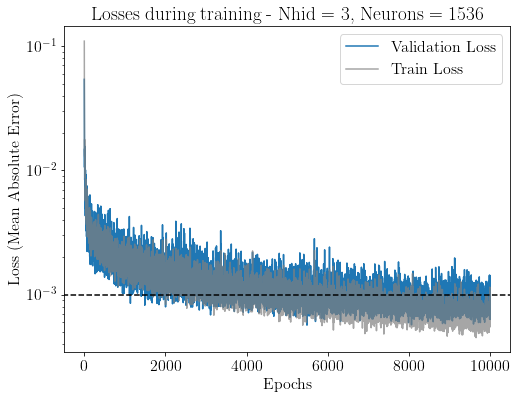

In [31]:
plt.semilogy(history.history['val_loss'])
plt.semilogy(history.history['loss'], color='gray', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.legend(['Validation Loss', 'Train Loss'])
plt.title('Losses during training - Nhid = 3, Neurons = 1536')
plt.axhline(1e-3, -100, 32000, color='black', linestyle='--')
plt.savefig('NHID=3_NEURONS=1536_LOSS.pdf')